# Visualization of Performance Benchmarks mentioned in the Paper


> Author: Tianyu Du
> 
> July 18, 2023
>
> Updated: Mar. 7, 2025

## Notebook Overview

This notebook is designed to help you replicate the performance benchmarking results presented in our paper. It processes experimental logs from two sources—Torch-Choice (Python) experiments and R experiments—and generates the key performance visualizations featured in the paper.

### What It Does

- **Data Ingestion and Harmonization:**  
  The notebook reads CSV files containing experimental logs that include:
  - **Runtime Data:** How long each experiment took to run.
  - **Performance Metrics:** Loss values (derived as negative log-likelihood for R experiments or as best_loss for Torch-Choice experiments). These are not reported in the paper but they help us confirm that both R and Torch-Choice achieves the same log-likelihood.
  - **Additional Metrics (Optional):** Such as the number of epochs until convergence and model parameter counts.

  It converts these diverse inputs into a unified format to ensure that the benchmark results across the different experimental setups are directly comparable.

- **Visualization:**  
  The notebook produces several types of plots:
  - **Time Benchmark:** Shows the execution time (or a time ratio relative to a baseline) as a function of an independent variable (e.g., number of items, records, or latent dimensions).
  - **Loss Benchmark:** Illustrates the performance loss, allowing you to assess the quality of the models based on their negative log-likelihood or best_loss.
  - **Convergence Behavior:** (For Torch-Choice experiments) Highlights the number of epochs needed to reach convergence.
  - **Model Complexity:** Optionally, plots can illustrate how model complexity (in terms of parameter counts) varies with the independent variables.

- **Output:**  
  All figures are automatically saved in a date-stamped output directory with descriptive filenames, making them ready for inclusion in your replication report.

### What You Need to Know Before Running

- **Input Data:**  
  Ensure that the benchmark result CSV files (for both R and Torch-Choice experiments) are available in the specified directories. The files should follow the naming conventions expected by the notebook.
  You can either run these benchmarks yourself or use our results included in the replication material.
  
- **Configurations:**  
  You can toggle between displaying absolute values and normalized ratios (relative to a baseline) in the plots. Additionally, you have the option to apply logarithmic scaling on the axes, as needed.

- **Replicability:**  
  This notebook is built to faithfully replicate the performance analyses reported in the paper. Its structured outputs and descriptive filenames facilitate straightforward inclusion in your replication materials.

  Because the variable of interst here is the software time, please note that if you choose to run the benchmarks yourself, the software time will be affected by the hardware you are using.

- **Output:**  
  All figures are automatically saved in a date-stamped output directory with descriptive filenames, making them ready for inclusion in your replication report.

By following these guidelines, you will be able to generate a comprehensive set of performance visualizations to evaluate runtime, model efficiency, and convergence behavior across diverse experimental conditions.

In [1]:
import os
import warnings
from typing import Tuple
from datetime import datetime

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
import pandas as pd
import seaborn as sns
plt.style.use(["science", "bright"])
# configurations for the plots.
font = {'size': 22}
matplotlib.rc('font', **font)


plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.loc"] = "upper left"
plt.rcParams["figure.dpi"] = 500

# Set Locations of the Benchmark Results and Output Directories.

In [2]:
# Set location of the benchmark results.
R_RECORD_PATH = "/Users/tianyudu/Development/torch-choice/paper_performance_benchmarks/benchmark_results_final"
TORCH_RECORD_PATH = R_RECORD_PATH  # put results in the same path.
OUTPUT_PATH = f"./benchmark_figures_{datetime.now().strftime('%Y%m%d')}"

os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"Figures will be generate to {OUTPUT_PATH}")

Figures will be generate to ./benchmark_figures_20250307


In [3]:
# List files in benchmark directories for reference
print(f"Files in R benchmark directory ({R_RECORD_PATH}):")
if os.path.exists(R_RECORD_PATH):
    for f in os.listdir(R_RECORD_PATH):
        print("- " + f)
else:
    print("Directory not found")

print(f"\nFiles in Torch benchmark directory ({TORCH_RECORD_PATH}):")
if os.path.exists(TORCH_RECORD_PATH):
    for f in os.listdir(TORCH_RECORD_PATH):
        print("- " + f)
else:
    print("Directory not found")

Files in R benchmark directory (/Users/tianyudu/Development/torch-choice/paper_performance_benchmarks/benchmark_results_final):
- R_performance_records.csv
- torch_choice_num_params_experiment_large.csv
- torch_choice_num_params_experiment_small.csv
- torch_choice_num_records_experiment_small.csv
- torch_choice_num_items_experiment_large.csv
- torch_choice_num_items_experiment_small.csv
- torch_choice_num_records_experiment_large.csv
- R_performance_params.csv
- R_performance_items.csv

Files in Torch benchmark directory (/Users/tianyudu/Development/torch-choice/paper_performance_benchmarks/benchmark_results_final):
- R_performance_records.csv
- torch_choice_num_params_experiment_large.csv
- torch_choice_num_params_experiment_small.csv
- torch_choice_num_records_experiment_small.csv
- torch_choice_num_items_experiment_large.csv
- torch_choice_num_items_experiment_small.csv
- torch_choice_num_records_experiment_large.csv
- R_performance_params.csv
- R_performance_items.csv


# Helper Functions

In [4]:
def parse_r_formula(formula: str) -> str:
    """
    Convert an R-style formula to our standard representation used in torch-choice.
    """
    if "user_latent_0" in formula and "item_latent_0" not in formula:
        return "(user_latents|item)"
    elif "item_latent_0" in formula and "user_latent_0" not in formula:
        return "(item_latents|constant)"
    elif "user_latent_0" in formula and "item_latent_0" in formula:
        return "(user_latents|item) + (item_latents|constant)"
    else:
        raise ValueError(f"Unknown formula: {formula}")

def generate_latex_representation_formula(input_formula: str) -> str:
    """
    Provide a nicer LaTeX string for figure legends.
    """
    if input_formula == "(item_latents|constant)":
        return "$\\mu_{uis} = \\beta^\\top Z_i$"
    elif input_formula == "(user_latents|item)":
        return "$\\mu_{uis} = \\alpha_i^\\top X_u$"
    elif input_formula == "(user_latents|item) + (item_latents|constant)":
        return "$\\mu_{uis} = \\alpha_i^\\top X_u + \\beta^\\top Z_i$"
    else:
        return input_formula

def transform_time_to_ratio(df: pd.DataFrame, baseline_parameter: str) -> Tuple[pd.DataFrame, float]:
    """
    For the baseline_parameter (e.g., num_items, num_params, num_records), find the minimum value of baseline_parameter
    per formula and use it as the baseline time.

    For all runtime, report the ratio of runtime to the baseline time instead of the absolute time in seconds.
    It is expected that the minimum baseline_parameter is the same across all formulas.
    """
    # Compute the minimum baseline parameter per formula
    group_min = df.groupby('formula')[baseline_parameter].min()
    unique_baselines = group_min.unique()
    if len(unique_baselines) != 1:
        raise ValueError(
            f"Expected the same minimum '{baseline_parameter}' across all formulas, but got: {group_min.to_dict()}"
        )
    baseline_parameter_value = unique_baselines[0]

    # Get baseline times by averaging times for rows with the baseline parameter value.
    # Since group_min was computed per formula, each formula should have at least one record with that value.
    baseline_times = df[df[baseline_parameter] == baseline_parameter_value]
    baseline_times = baseline_times.groupby('formula')['time'].mean().reset_index().rename(columns={'time': 'baseline_time'})

    # Merge baseline times and calculate ratios
    df = df.merge(
        baseline_times, on='formula', how='left', validate='m:1'
    )
    if df['baseline_time'].isnull().any():
        raise ValueError(
            "Some formulas do not have a baseline time. Check that each formula has at least one record with the minimum baseline parameter value."
        )
    df['time'] = df['time'] / df['baseline_time']

    return df.drop(columns=['baseline_time']), baseline_parameter_value


In [5]:
def visualize_benchmarks_combined(csv_path: str, parameter: str, time_ax, report_ratio: bool = False, log_scale: bool = False, plot_title: str = ""):
    """
    Unified visualization for both Torch (Python) and R performance benchmarks, plotting time cost on the provided axis,
    and additionally generating separate time benchmark figures using both the provided parameter and the 'num_params' column if applicable.

    The function first converts the input data into a common format with columns:
      - parameter: numeric independent variable (e.g., sample_size, num_params, or num_items)
      - time: runtime (seconds)
      - loss: best_loss (Torch) or final_likelihood (R)
      - formula: original formula string
      - formula_display: LaTeX-friendly formula string for legends

    It then plots the runtime (time cost) on the provided Axes (time_ax) and generates common figures for loss and, if available, epochs.
    Additionally, if the independent variable is not 'num_params' and the 'num_params' column exists in the DataFrame,
    a separate figure is generated using 'num_params' as the x-axis.

    Parameters:
      csv_path (str): Path to the CSV file.
      parameter (str): The independent variable being analyzed (num_items, num_params, or num_records).
      time_ax: Matplotlib Axes object on which to plot the time cost.
      report_ratio (bool): Whether to normalize time and loss as ratio values.
      log_scale (bool): Whether to use logarithmic scales on axes.
      plot_title (str): Title to be used (or prefixed) for each plot.

    Returns:
      Tuple containing (None, epochs_fig, loss_fig, num_params_fig).
      The time cost is plotted on the provided time_ax.
      If a separate num_params figure is not generated, num_params_fig will be None.
      Note: Avoid using loss_fig.show() on non-interactive backends (such as FigureCanvasAgg) to prevent warnings.
            Instead, consider saving the figure using loss_fig.savefig().
    """
    assert parameter in ["num_items", "num_params", "num_records"]

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Could not find file: {csv_path}")

    # Load and preprocess data
    df = pd.read_csv(csv_path, low_memory=False)
    # ==================================================================================================================
    # Homogenize the experiment log data from R and torch-choice.
    # ==================================================================================================================
    if "final_likelihood" in df.columns:
        # R experiment processing
        df["loss"] = -df["final_likelihood"]
        df["formula"] = df["formula"].apply(parse_r_formula)
    elif "best_loss" in df.columns:
        # Torch experiment processing
        df["loss"] = df["best_loss"]
    else:
        raise ValueError(
            "Unrecognized data format. CSV must contain either 'final_likelihood' (for R experiments) or 'best_loss' (for torch-choice experiments)."
        )

    # Create consistent parametjer column and formula display
    df["parameter"] = pd.to_numeric(df[parameter])
    df["formula_display"] = df["formula"].apply(generate_latex_representation_formula)

    # Time transformations
    if report_ratio:
        df, baseline_parameter_value = transform_time_to_ratio(df, parameter)
    else:
        baseline_parameter_value = None

    # Visualization setup
    param_display_name = {
        "num_records": "Number of Records",
        "num_params": "Number of Latent Dimensions",
        "num_items": "Number of Items"
    }[parameter]

    # Ensure consistent colors for formulas
    unique_formulas = sorted(df["formula"].unique())
    palette = sns.color_palette("deep", len(unique_formulas))
    formula_color_mapping = {formula: palette[i] for i, formula in enumerate(unique_formulas)}

    # Plot time cost on the provided Axes instead of creating a new figure
    plot_time_on_ax(time_ax, df, param_display_name, formula_color_mapping, report_ratio, baseline_parameter_value, log_scale)
    if plot_title:
        if "gpu_name" in df.columns:
            assert df["gpu_name"].nunique() == 1, "Inconsistent GPU models in benchmarks!"

        gpu_info = f" - GPU: {df['gpu_name'].iloc[0]}" if "gpu_name" in df.columns else ""
        time_ax.set_title(f"{plot_title} - Time Benchmark{gpu_info}", fontsize=16)

    # Create figures for epochs and loss, setting titles if provided
    epochs_fig = create_epochs_figure(df, param_display_name, formula_color_mapping, log_scale, plot_title=plot_title) if "epochs_run" in df.columns else None
    loss_fig = create_loss_figure(df, param_display_name, formula_color_mapping, report_ratio, log_scale, plot_title=plot_title)


    if "parameter_count" in df.columns:
        fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 6), dpi=300)
        for i, fml in enumerate(df["formula_display"].unique()):
            sub_df = df[df["formula_display"] == fml]
            sns.lineplot(data=sub_df, x=parameter, y="parameter_count", markers=True, dashes=False, ax=axes[i])
            axes[i].set_title(f"{plot_title} - Parameter Count \n {fml}", fontsize=16)
        fig.savefig(os.path.join(OUTPUT_PATH, f"debug_model_size_{parameter}.pdf"))

    return epochs_fig, loss_fig

def plot_time_on_ax(ax, df, param_display_name, color_mapping, report_ratio, baseline_value, log_scale):
    """
    Plot time cost on the provided Axes object.
    """
    for formula in sorted(df["formula"].unique()):
        sub_df = df[df["formula"] == formula]
        stats = sub_df.groupby("parameter").agg({"time": ["mean", "std"]}).reset_index()
        stats.columns = ["parameter", "mean_time", "std_time"]
        stats = stats.sort_values("parameter")

        ax.errorbar(
            stats["parameter"],
            stats["mean_time"],
            yerr=stats["std_time"],
            label=sub_df["formula_display"].iloc[0],
            color=color_mapping[formula],
            marker="o",
            markersize=8,
            linewidth=2.5,
            capsize=5,
            alpha=0.9,
            markeredgewidth=1.5
        )

    ax.set_xlabel(param_display_name, fontsize=14, labelpad=10)
    ylabel = "Time (seconds)" if not report_ratio else f"Time Ratio (Baseline: {baseline_value:,})"
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)
    configure_axes(ax, log_scale)
    ax.legend(
        title="Model Specification",
        fontsize=12,
        title_fontsize=13,
        frameon=True,
        shadow=False,
        edgecolor='black',
        loc='upper left'
    )
    ax.figure.tight_layout()


def create_epochs_figure(df, param_display_name, color_mapping, log_scale, plot_title=""):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for formula in sorted(df["formula"].unique()):
        sub_df = df[df["formula"] == formula]
        stats = sub_df.groupby("parameter").agg({"epochs_run": ["mean", "std"]}).reset_index()
        stats.columns = ["parameter", "mean_epochs", "std_epochs"]
        stats = stats.sort_values("parameter")

        ax.errorbar(
            stats["parameter"],
            stats["mean_epochs"],
            yerr=stats["std_epochs"],
            label=sub_df["formula_display"].iloc[0],
            color=color_mapping[formula],
            marker="s",
            markersize=8,
            linewidth=2.5,
            capsize=5,
            alpha=0.9,
            markeredgewidth=1.5
        )

    ax.set_xlabel(param_display_name, fontsize=14, labelpad=10)
    ax.set_ylabel("Epochs Until Convergence (Torch-Choice Only)", fontsize=14, labelpad=10)
    configure_axes(ax, log_scale)
    ax.legend(
        title="Model Specification",
        fontsize=12,
        title_fontsize=13,
        frameon=True,
        shadow=False,
        edgecolor='black',
        loc='upper left'
    )
    if plot_title:
        fig.suptitle(f"{plot_title} - Epochs Until Convergence", fontsize=16)
    fig.tight_layout()
    return fig

def create_loss_figure(df, param_display_name, color_mapping, report_ratio, log_scale, plot_title=""):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for formula in sorted(df["formula"].unique()):
        sub_df = df[df["formula"] == formula]
        stats = sub_df.groupby("parameter").agg({"loss": ["mean", "std"]}).reset_index()
        stats.columns = ["parameter", "mean_loss", "std_loss"]
        stats = stats.sort_values("parameter")

        ax.errorbar(
            stats["parameter"],
            stats["mean_loss"],
            yerr=stats["std_loss"],
            label=sub_df["formula_display"].iloc[0],
            color=color_mapping[formula],
            marker="D",
            markersize=8,
            linewidth=2.5,
            capsize=5,
            alpha=0.9,
            markeredgewidth=1.5
        )

    loss_label = "Negative Log-Likelihood" + (" Ratio" if report_ratio else "")
    ax.set_xlabel(param_display_name, fontsize=14, labelpad=10)
    ax.set_ylabel(loss_label, fontsize=14, labelpad=10)
    configure_axes(ax, log_scale, y_log=False)
    ax.legend(
        title="Model Specification",
        fontsize=12,
        title_fontsize=13,
        frameon=True,
        shadow=False,
        edgecolor='black',
        loc='upper left'
    )
    if plot_title:
        fig.suptitle(f"{plot_title} - Loss Benchmark", fontsize=16)
    fig.tight_layout()
    return fig

def configure_axes(ax, log_scale, y_log=True):
    if log_scale:
        ax.set_xscale("log")
        if y_log:
            ax.set_yscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())
    else:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle='-', alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

/var/folders/r3/rj0t5xcj557855yt3xr0qwnh0000gn/T/ipykernel_23891/75551394.py:180: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6), dpi=300)


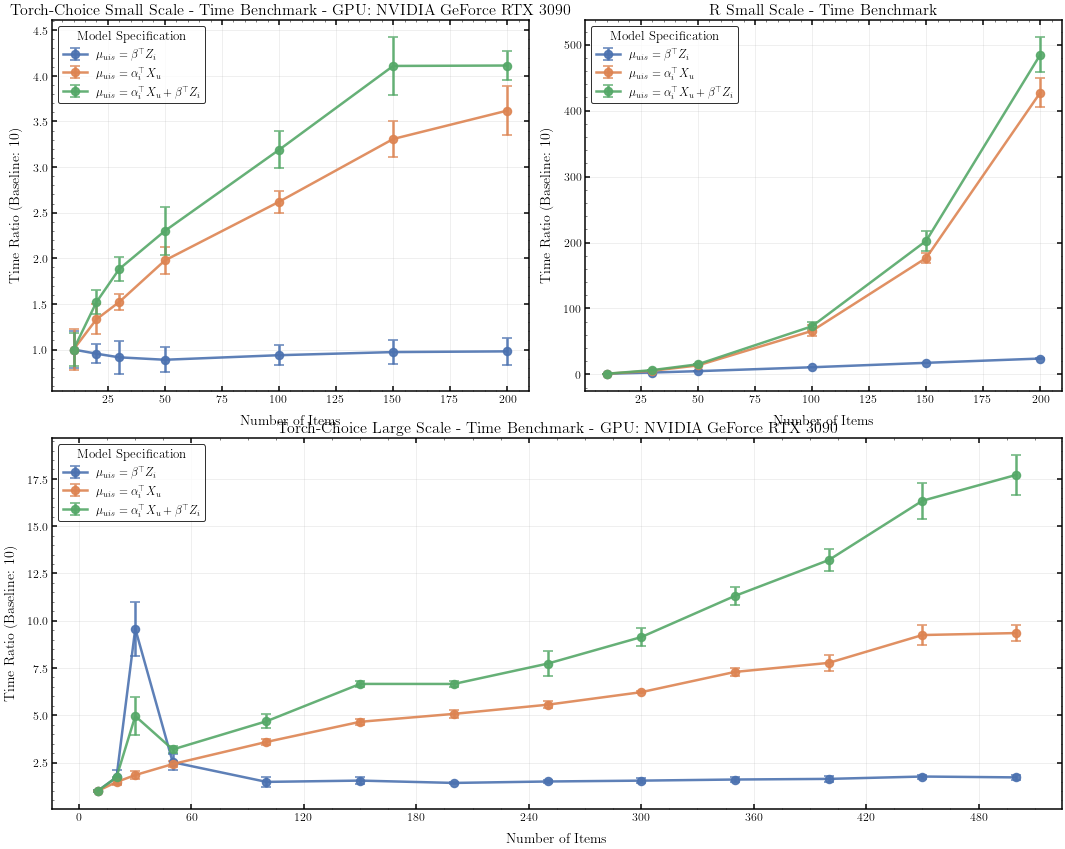

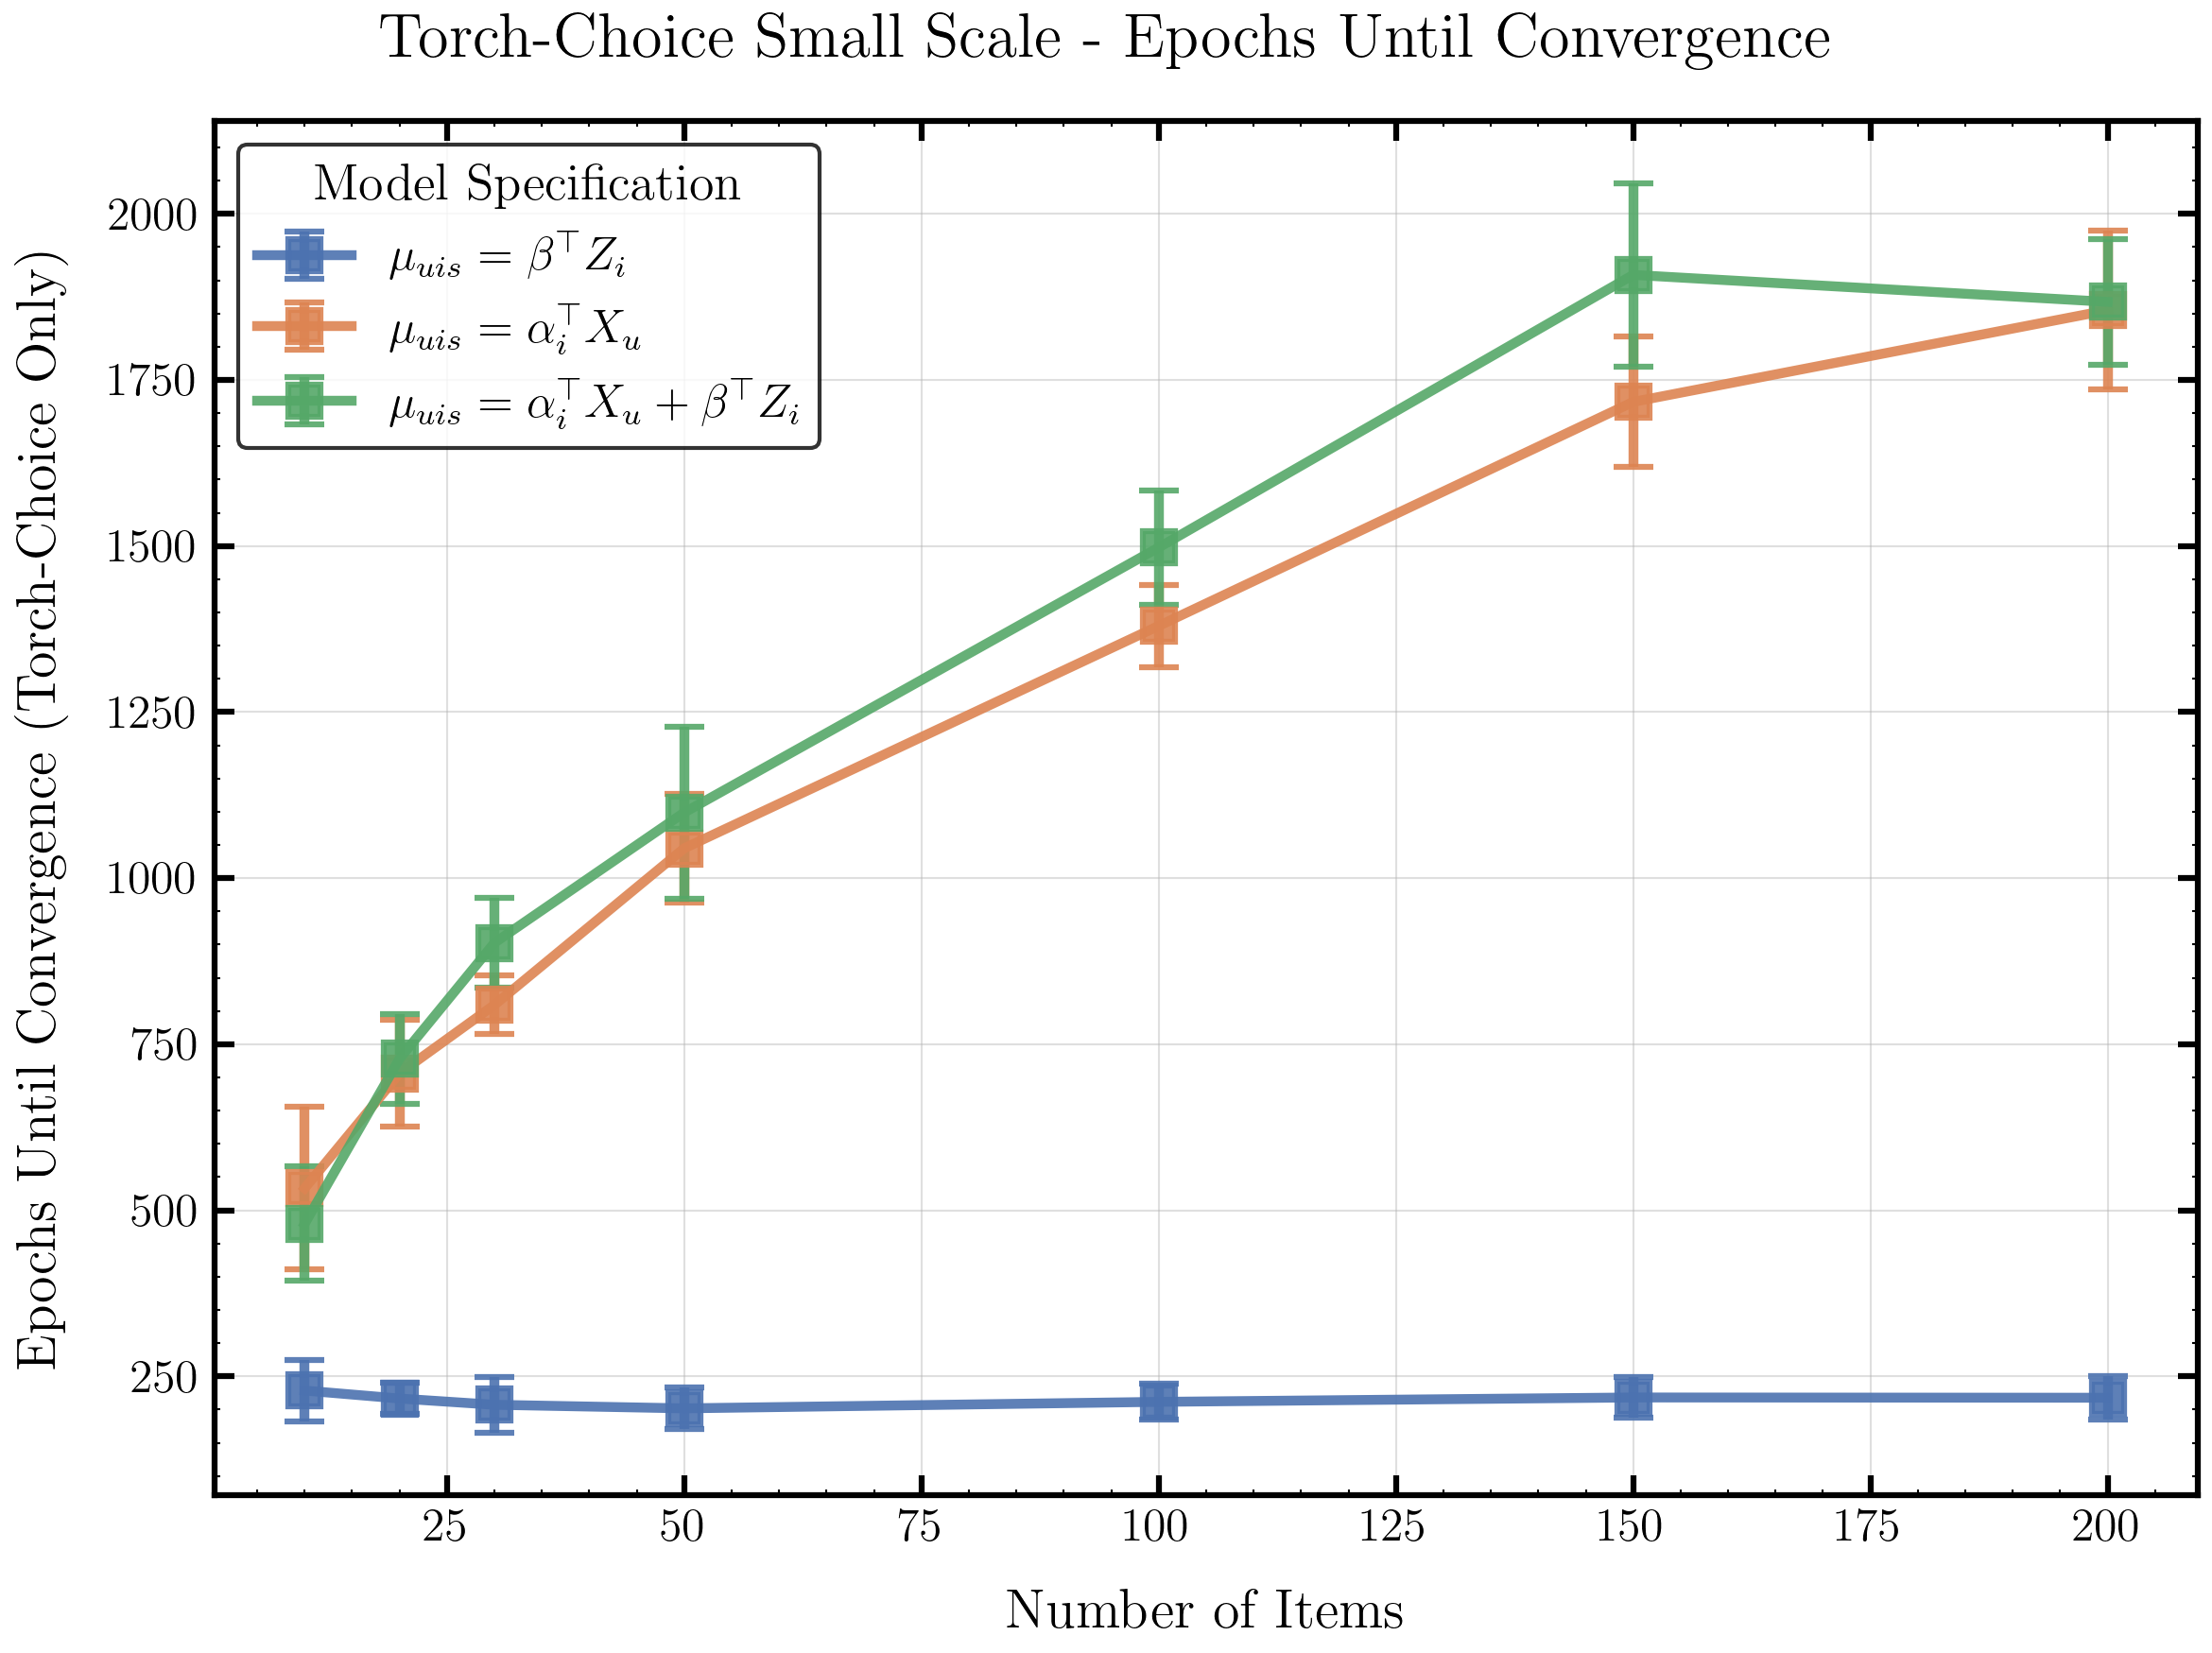

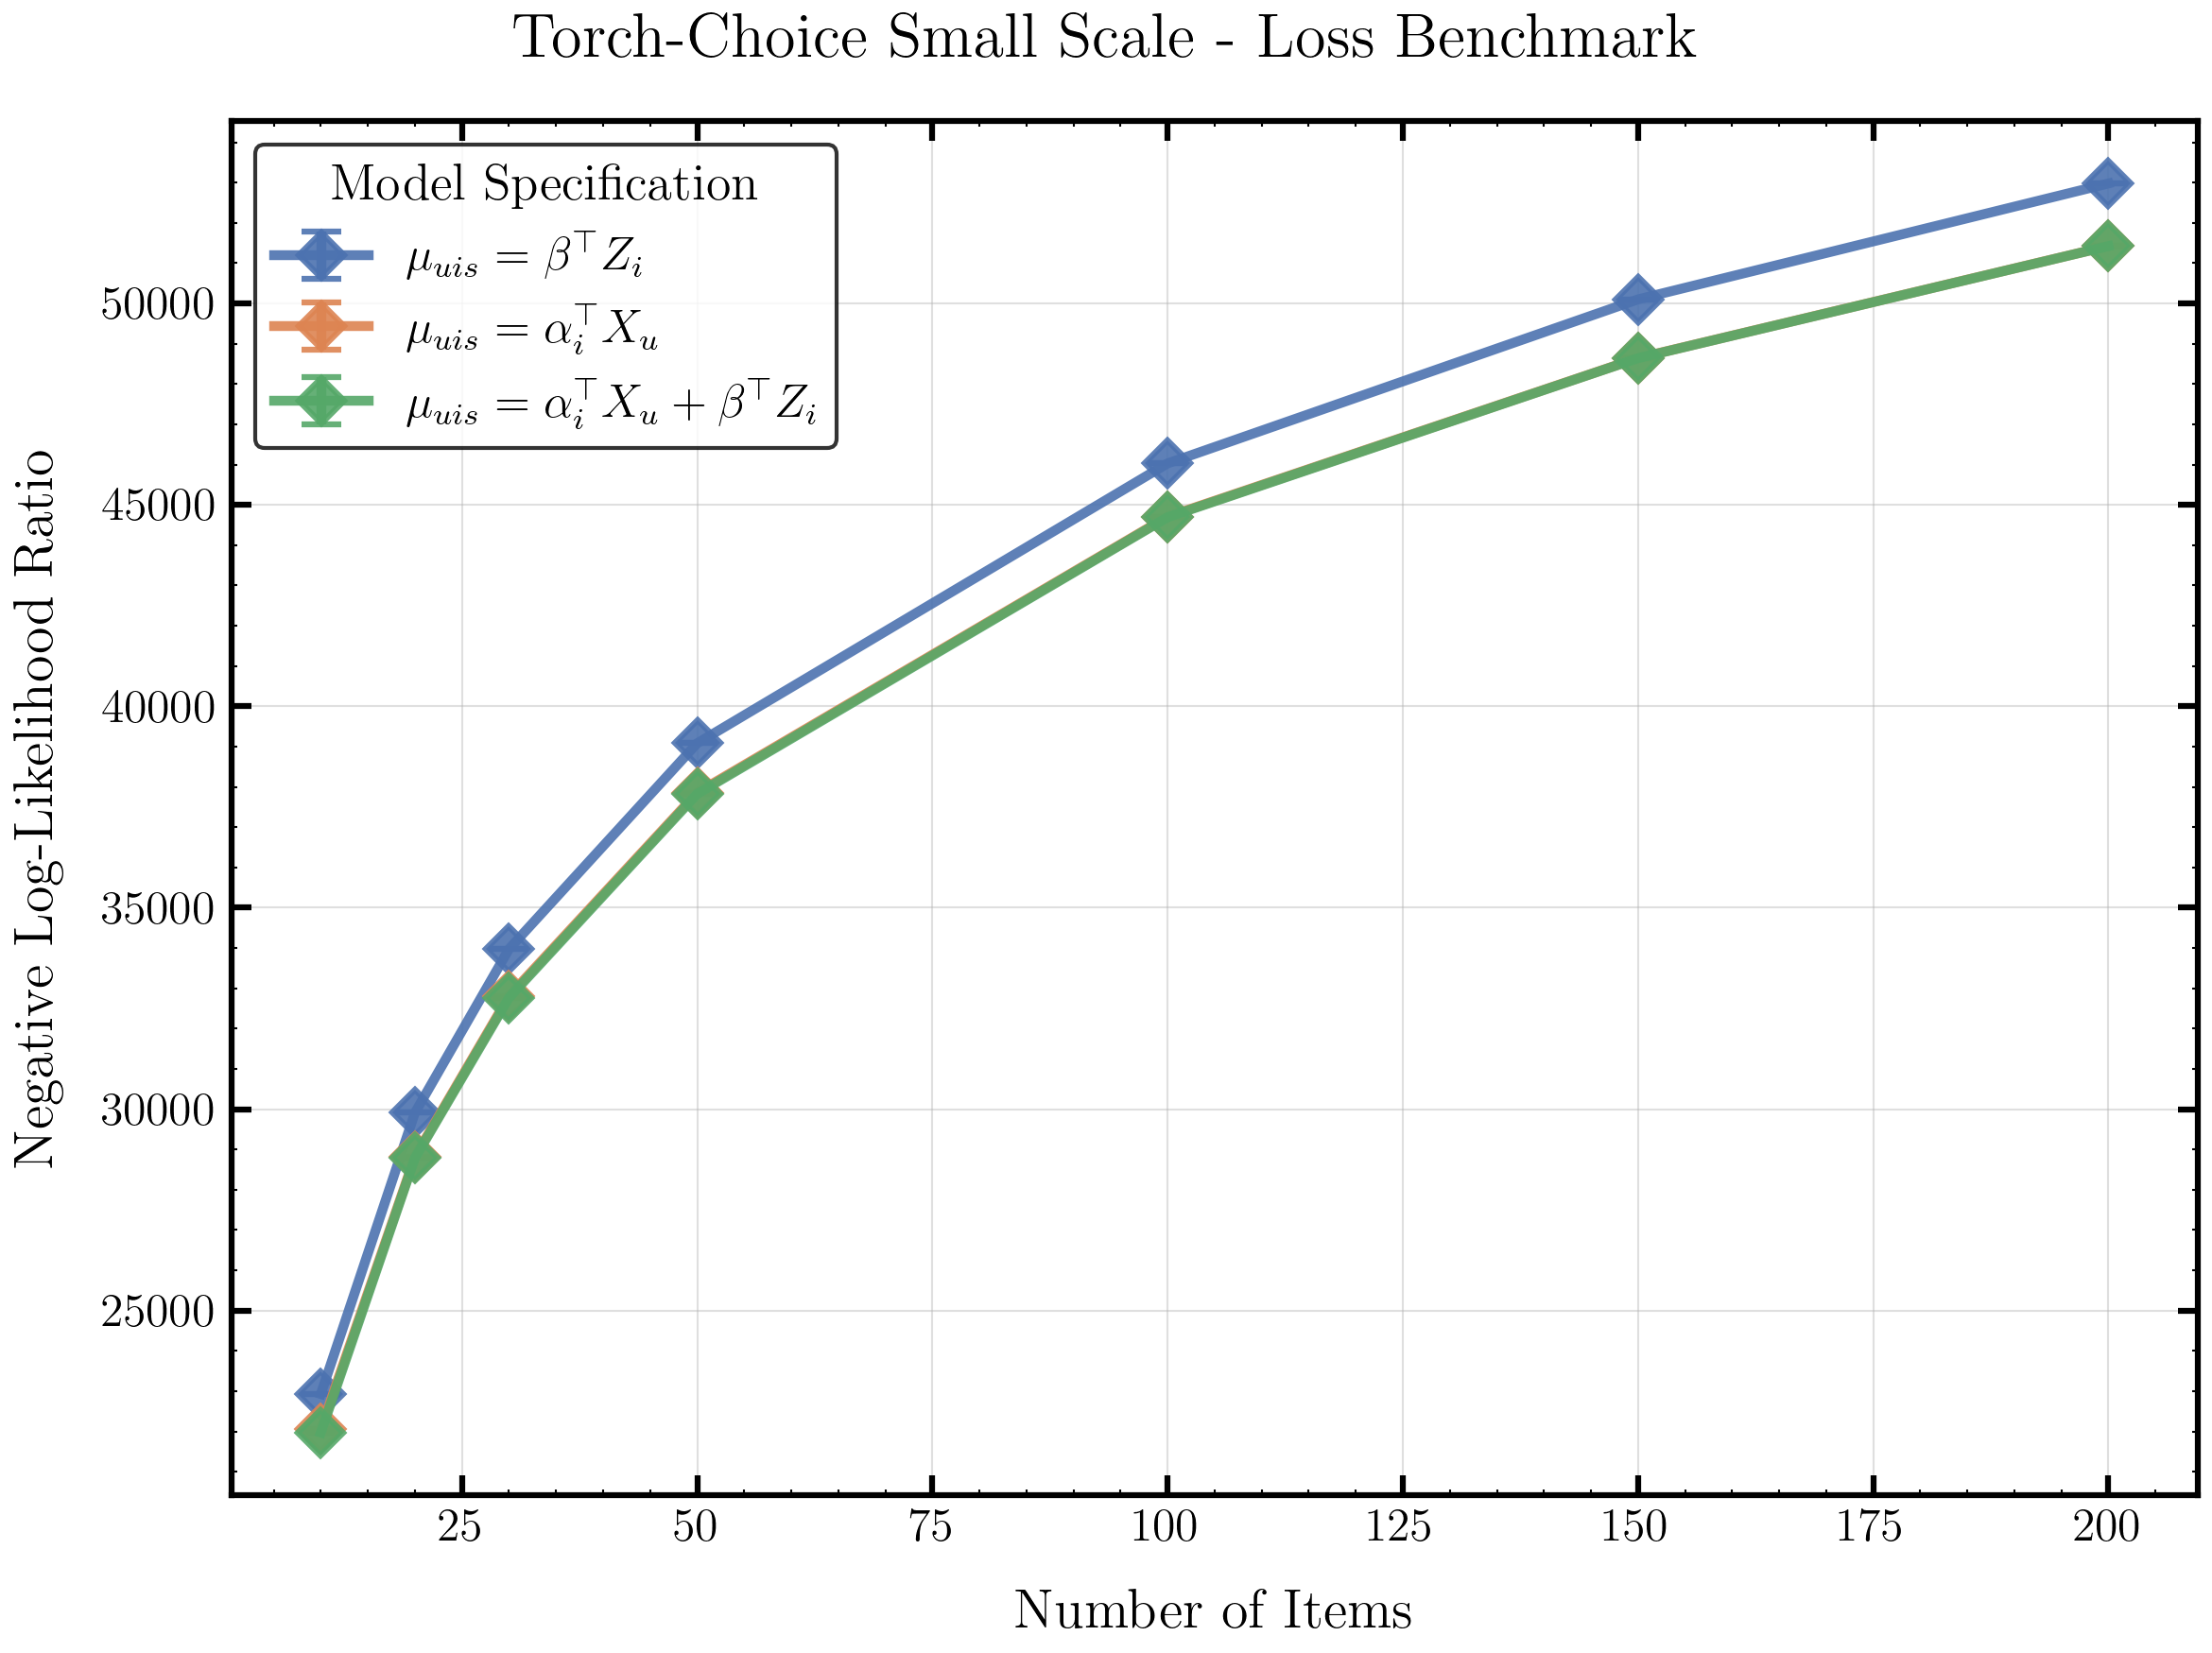

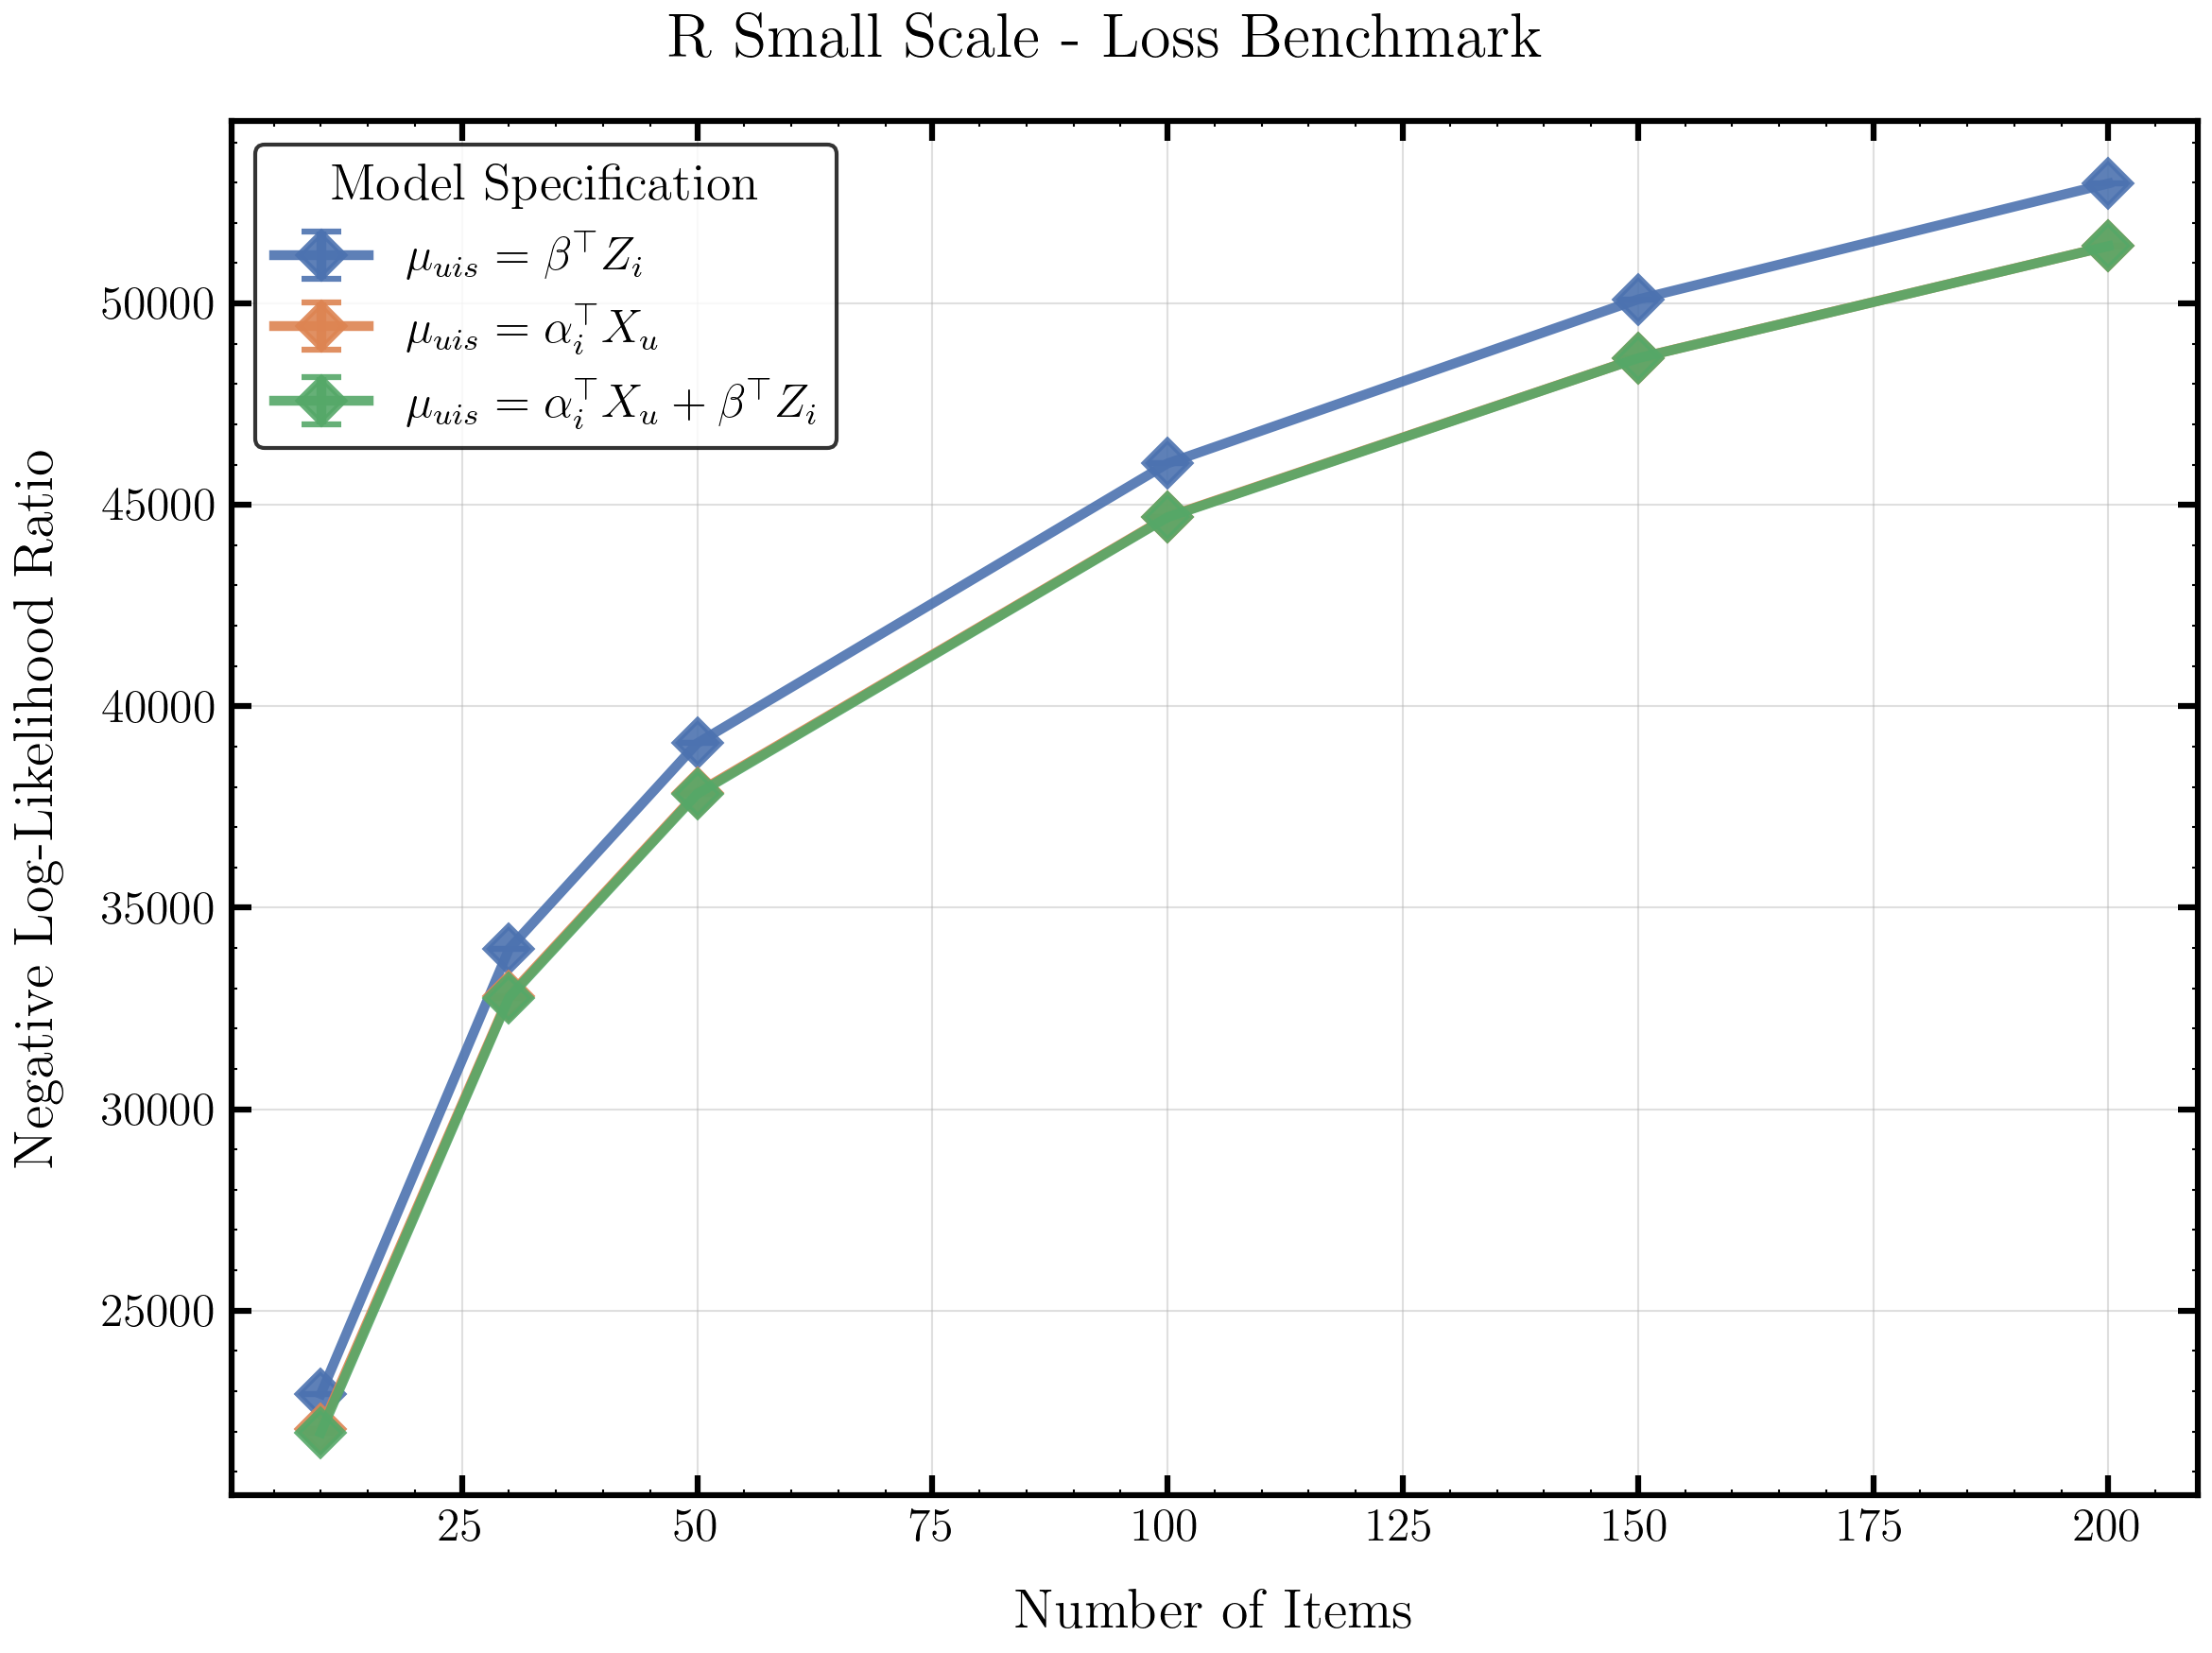

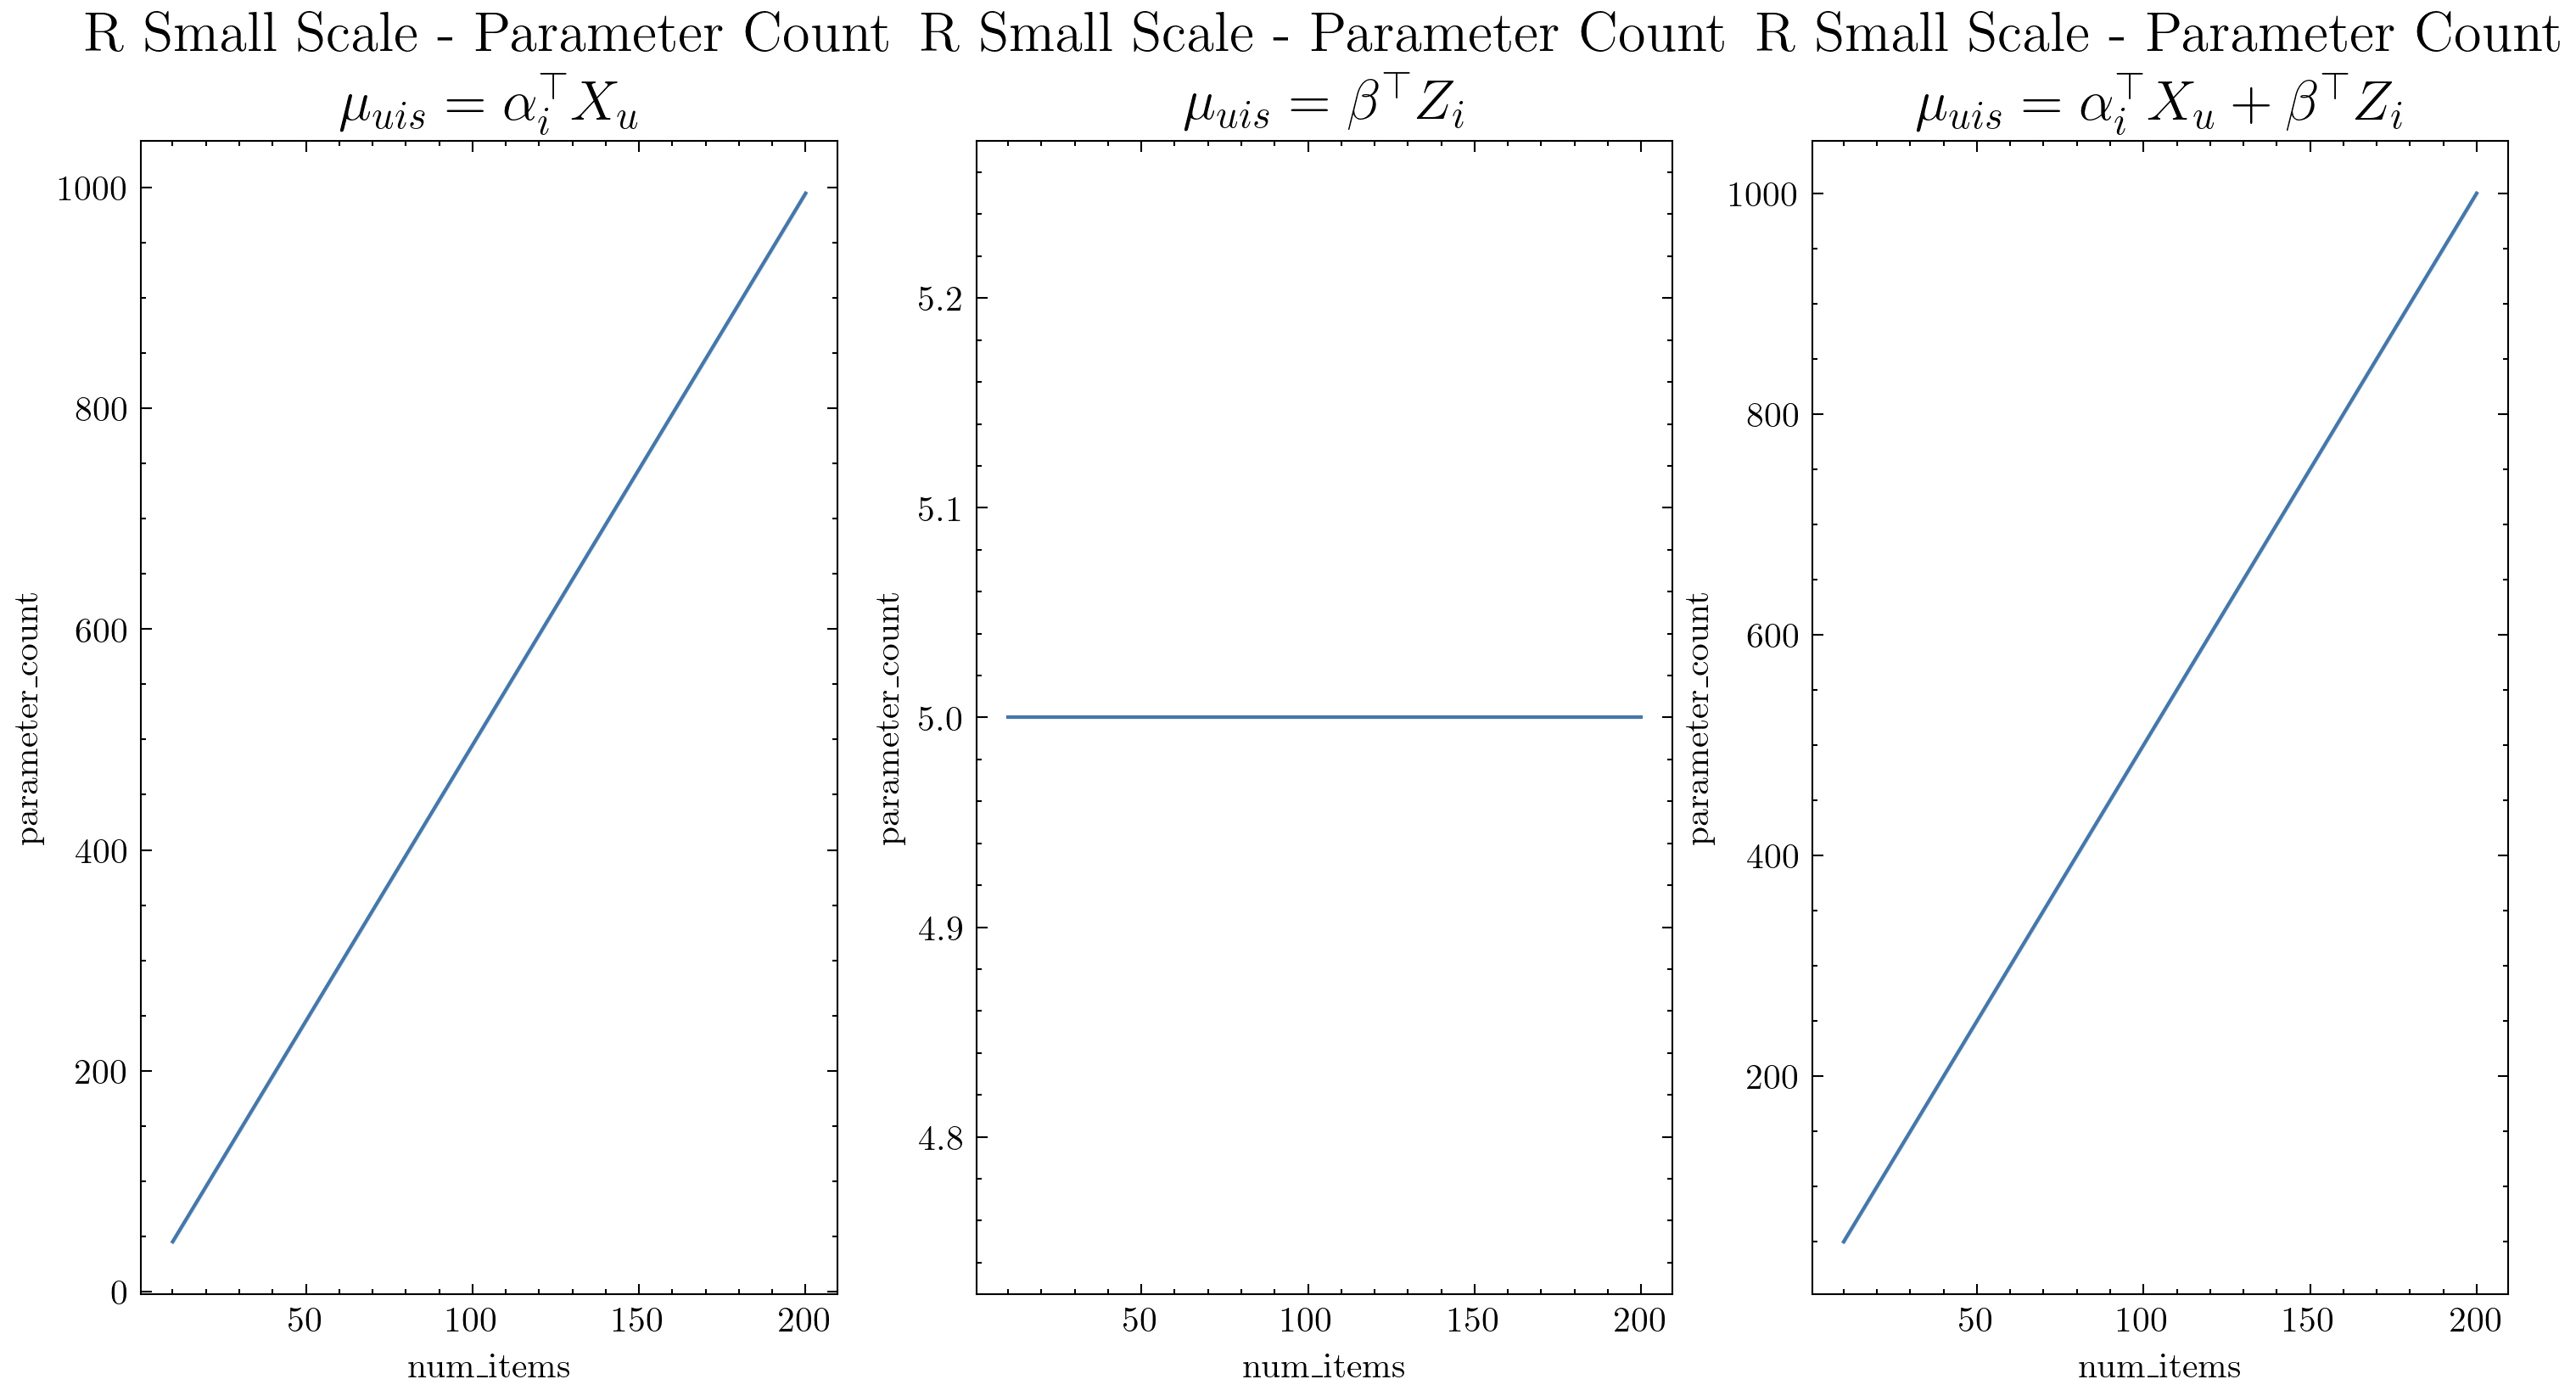

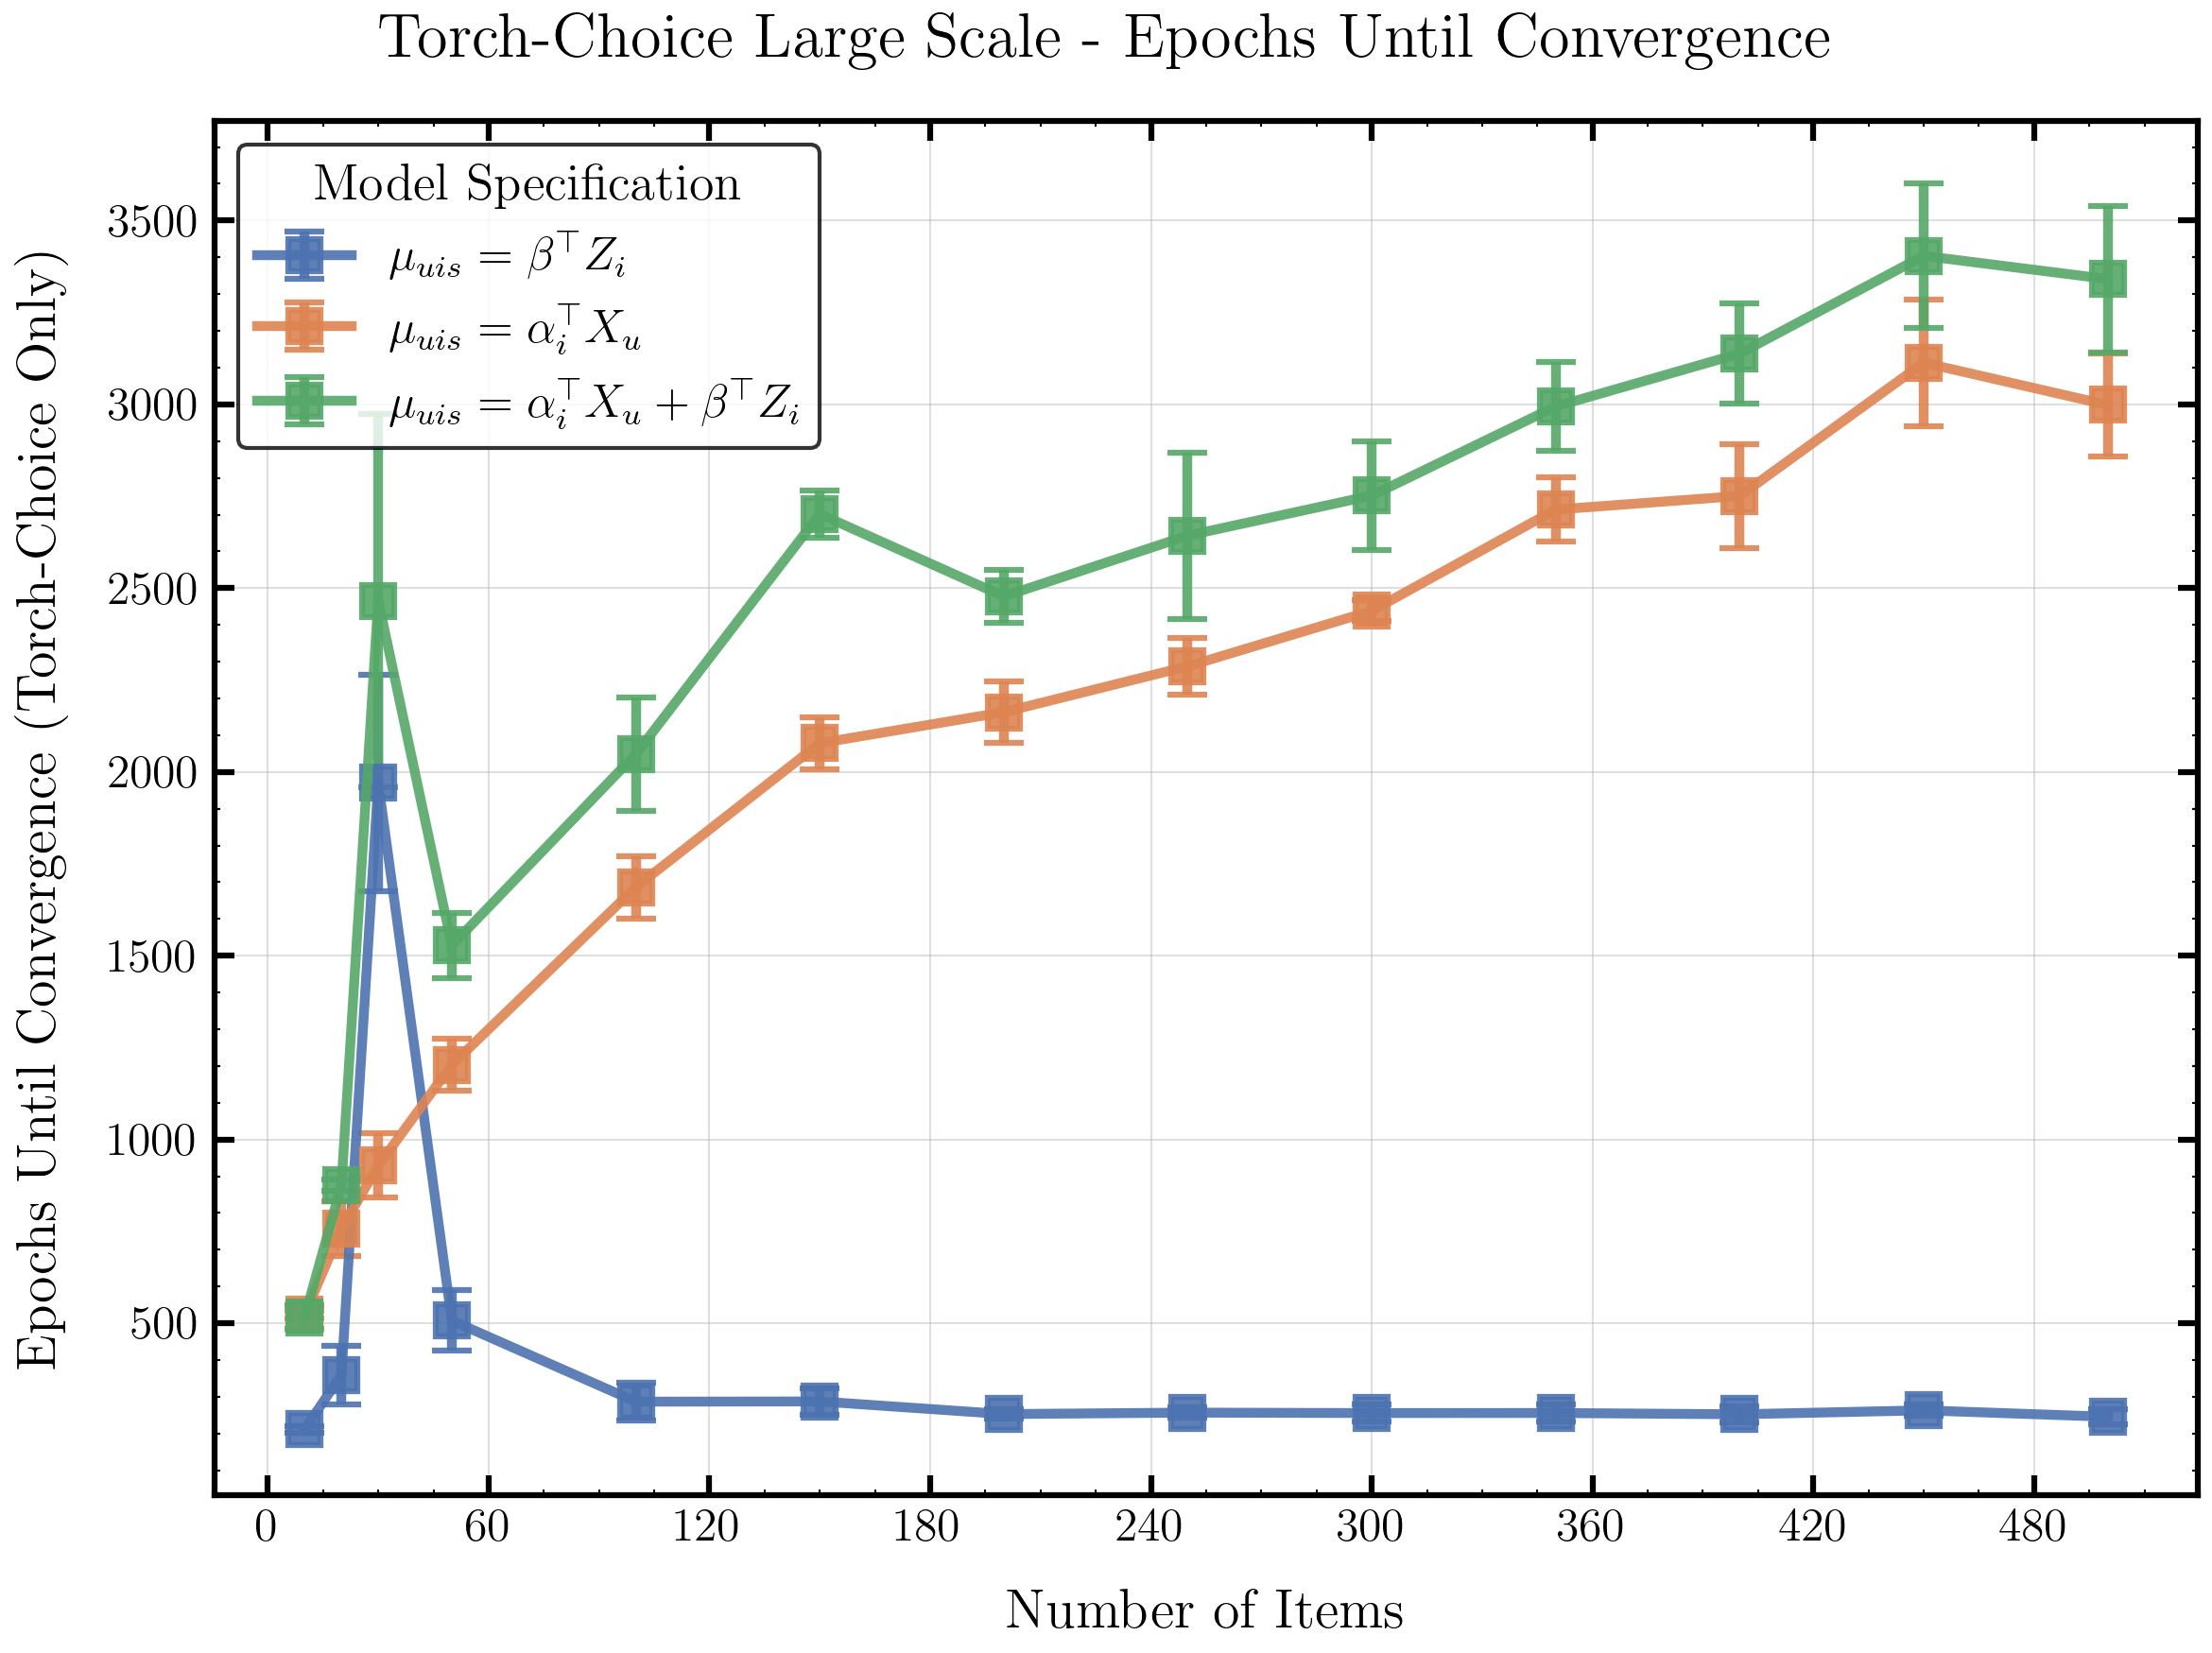

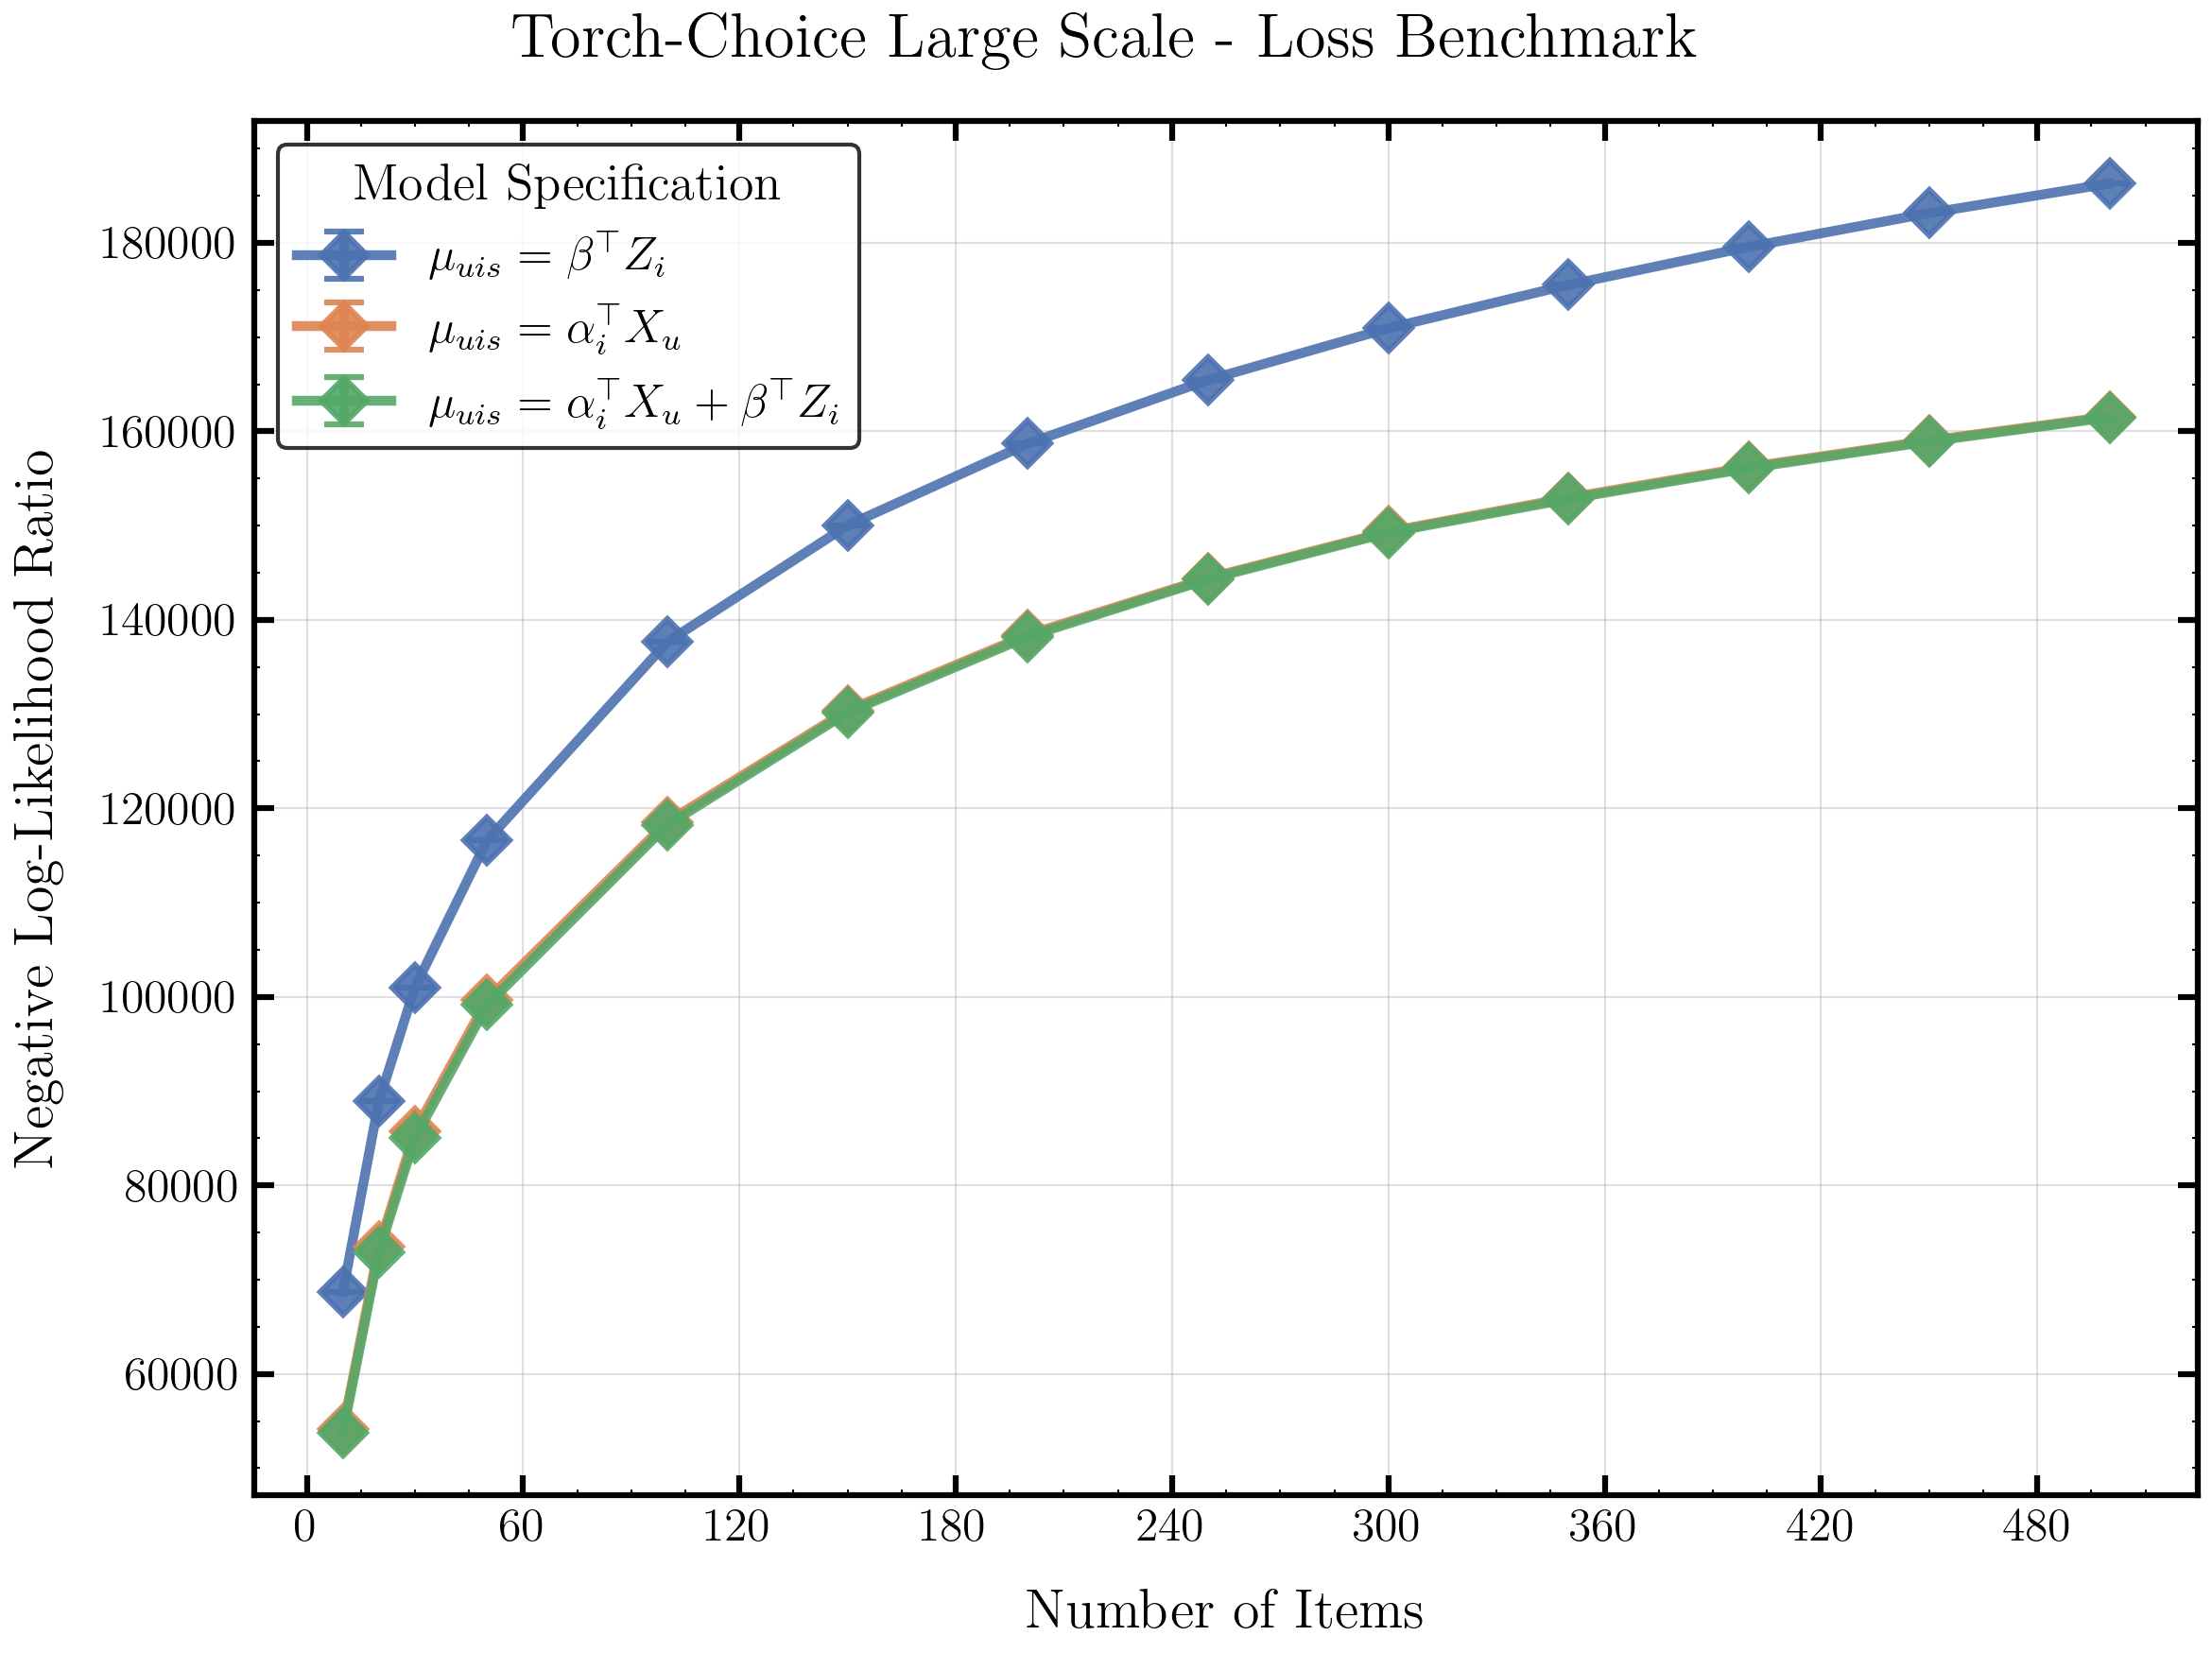

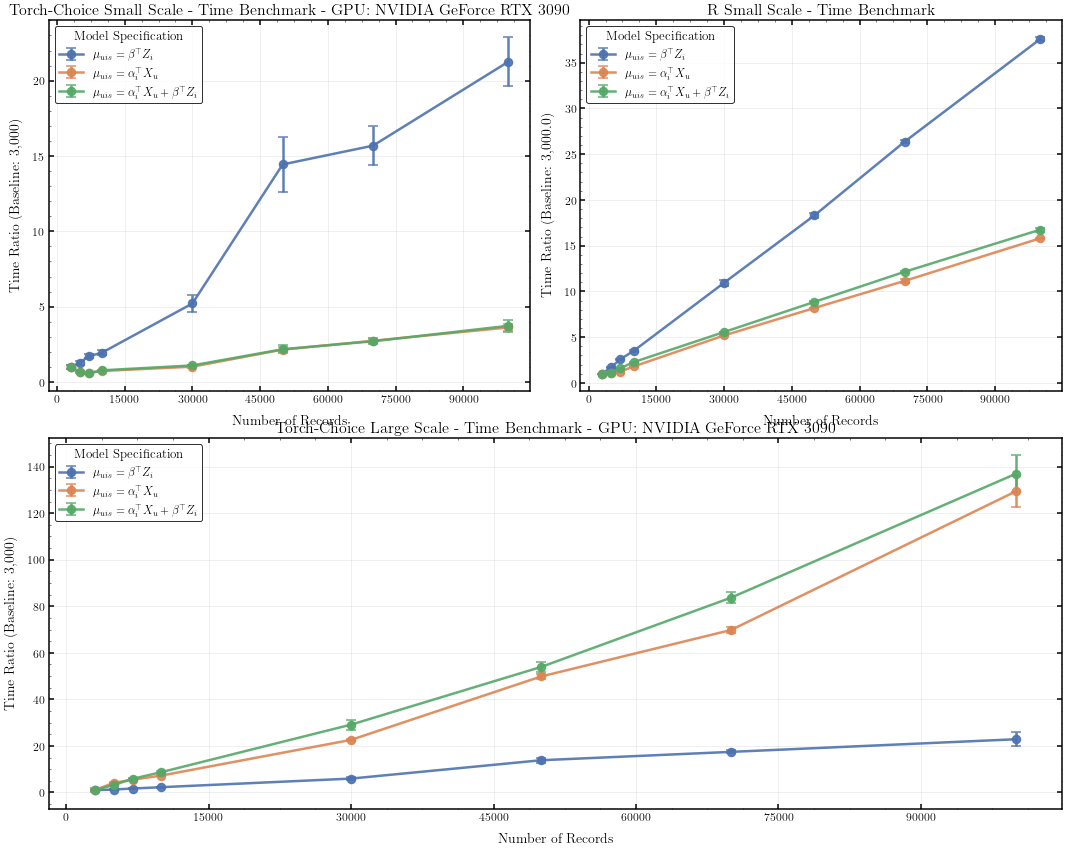

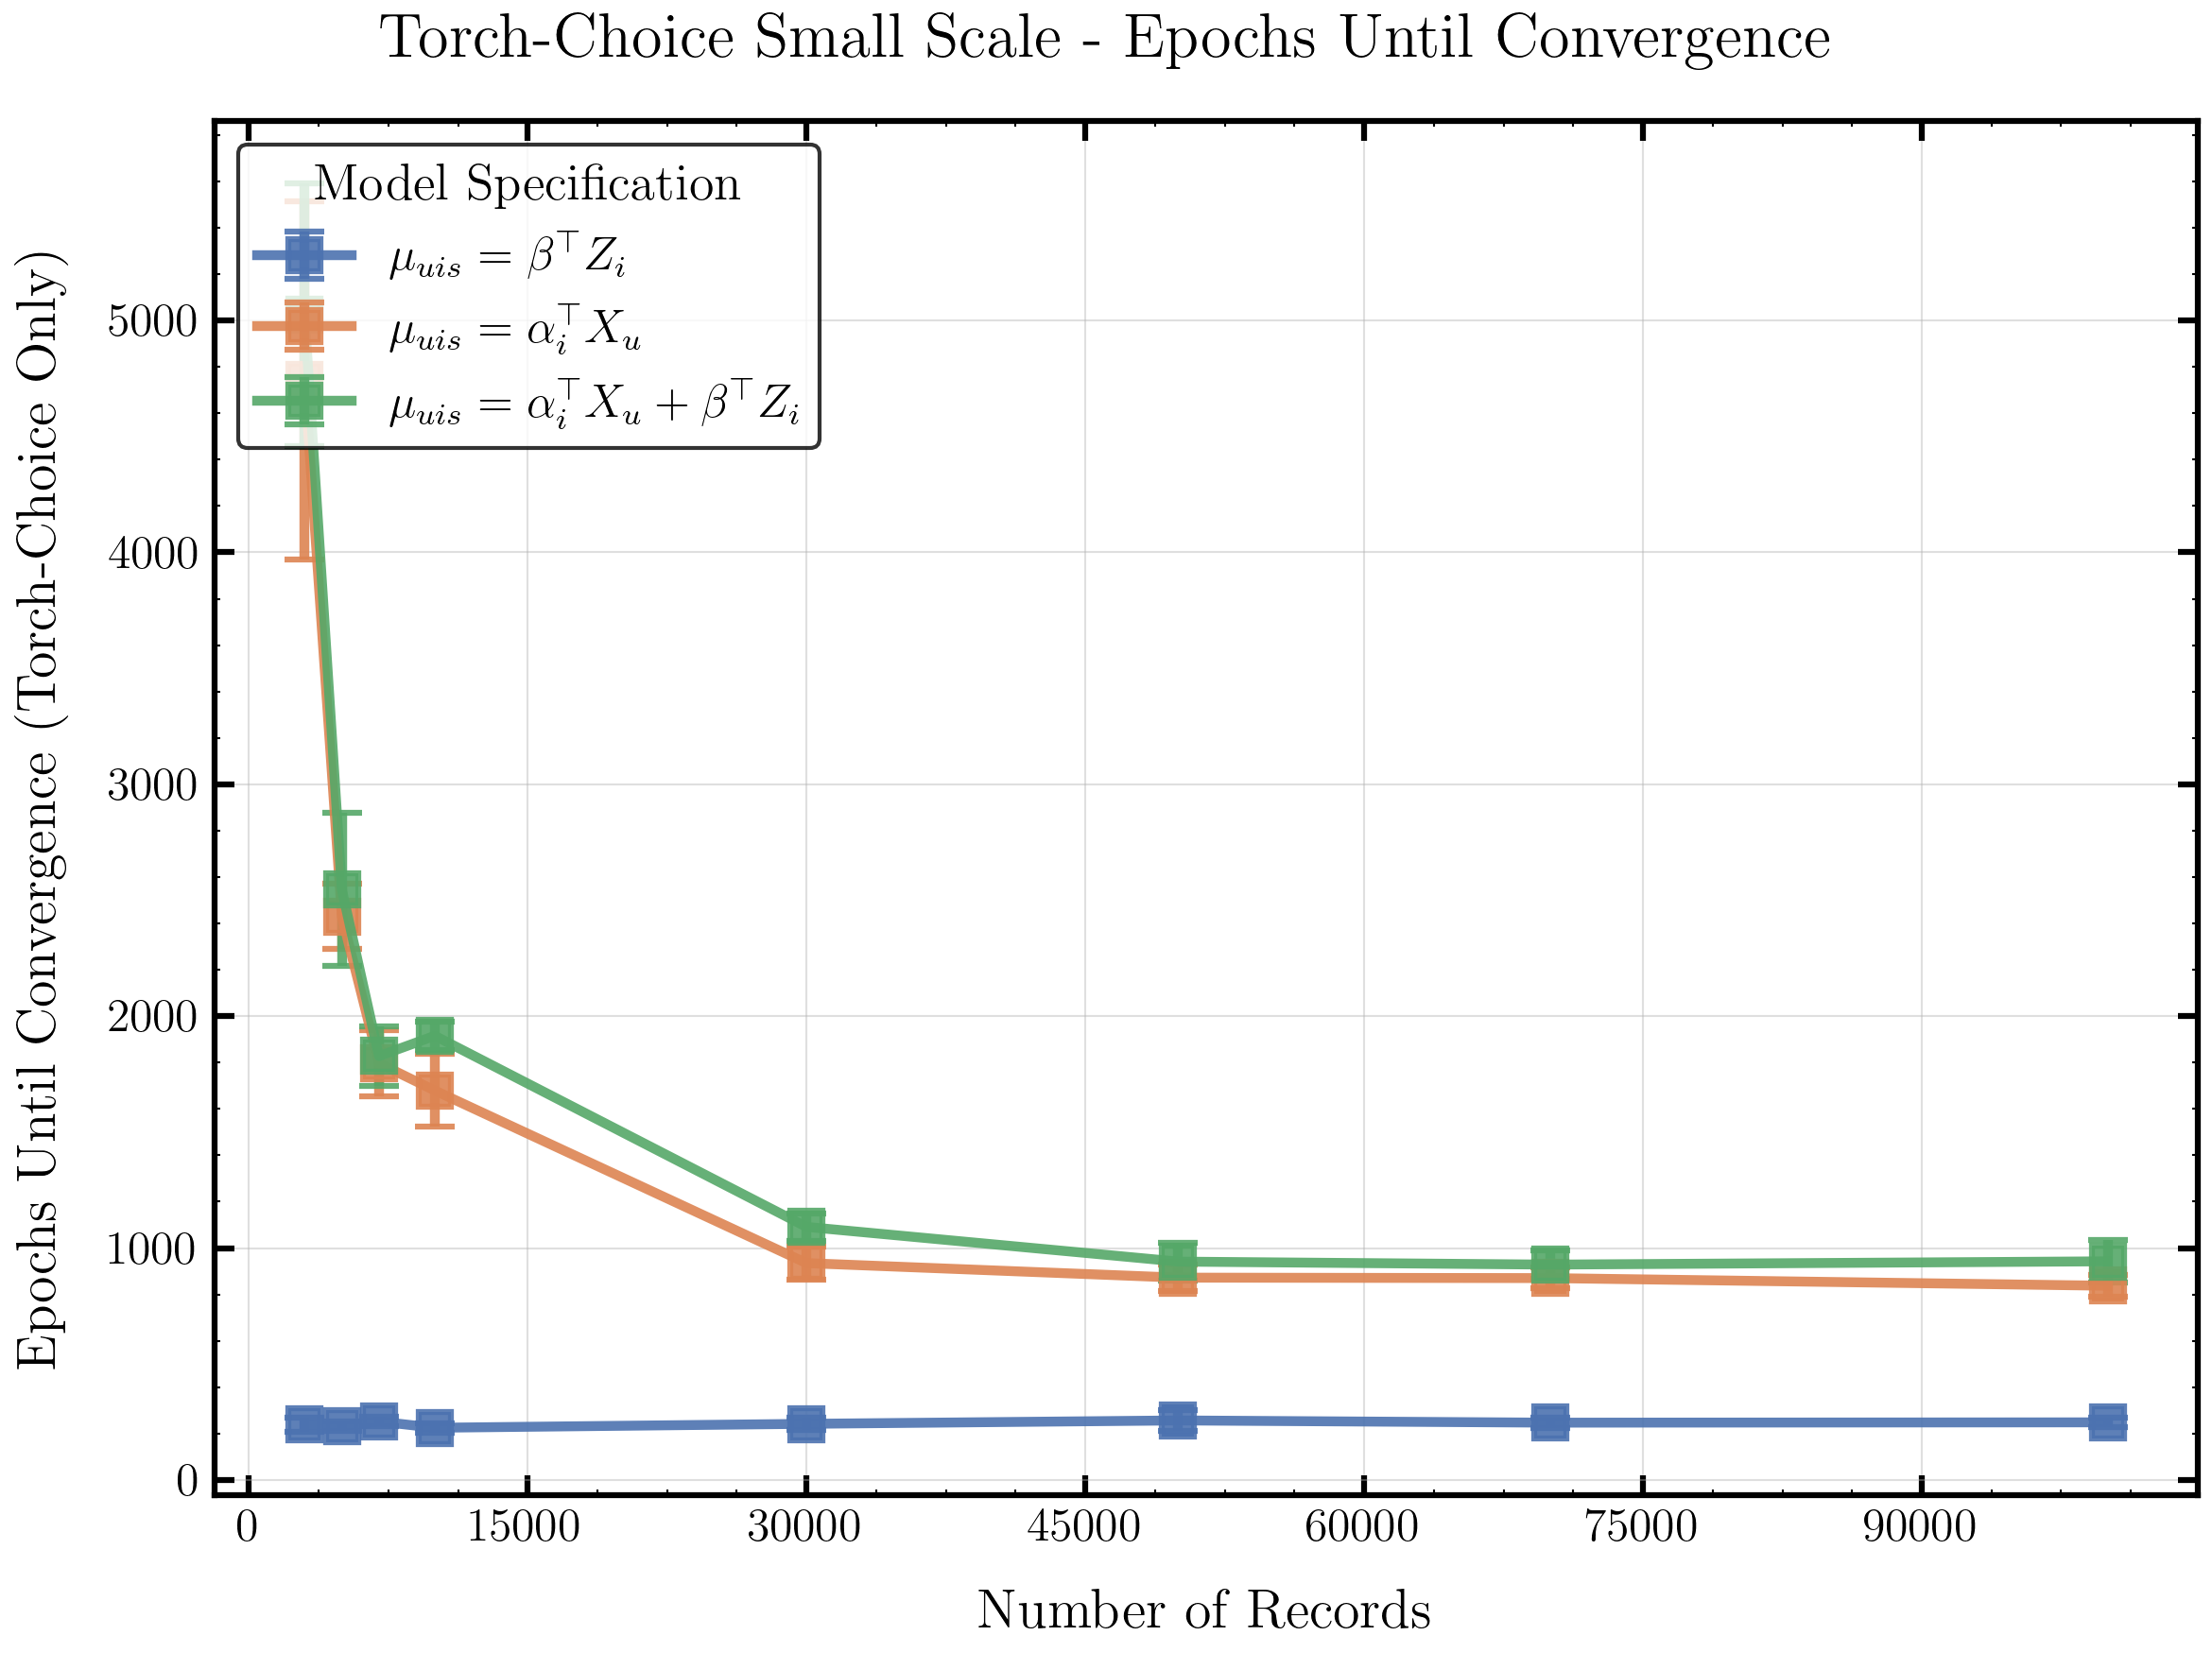

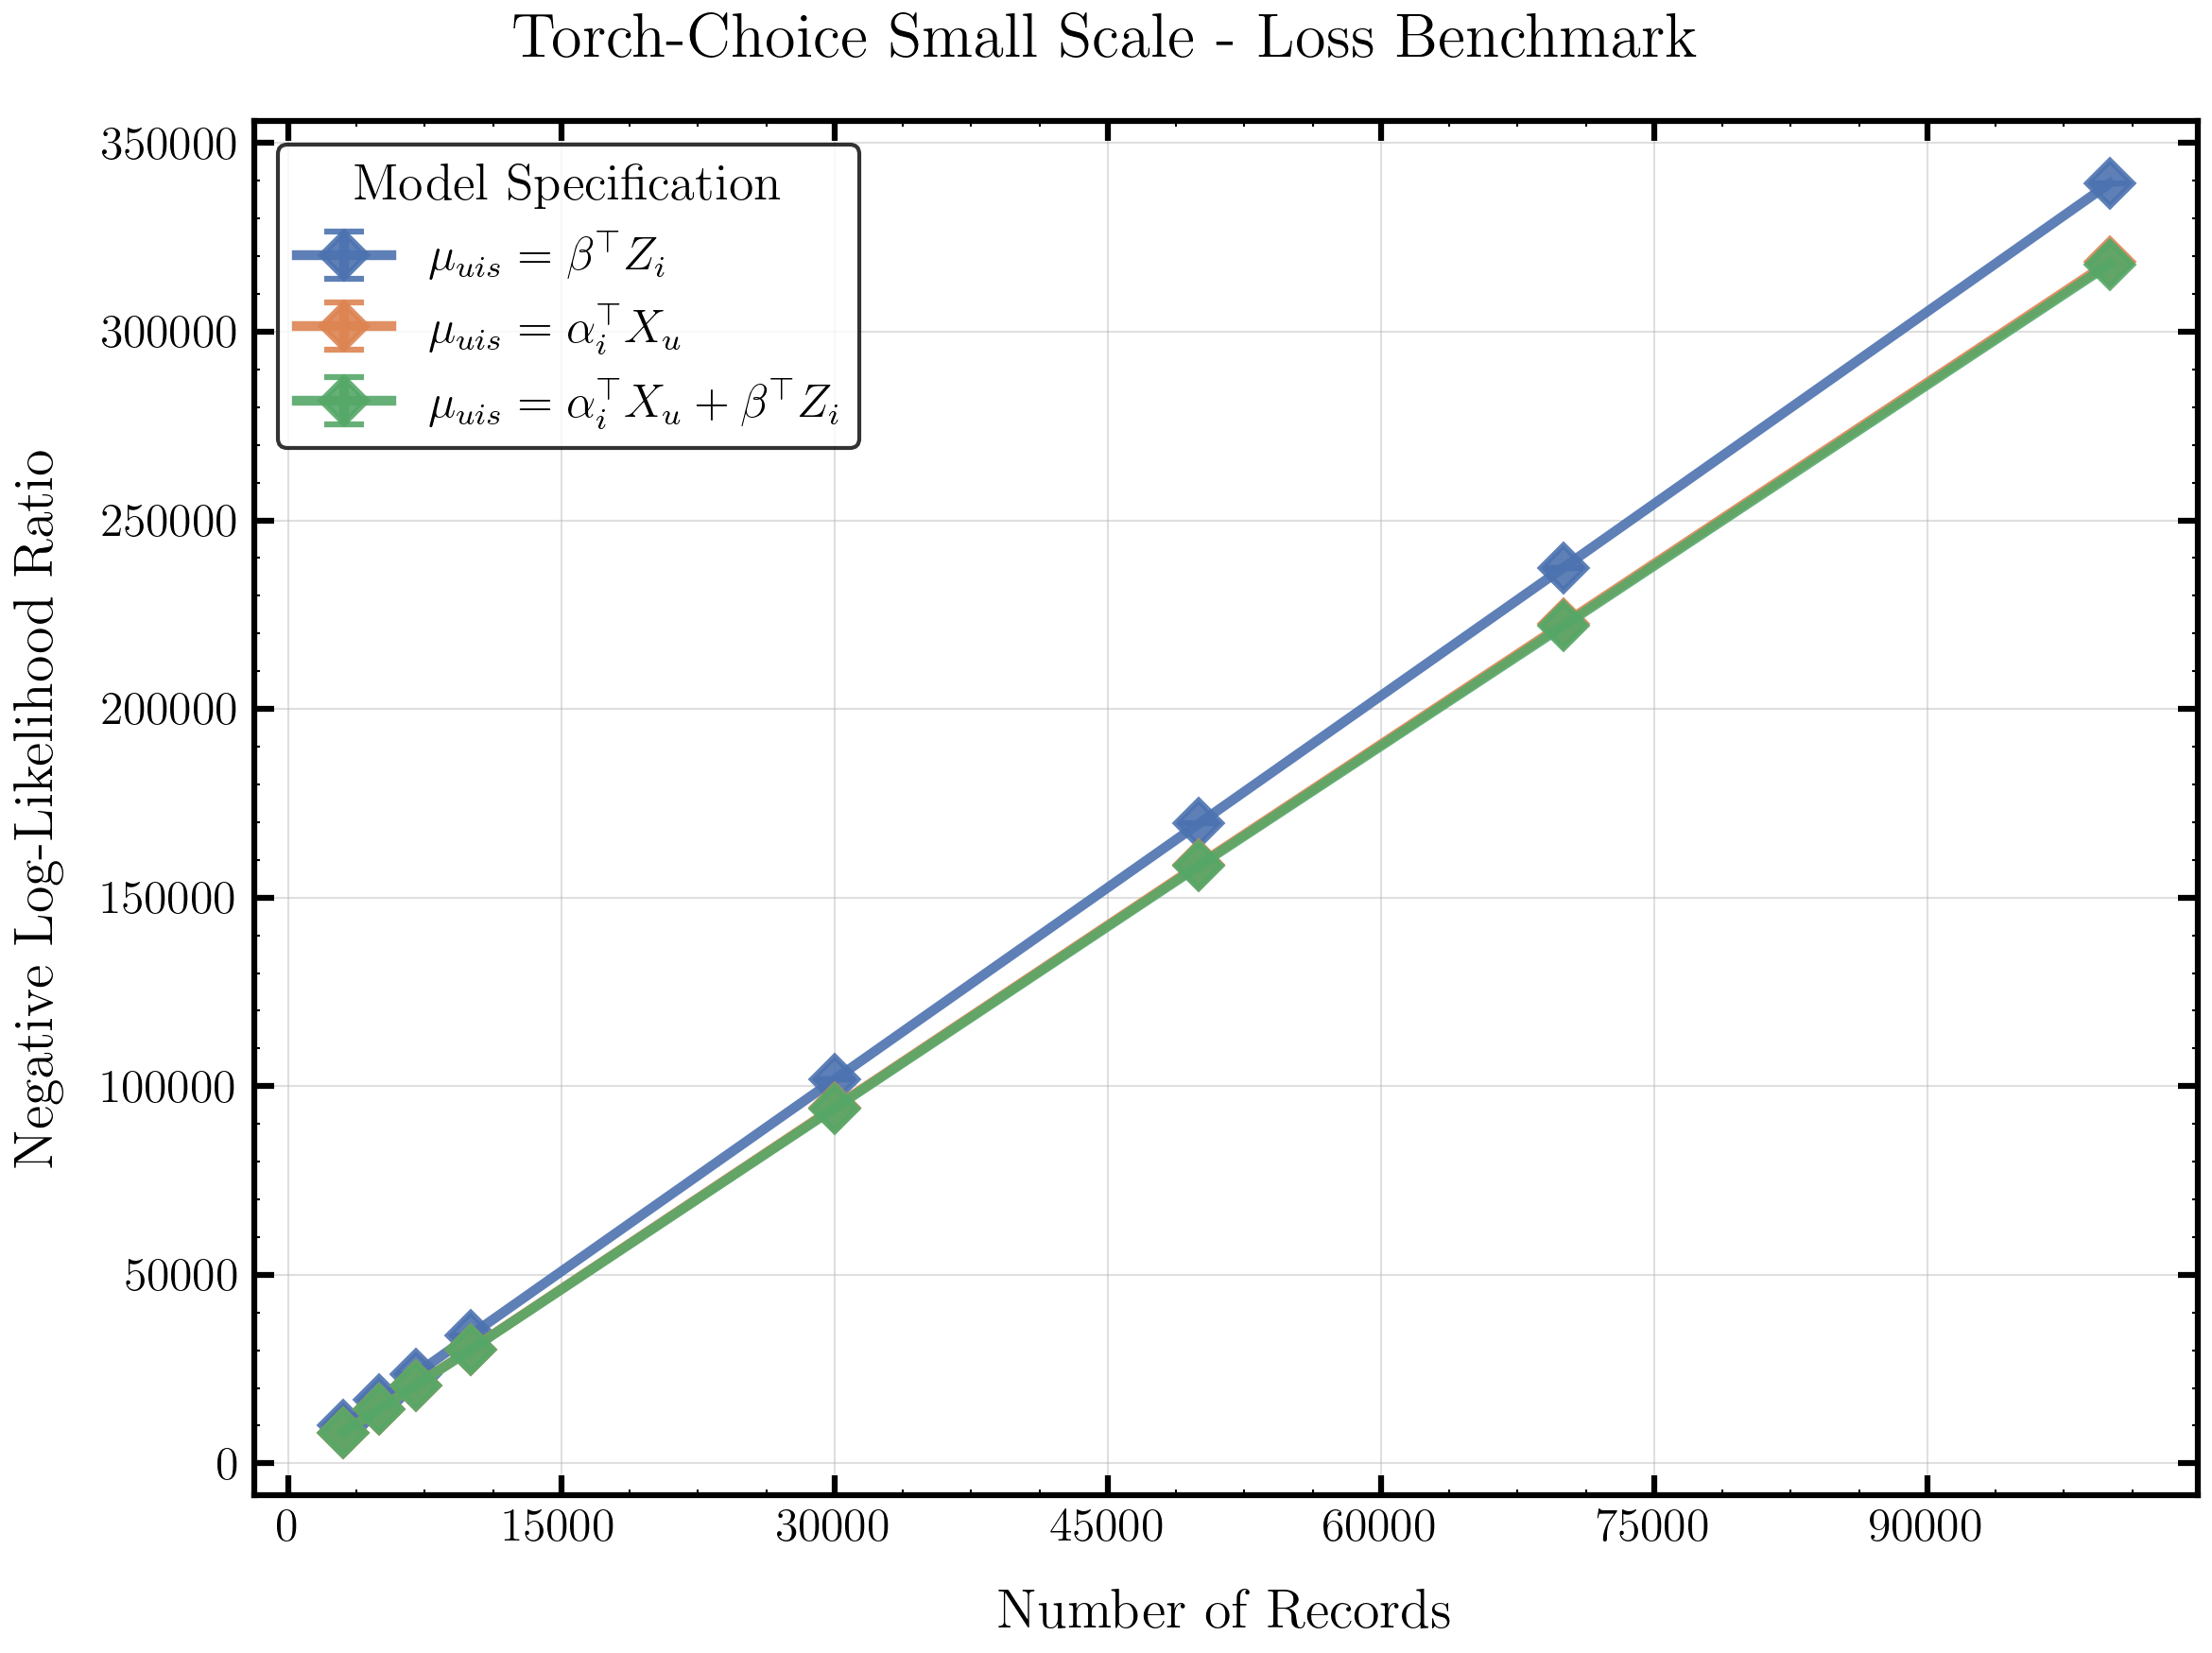

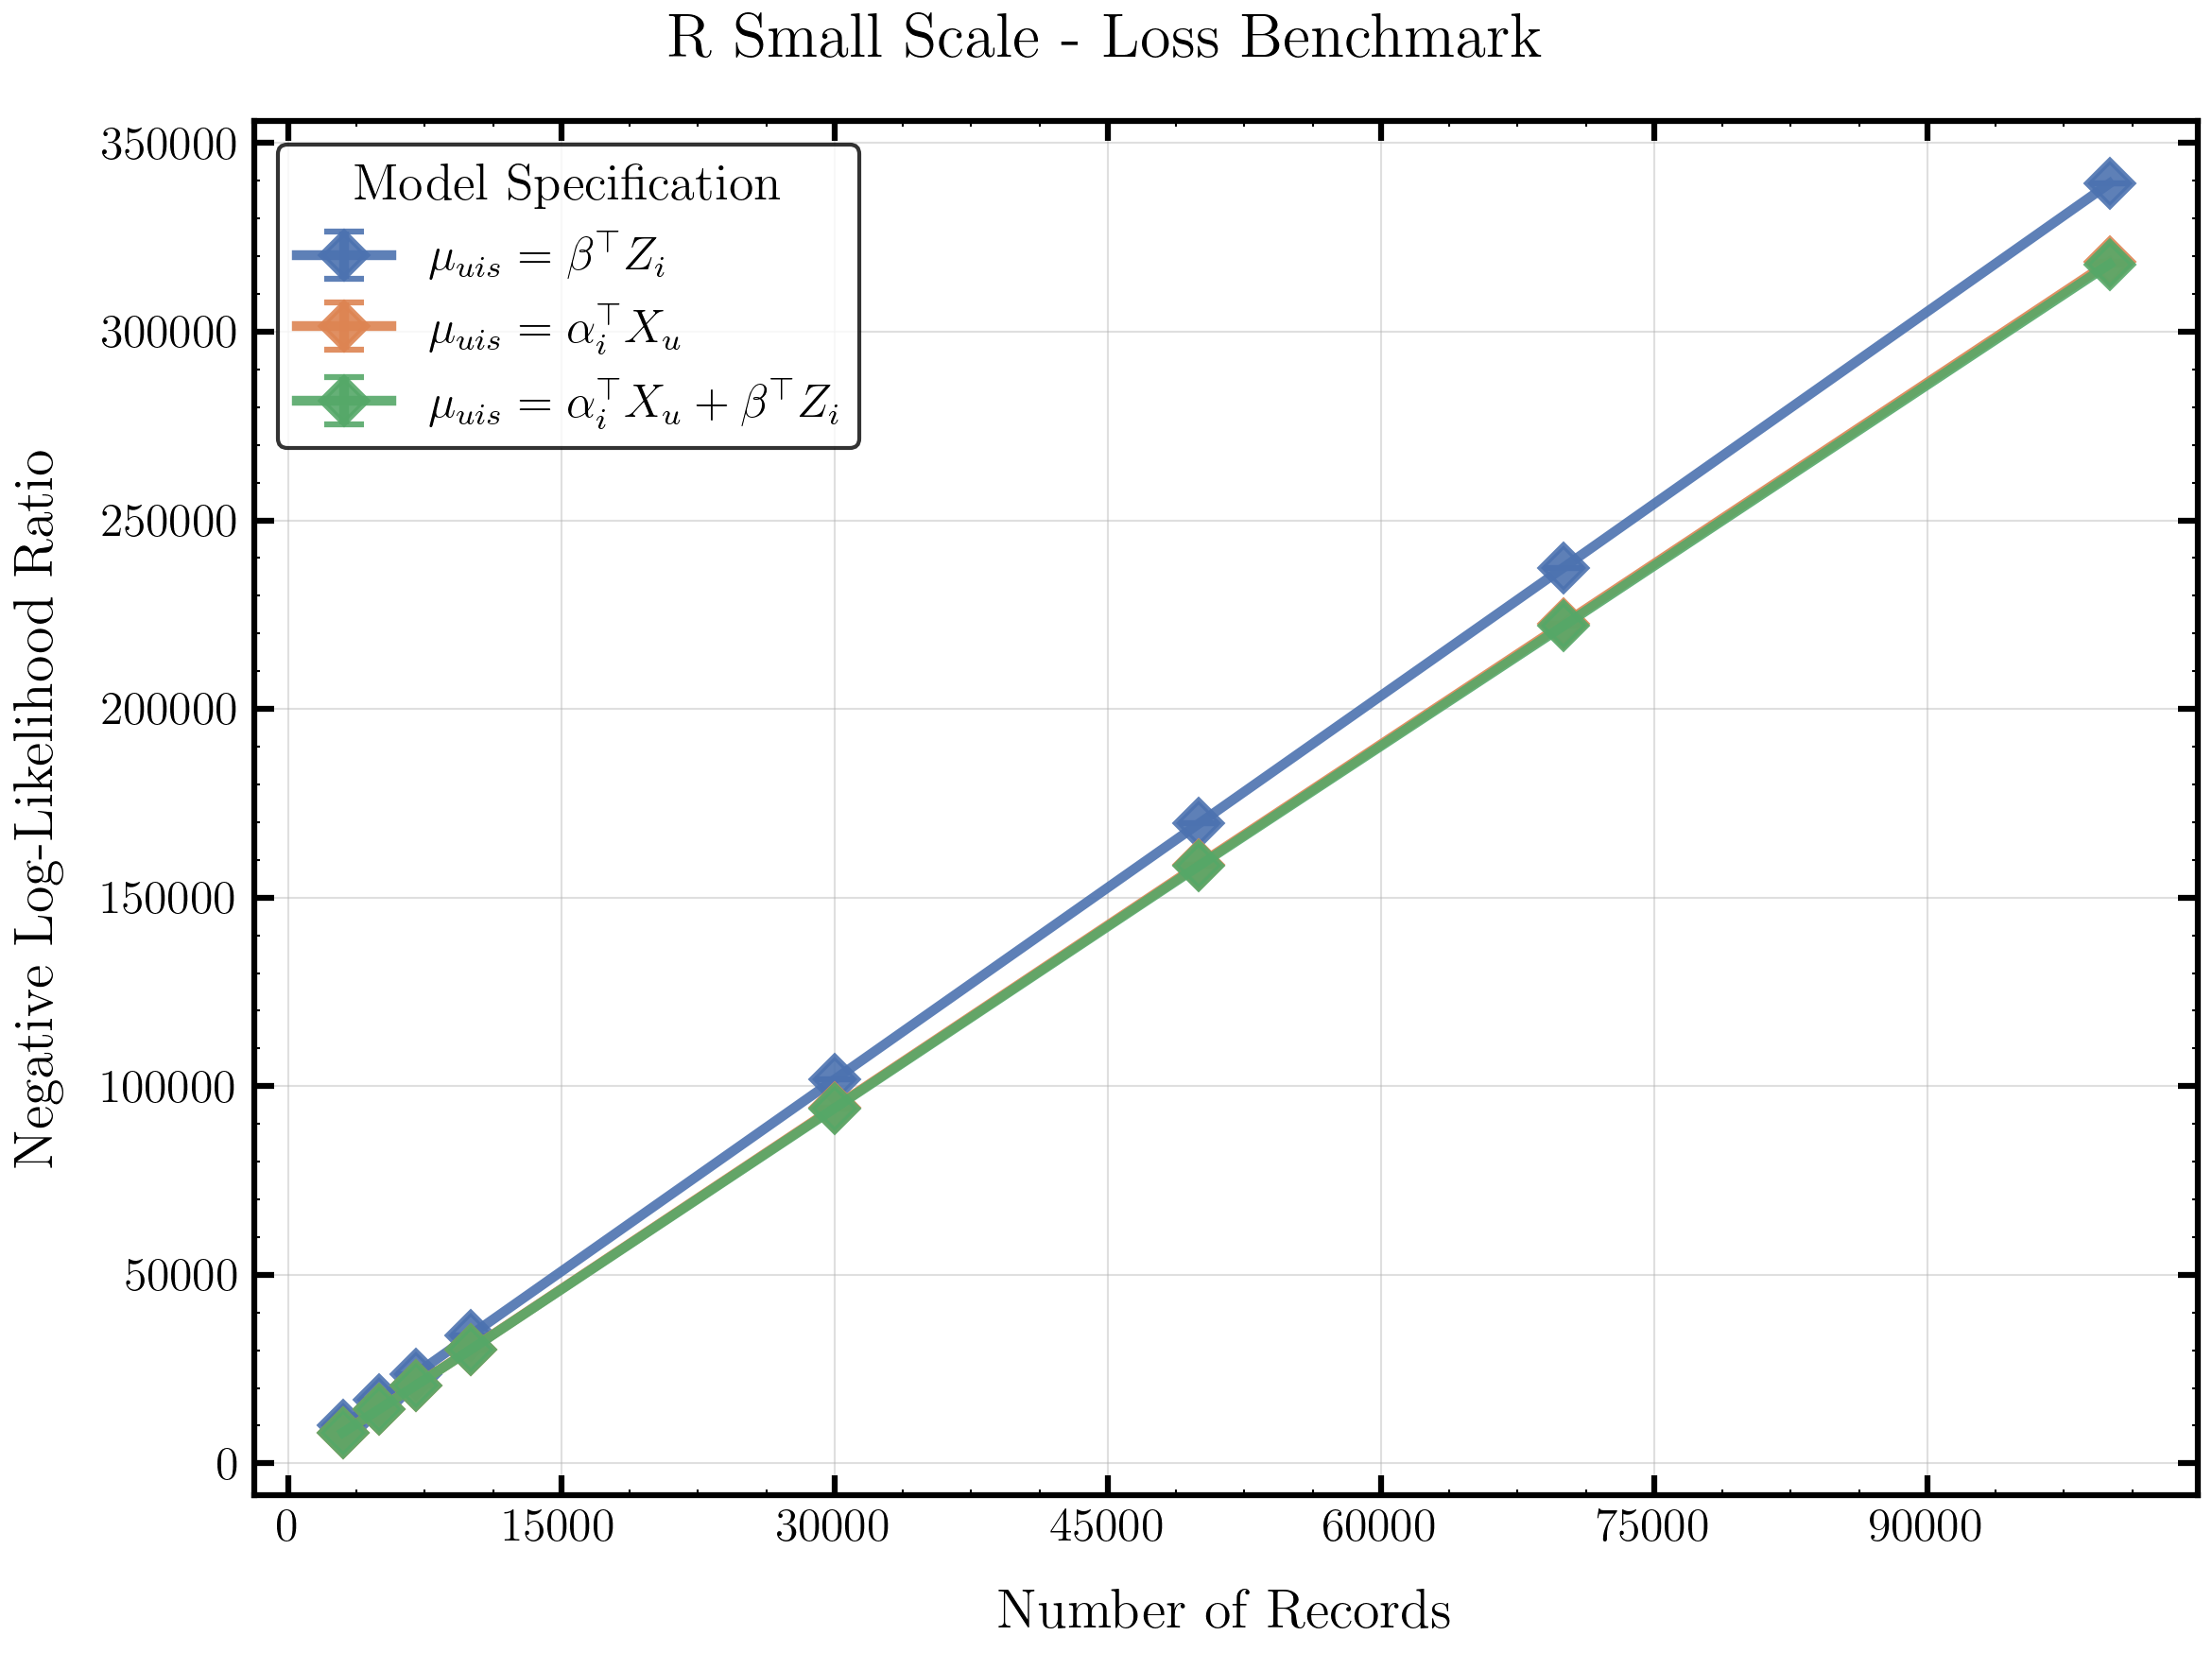

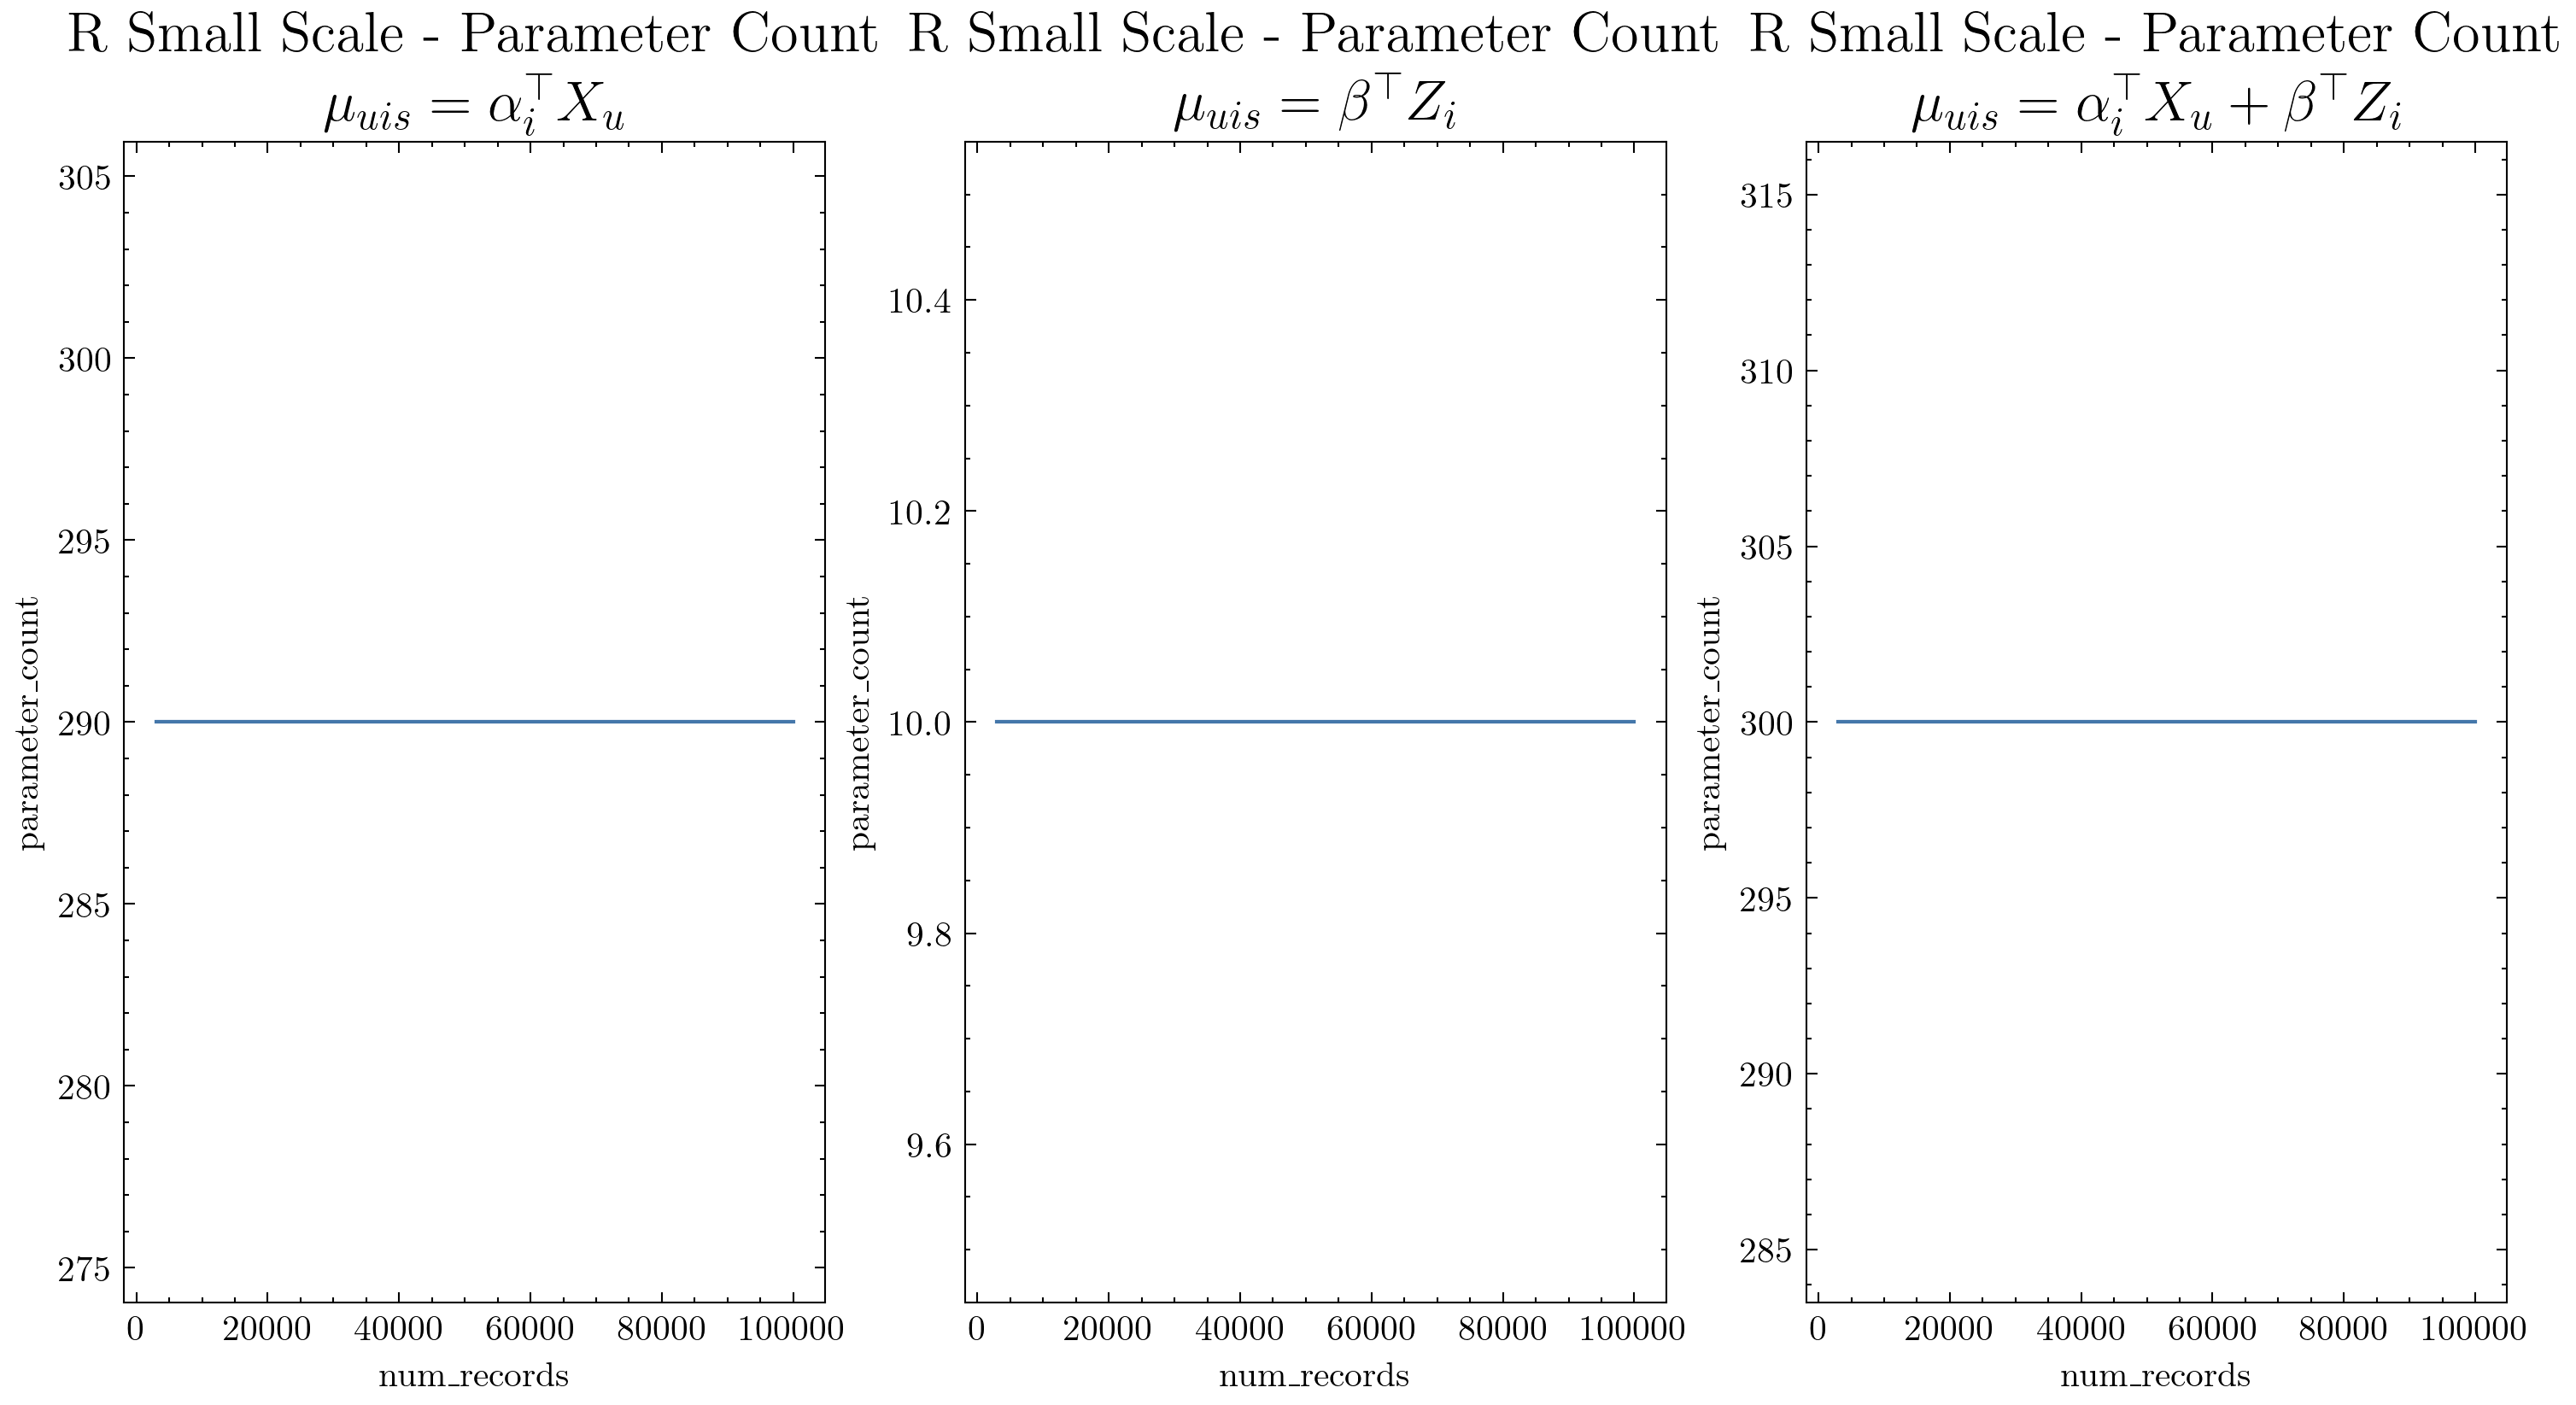

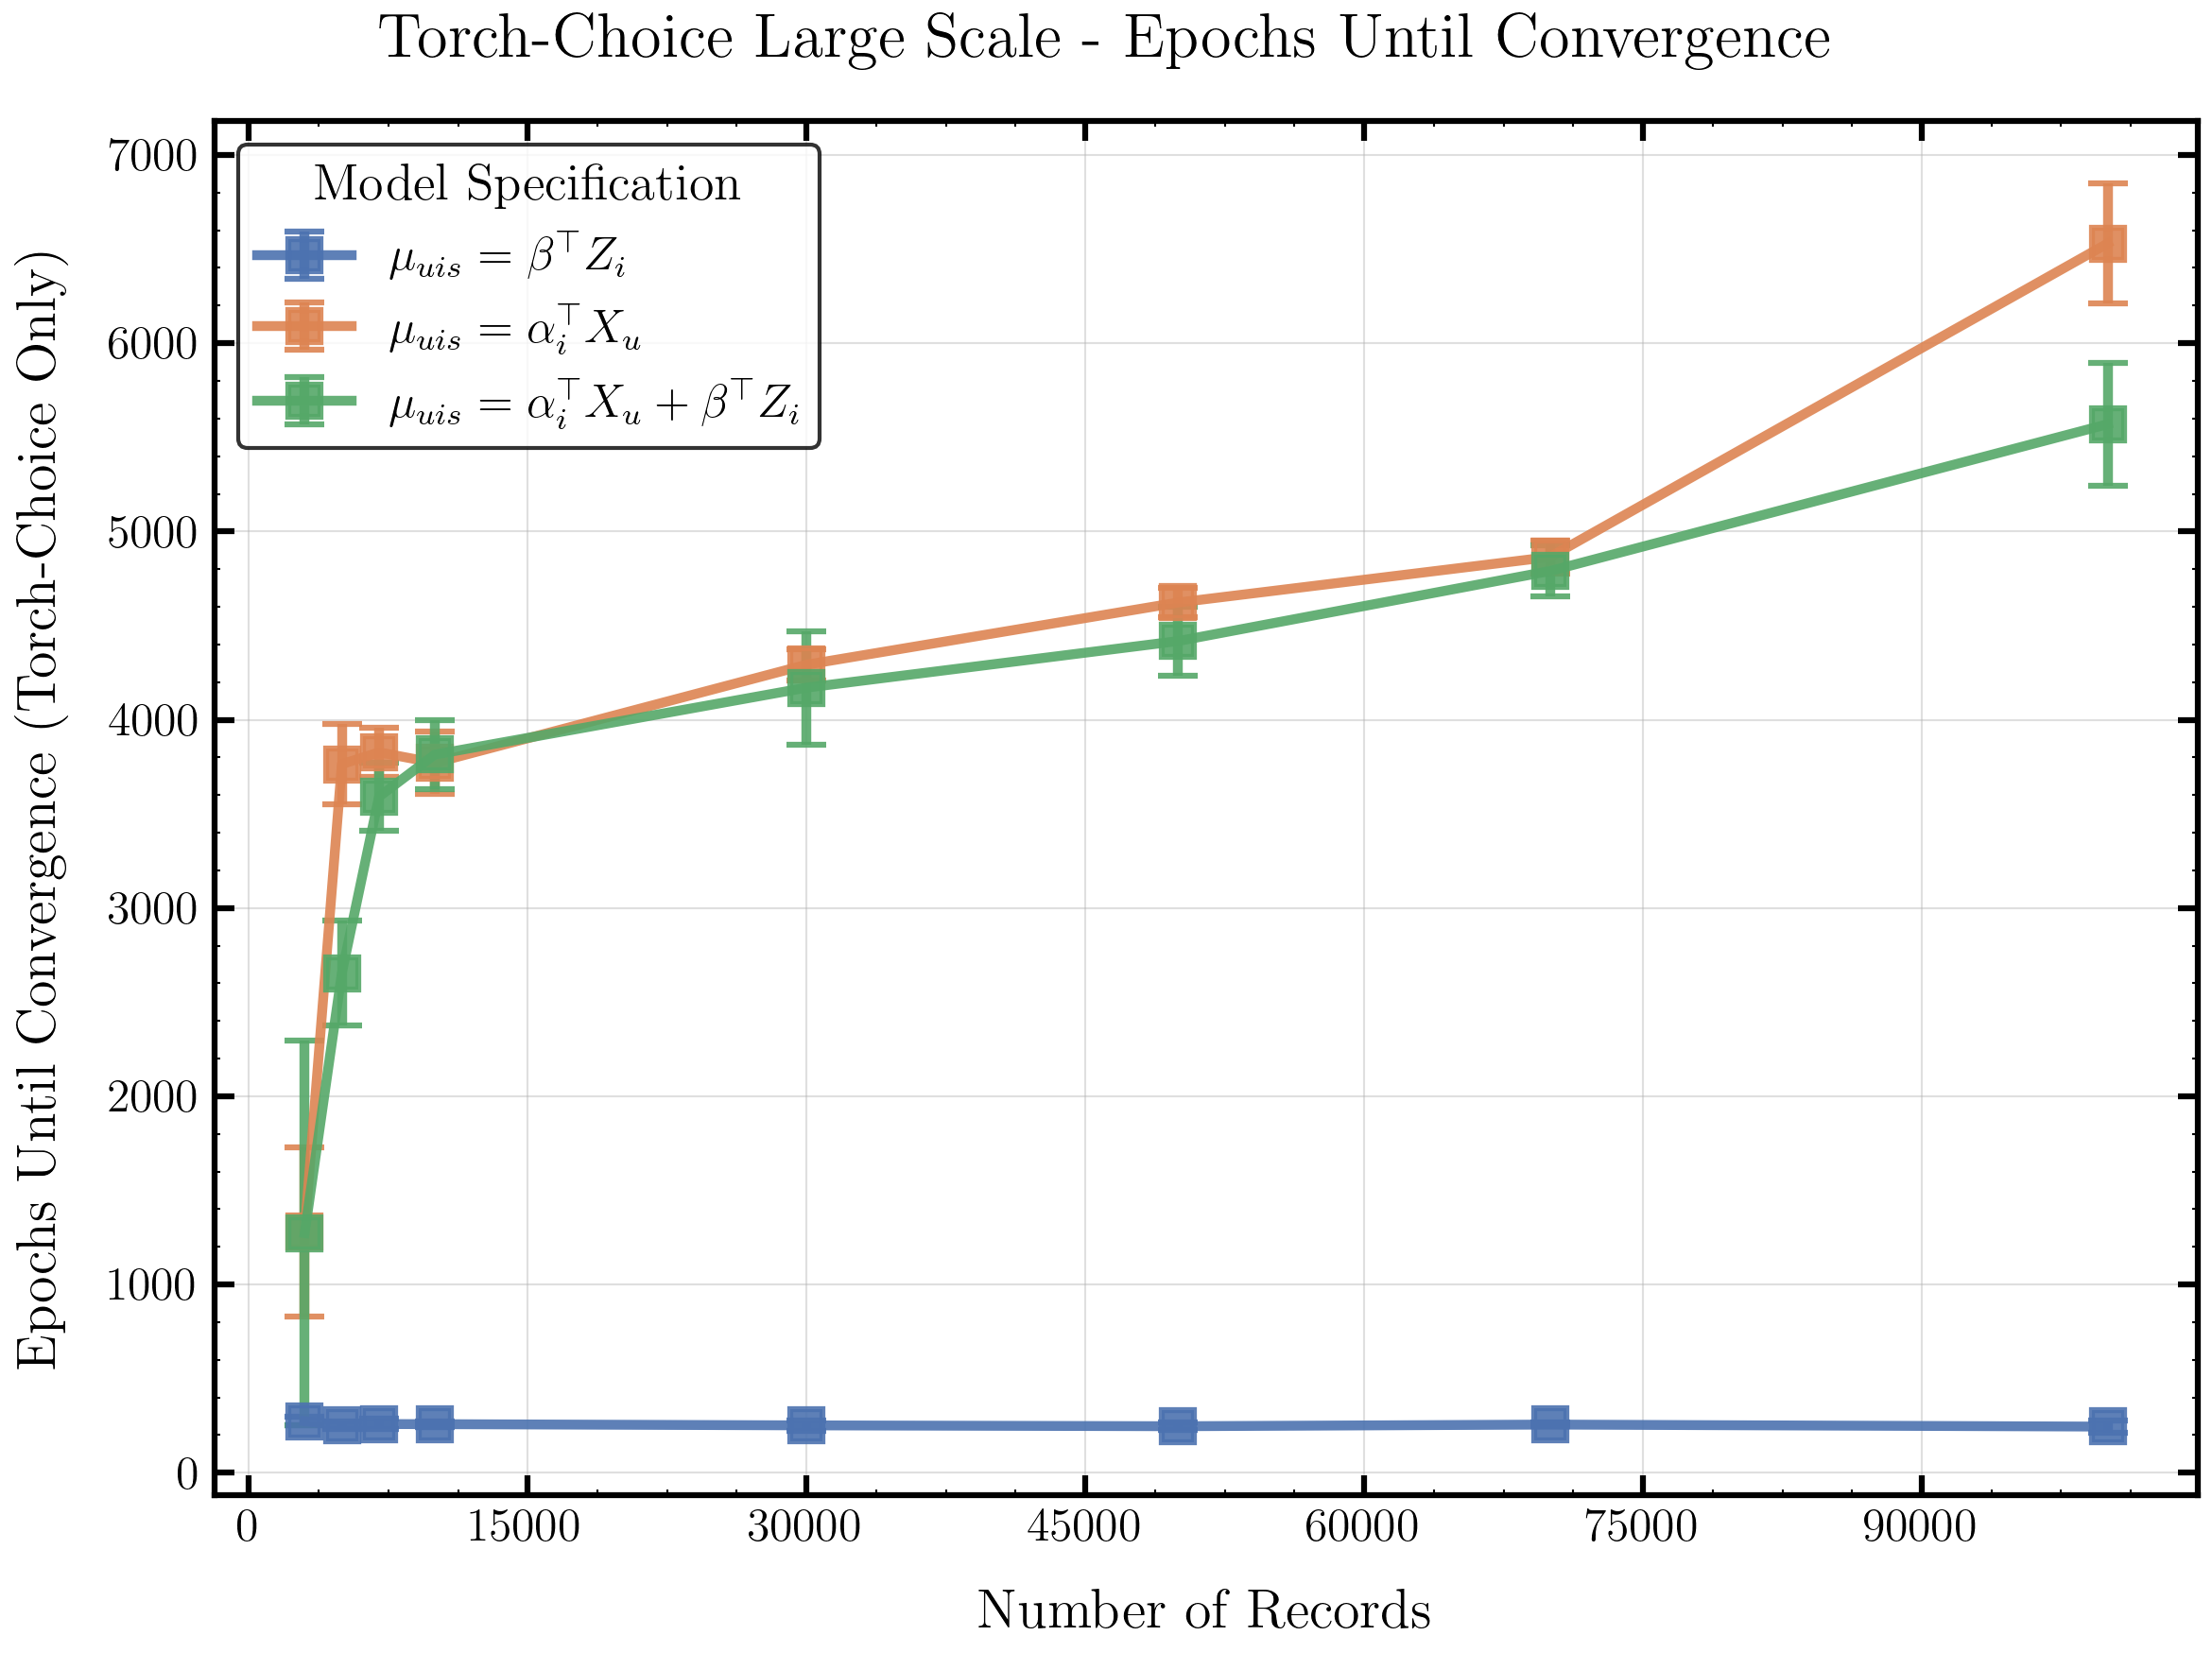

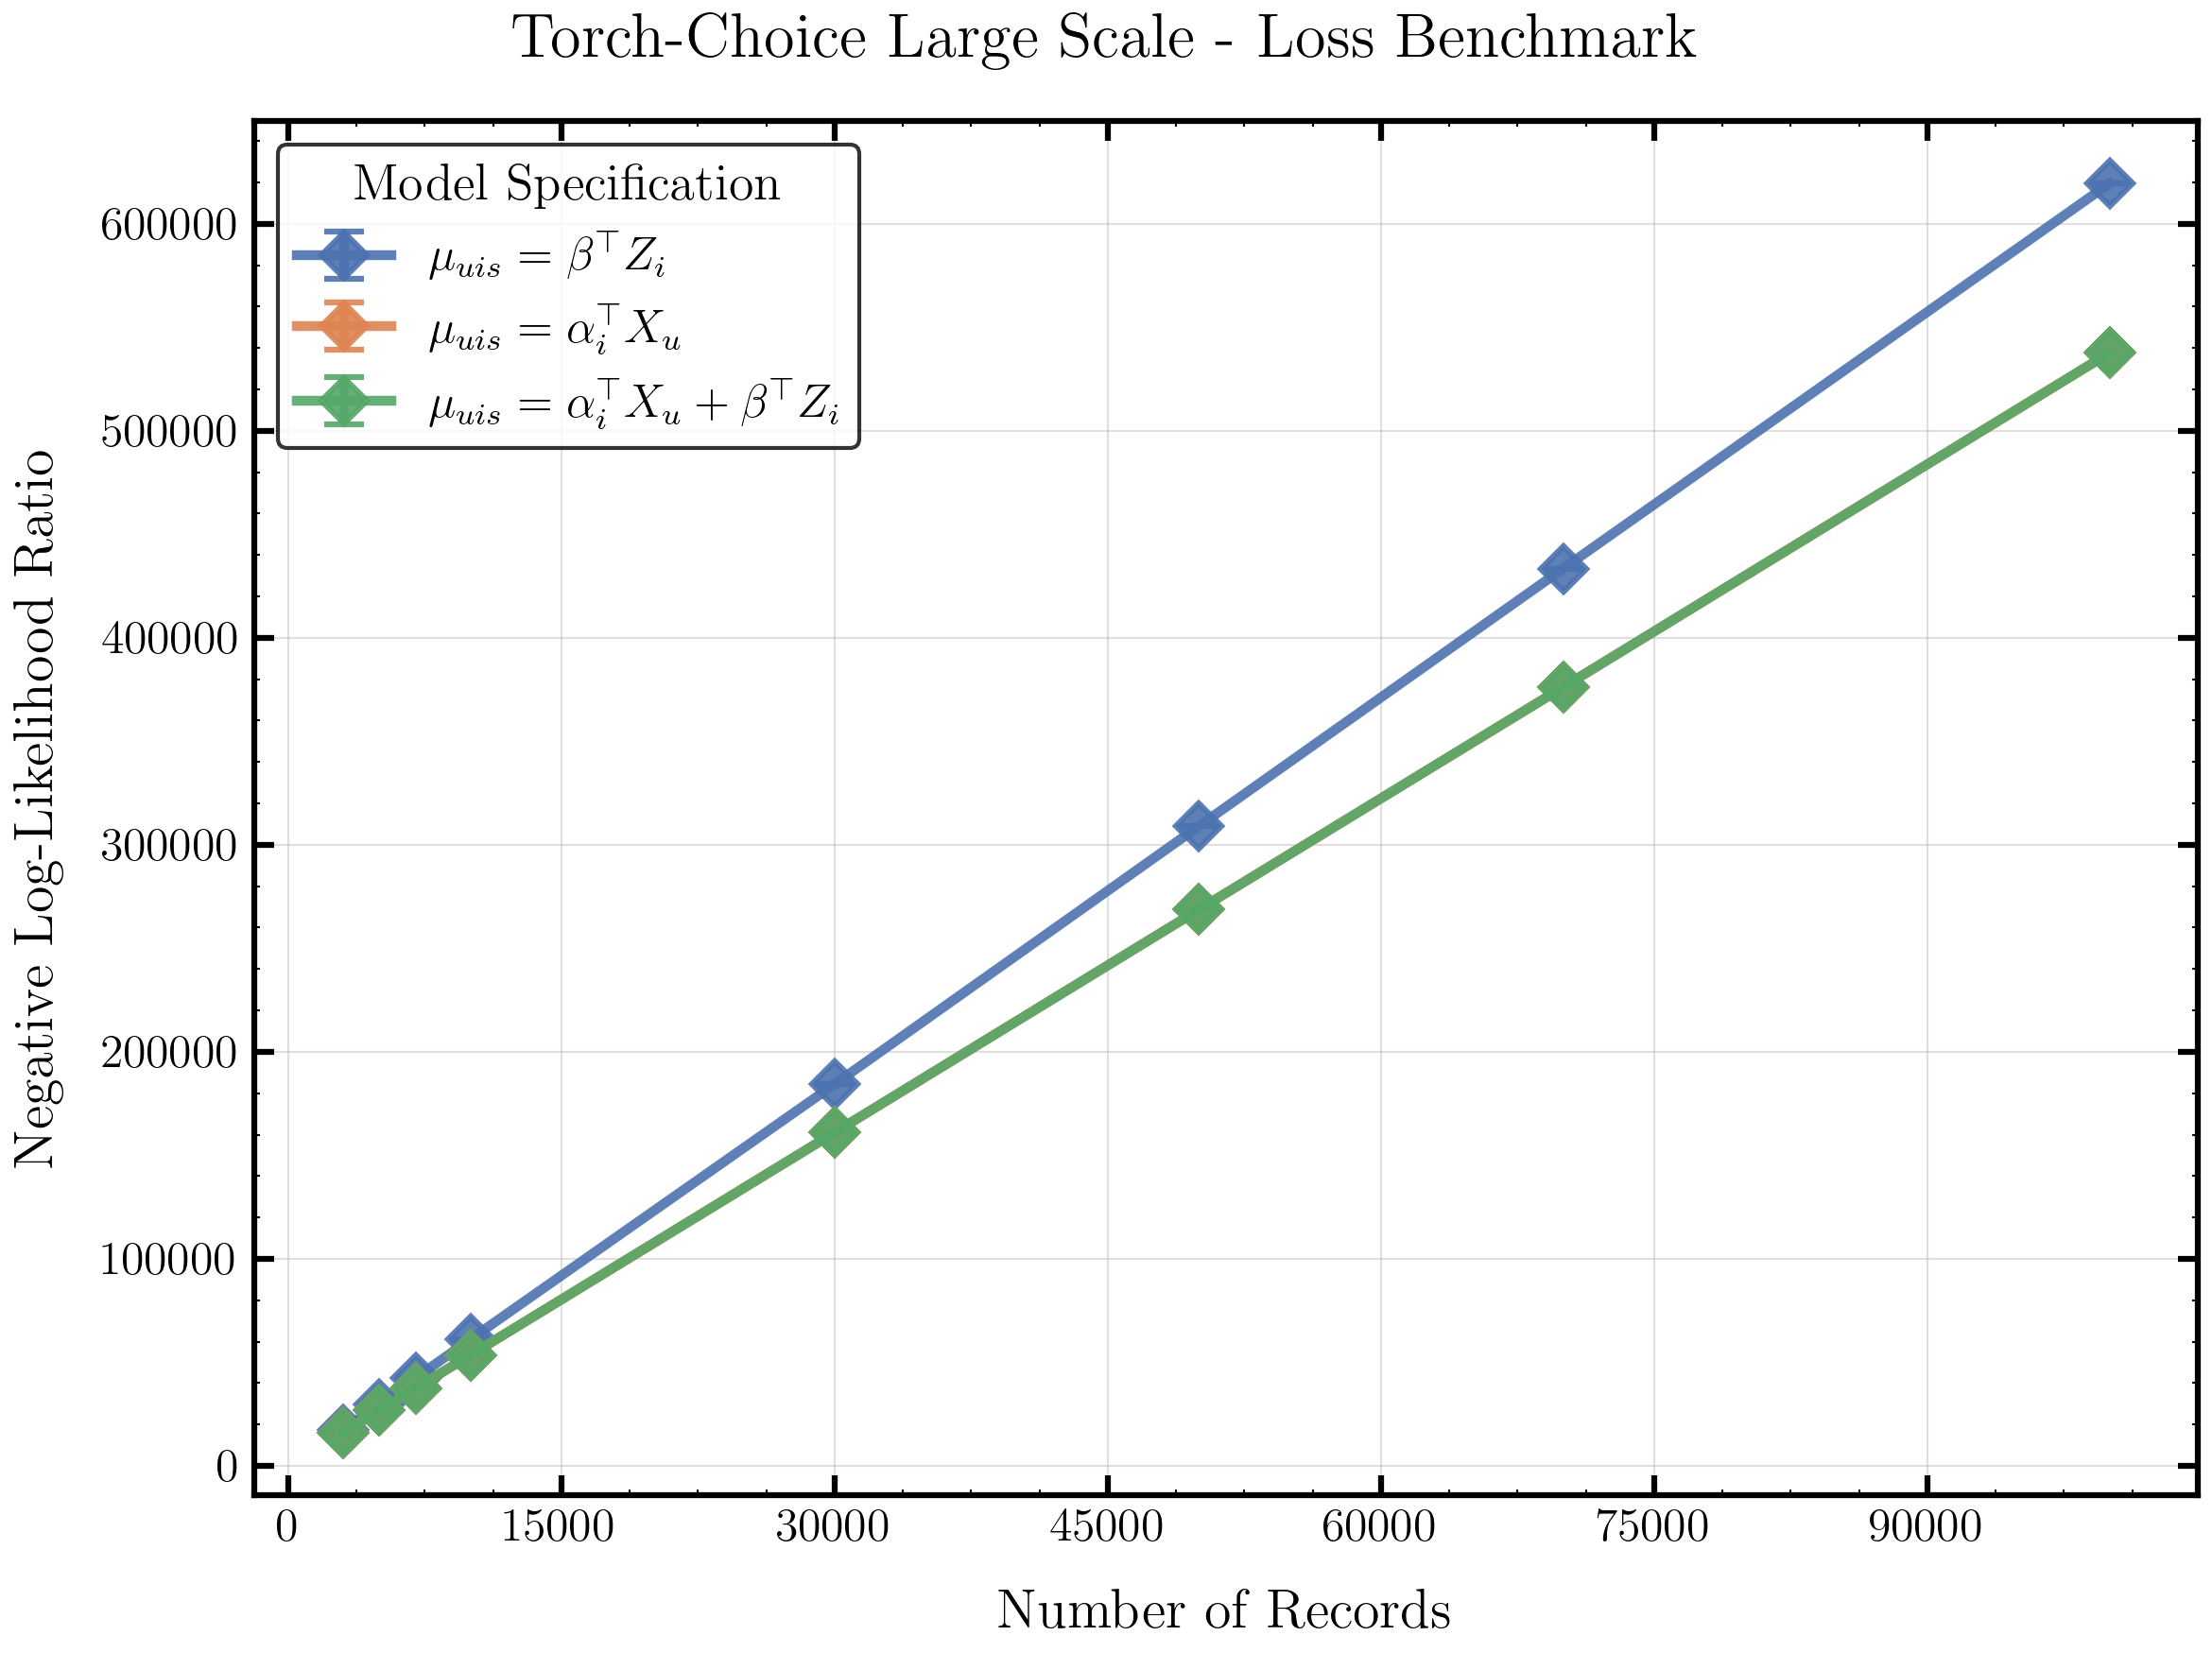

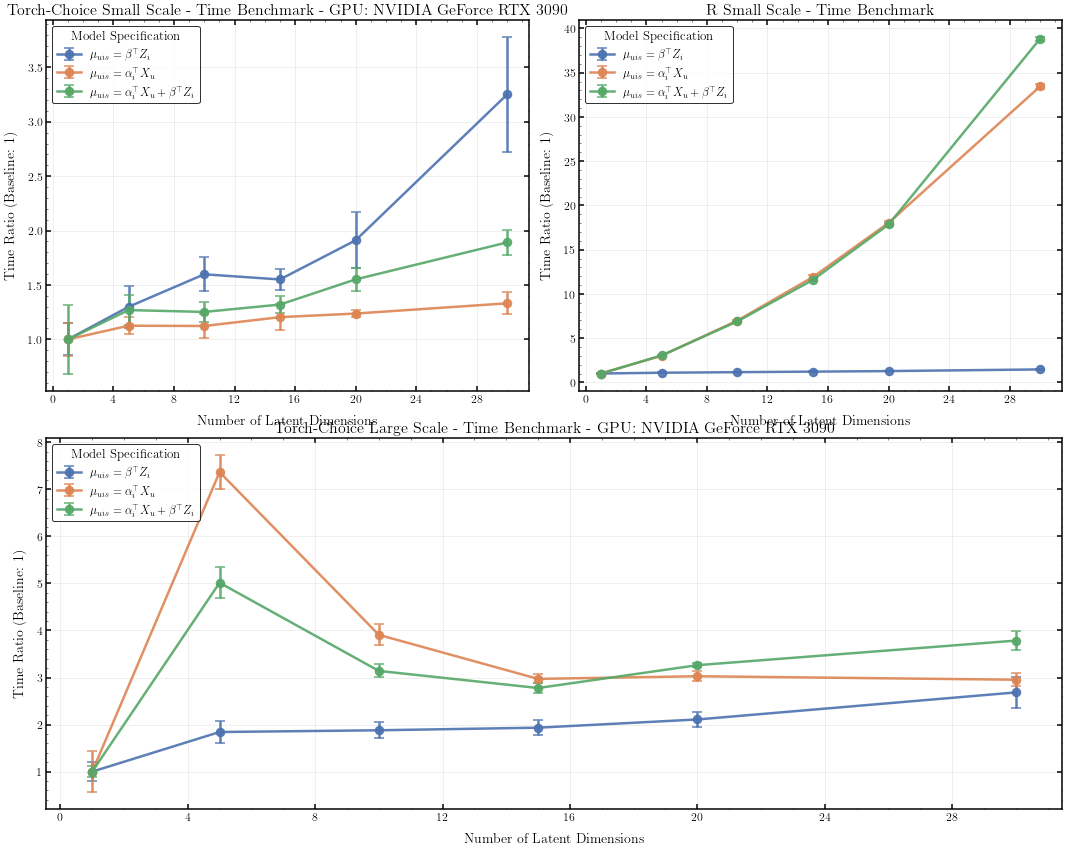

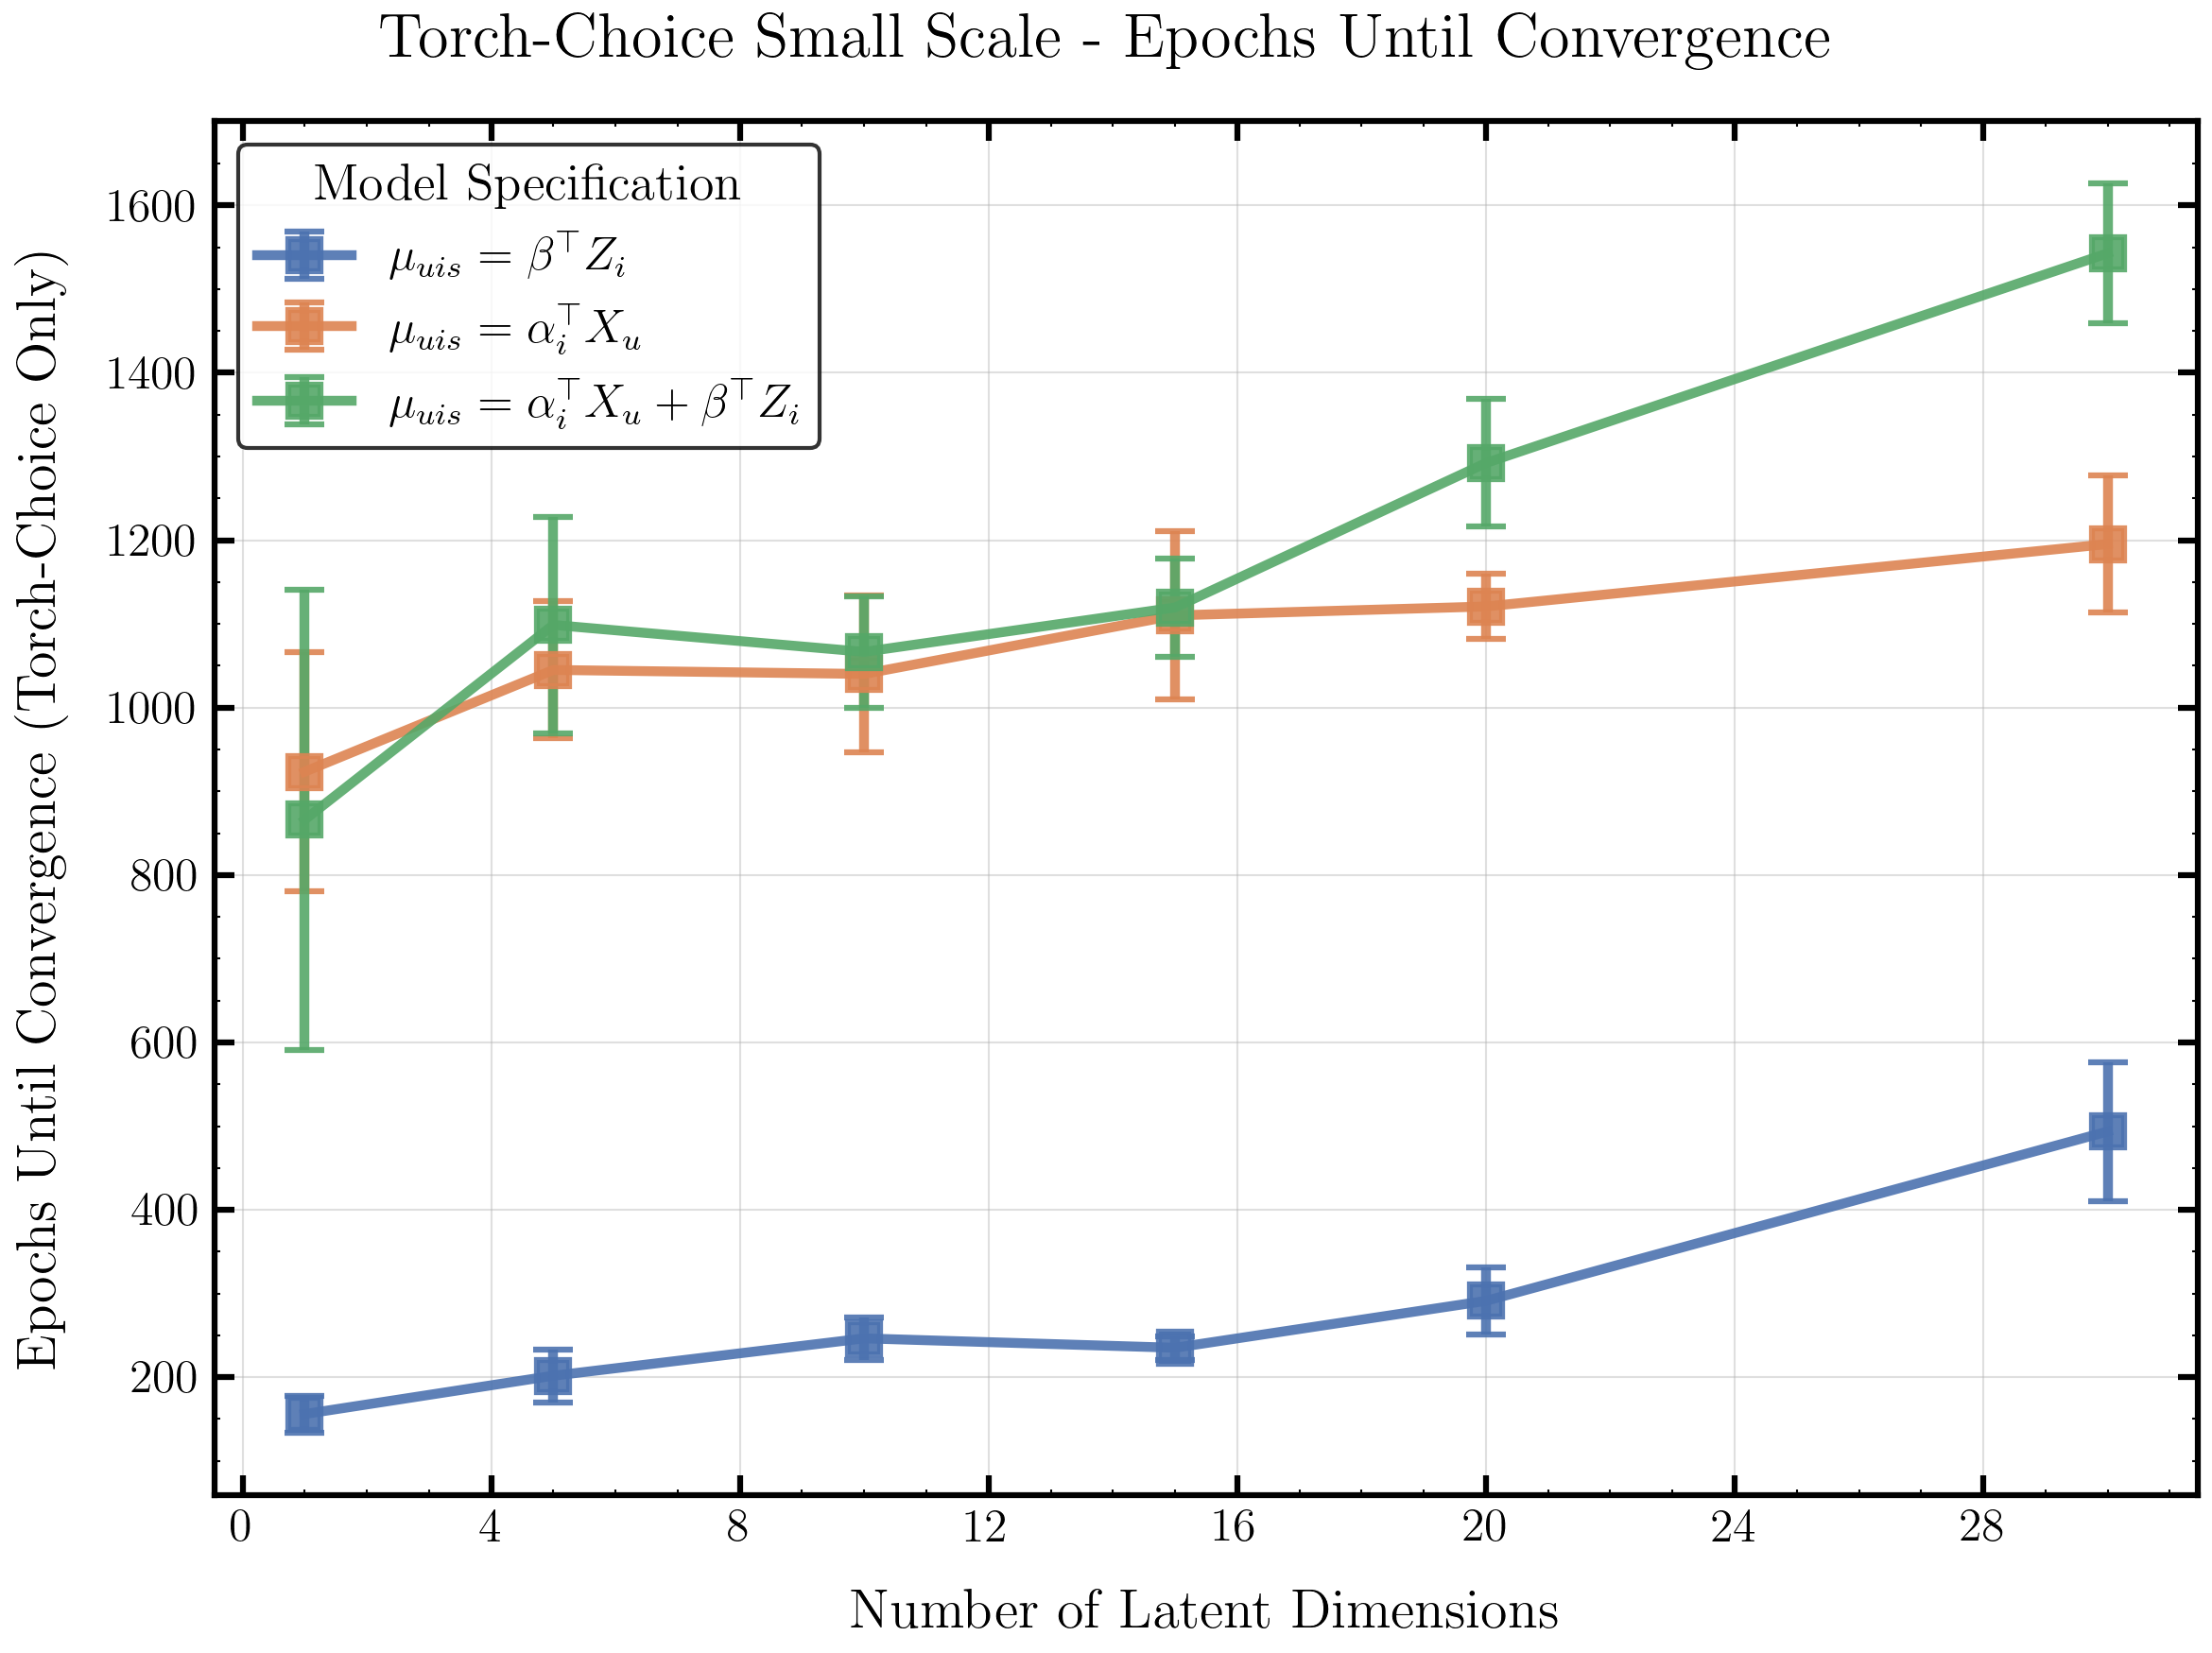

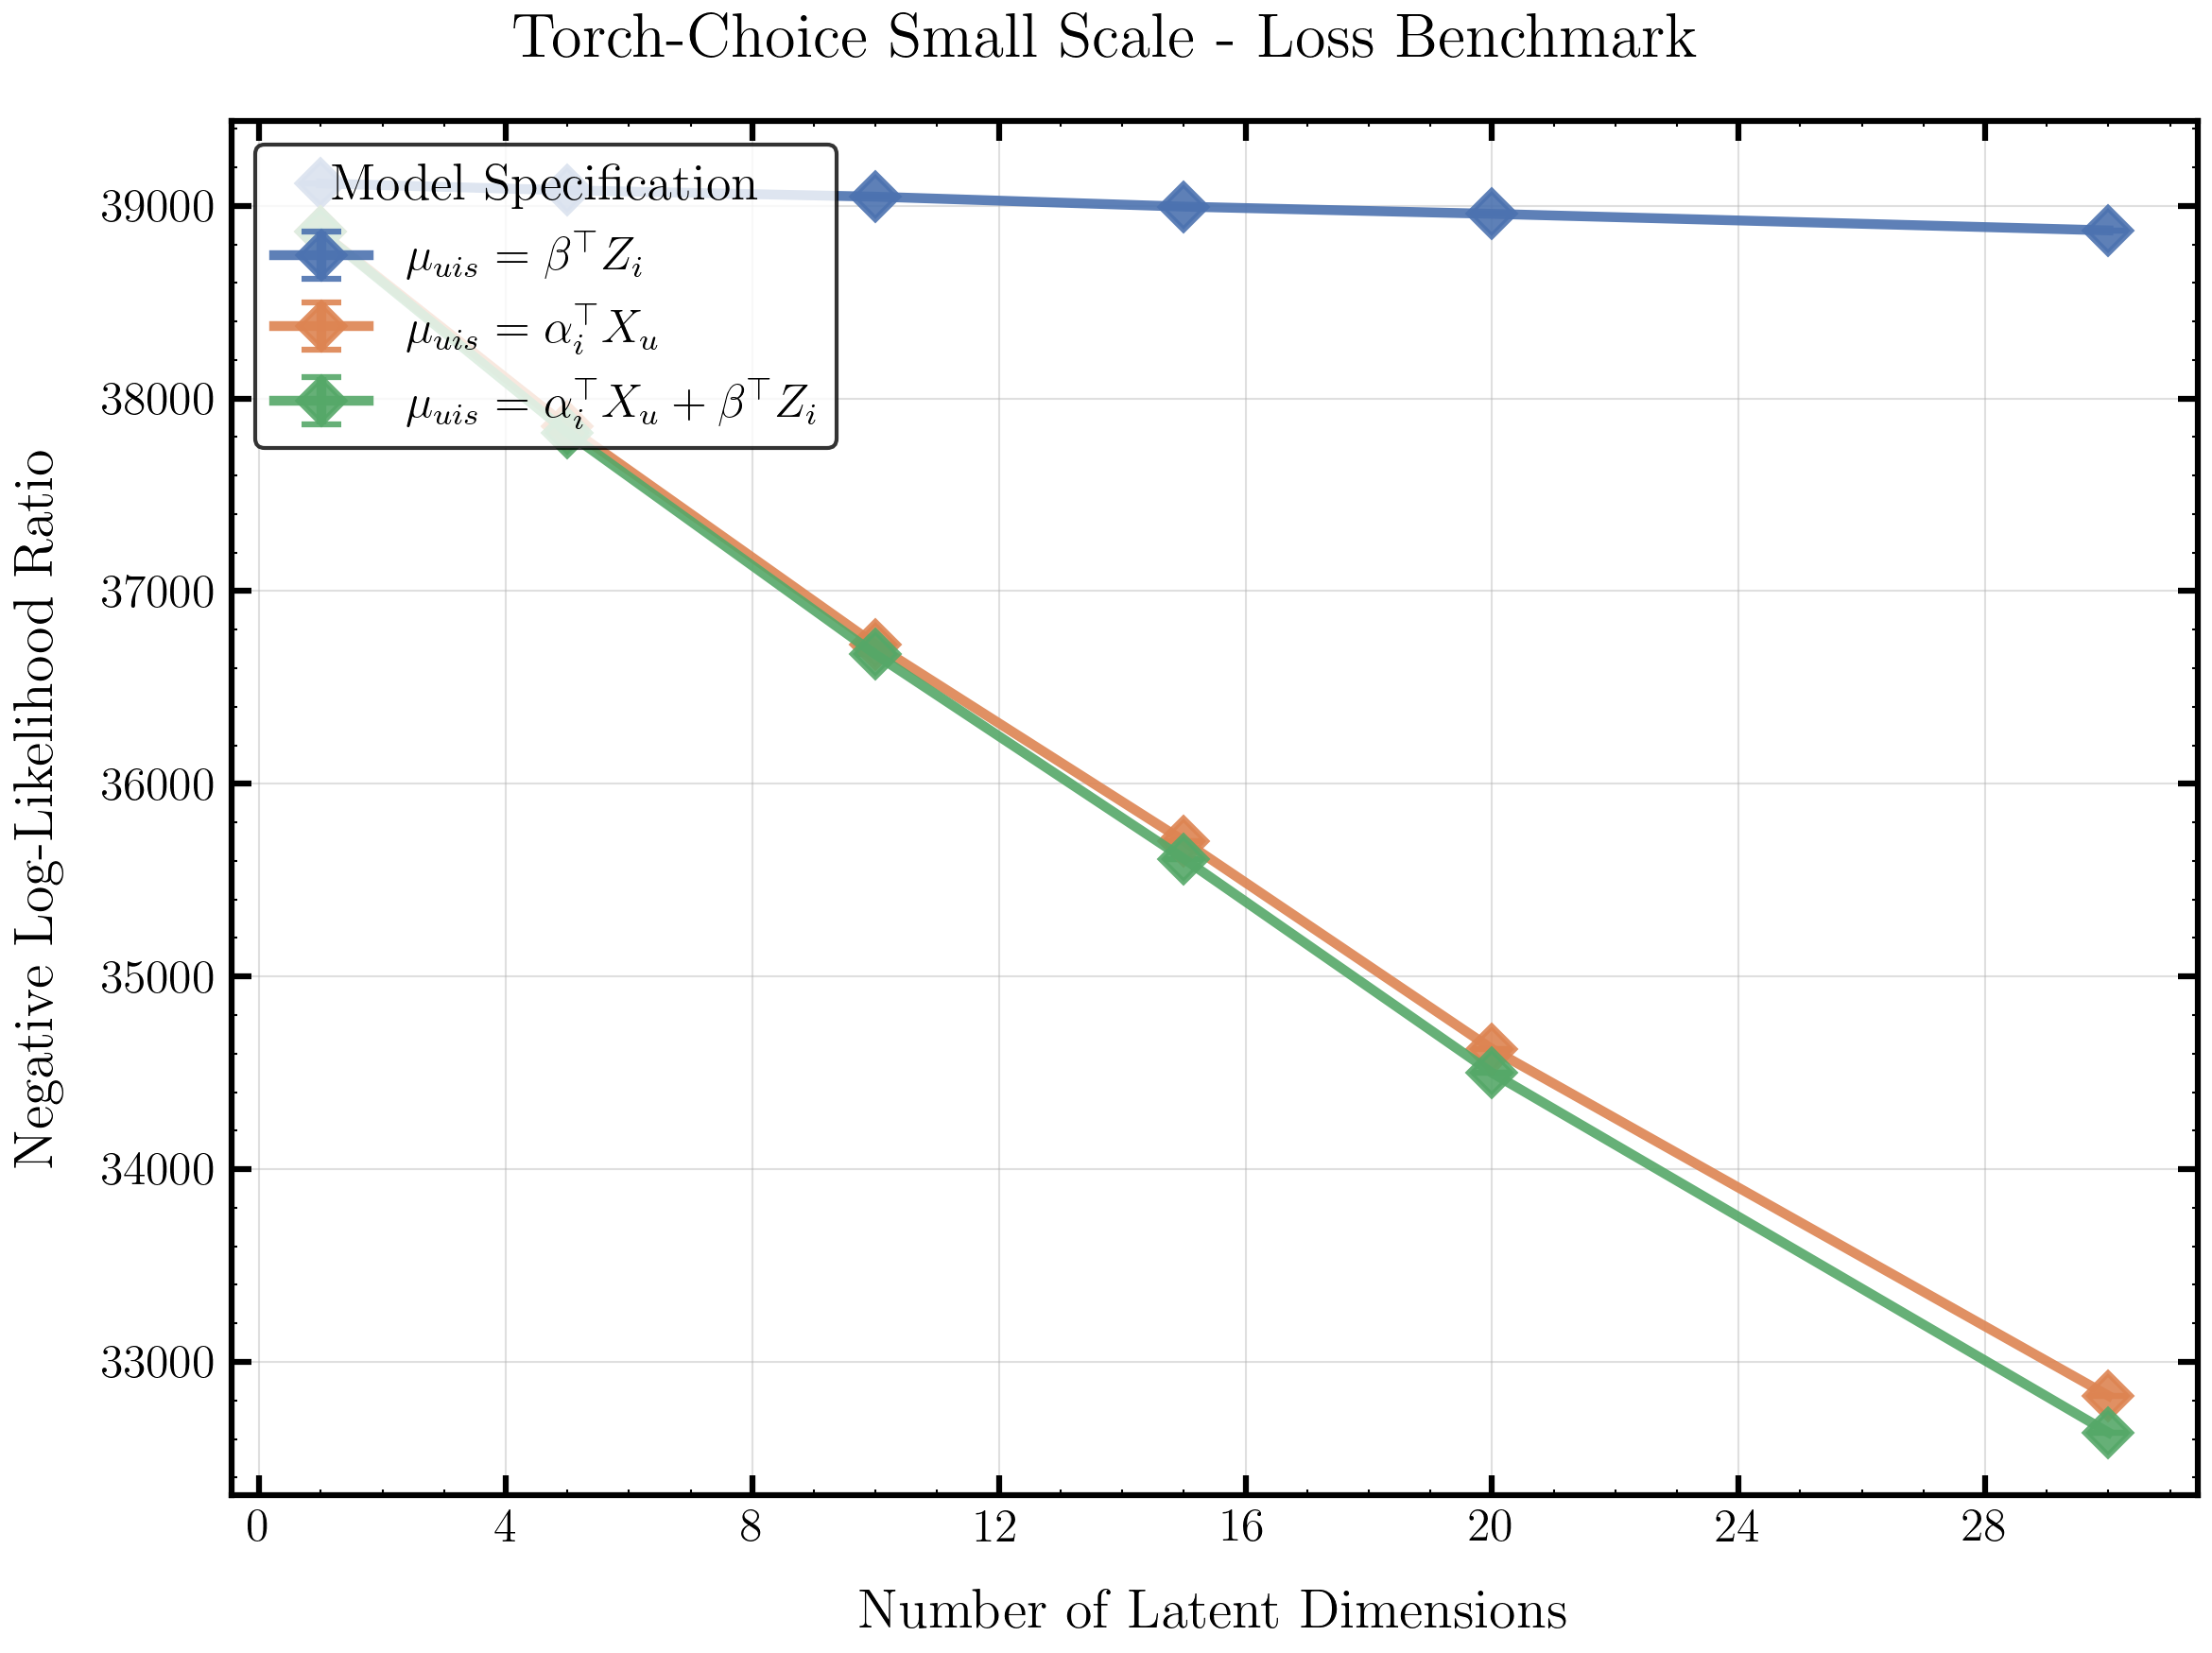

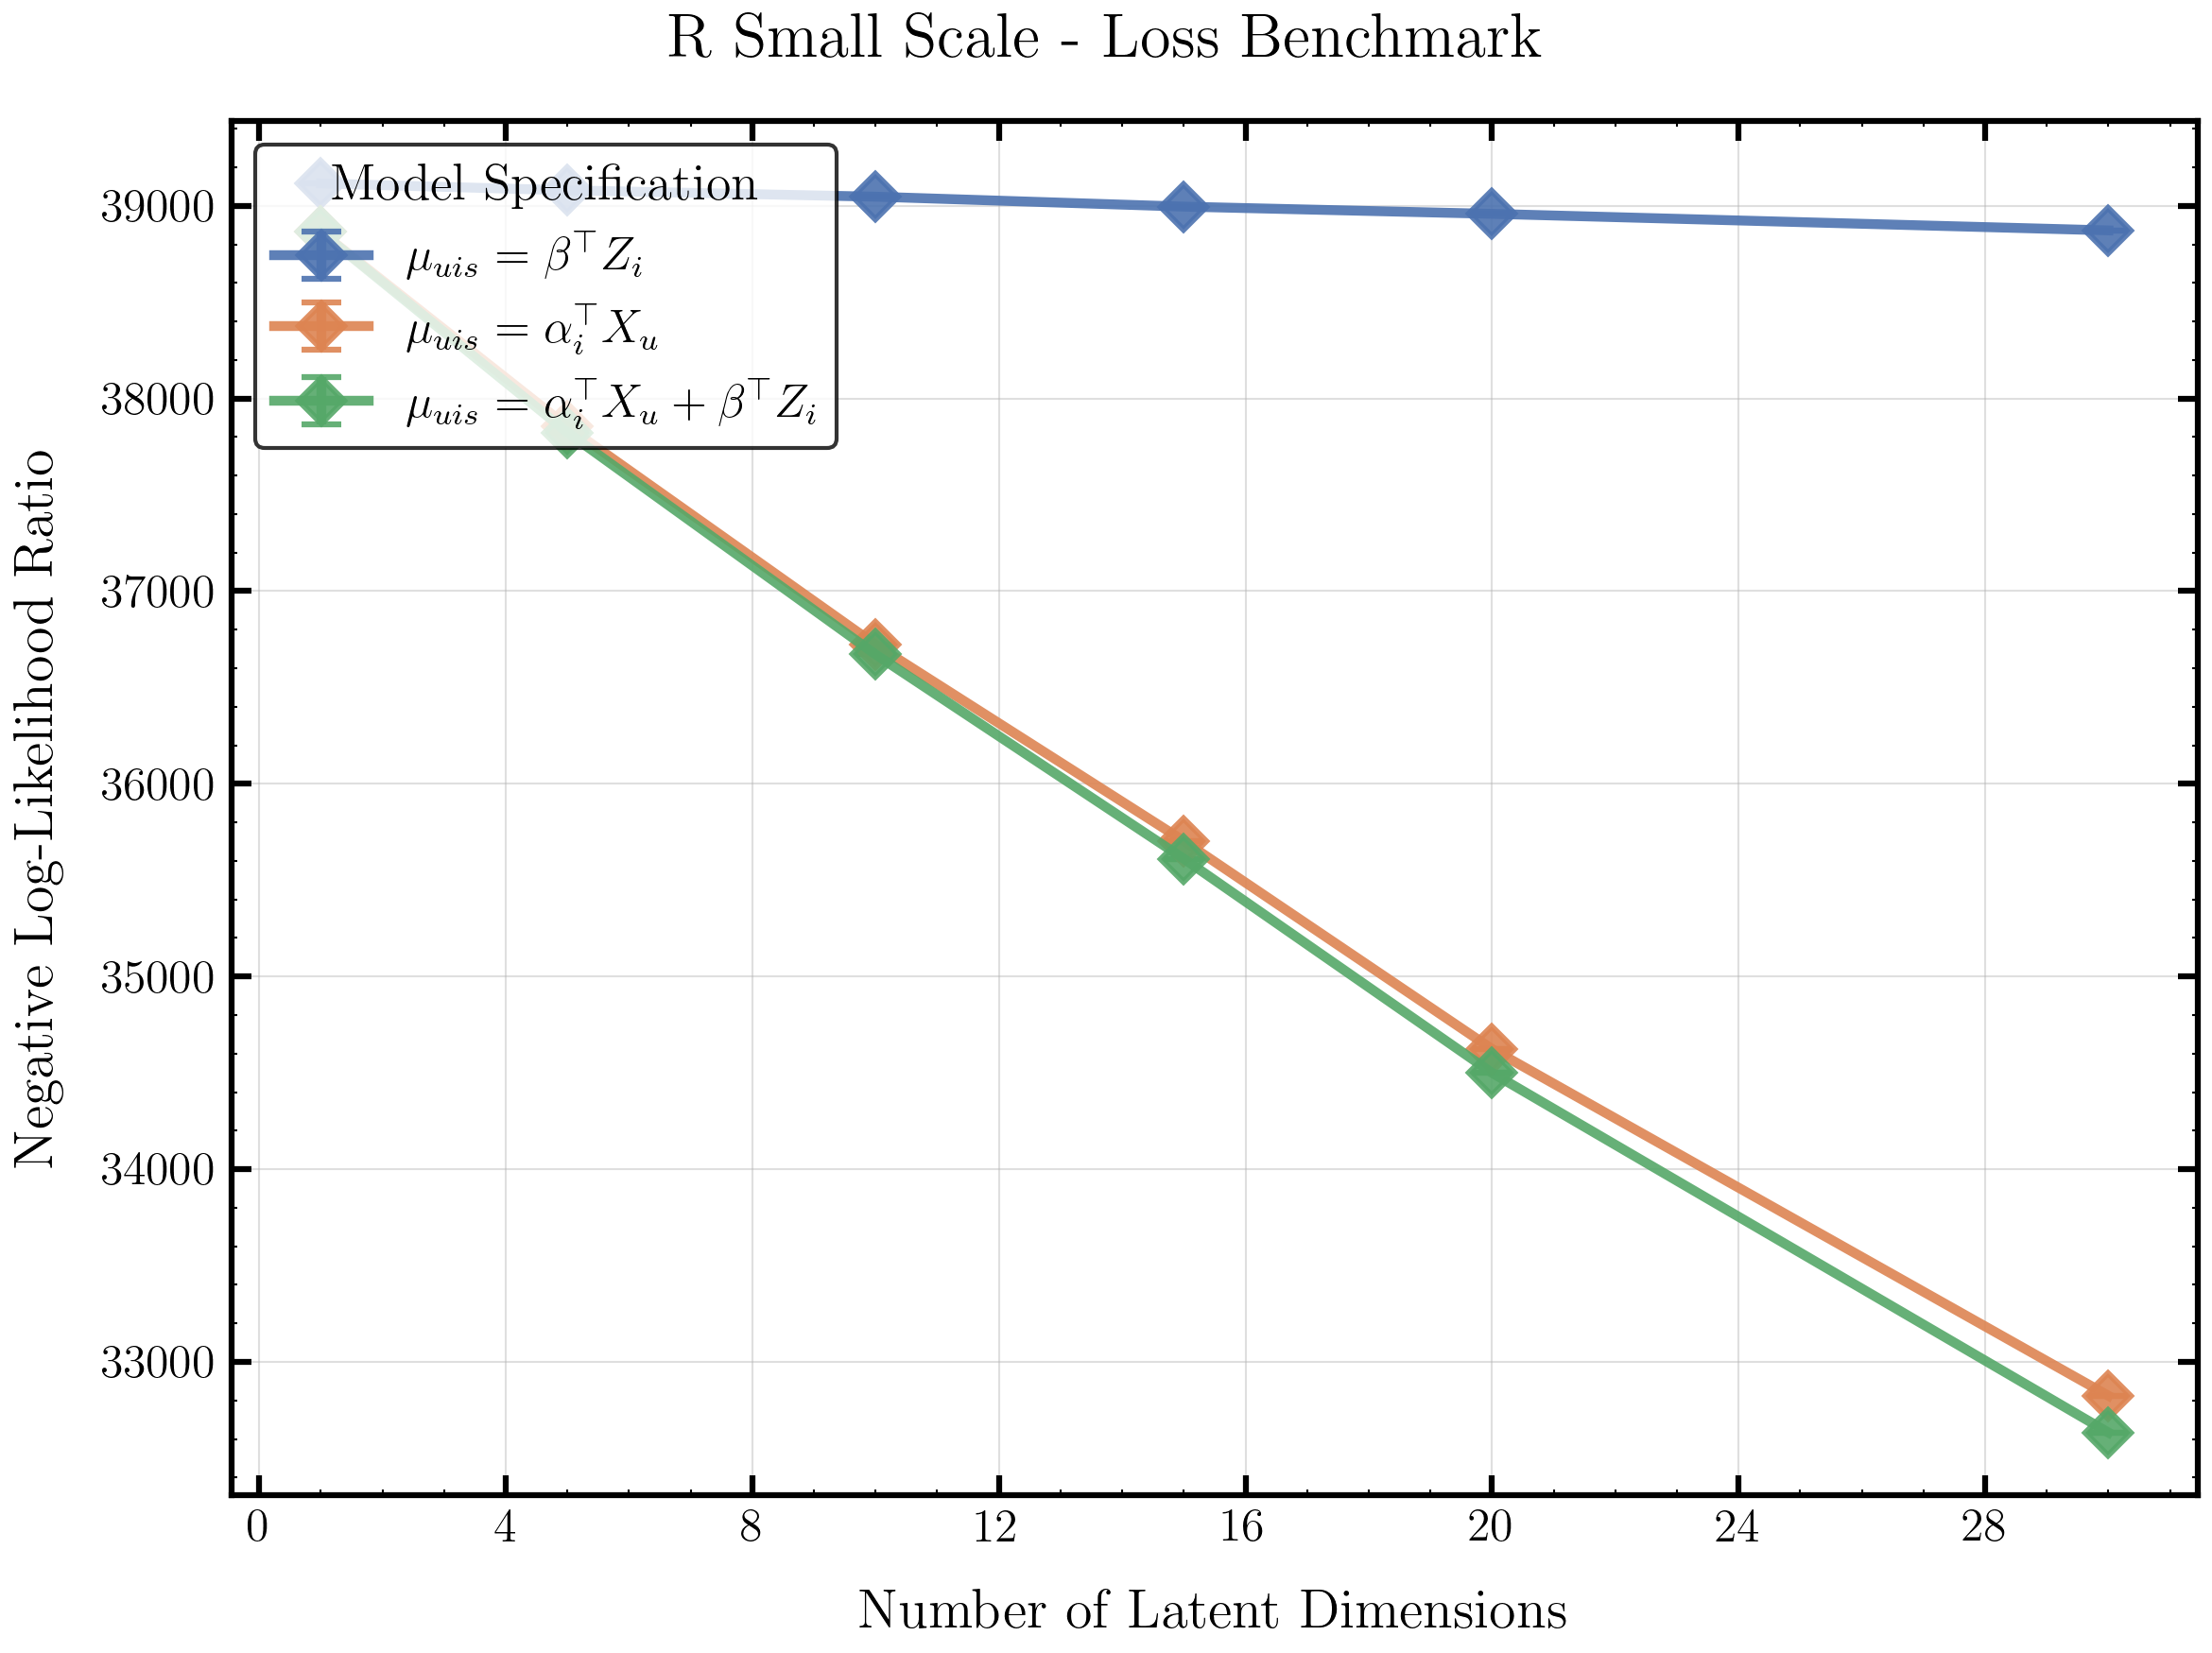

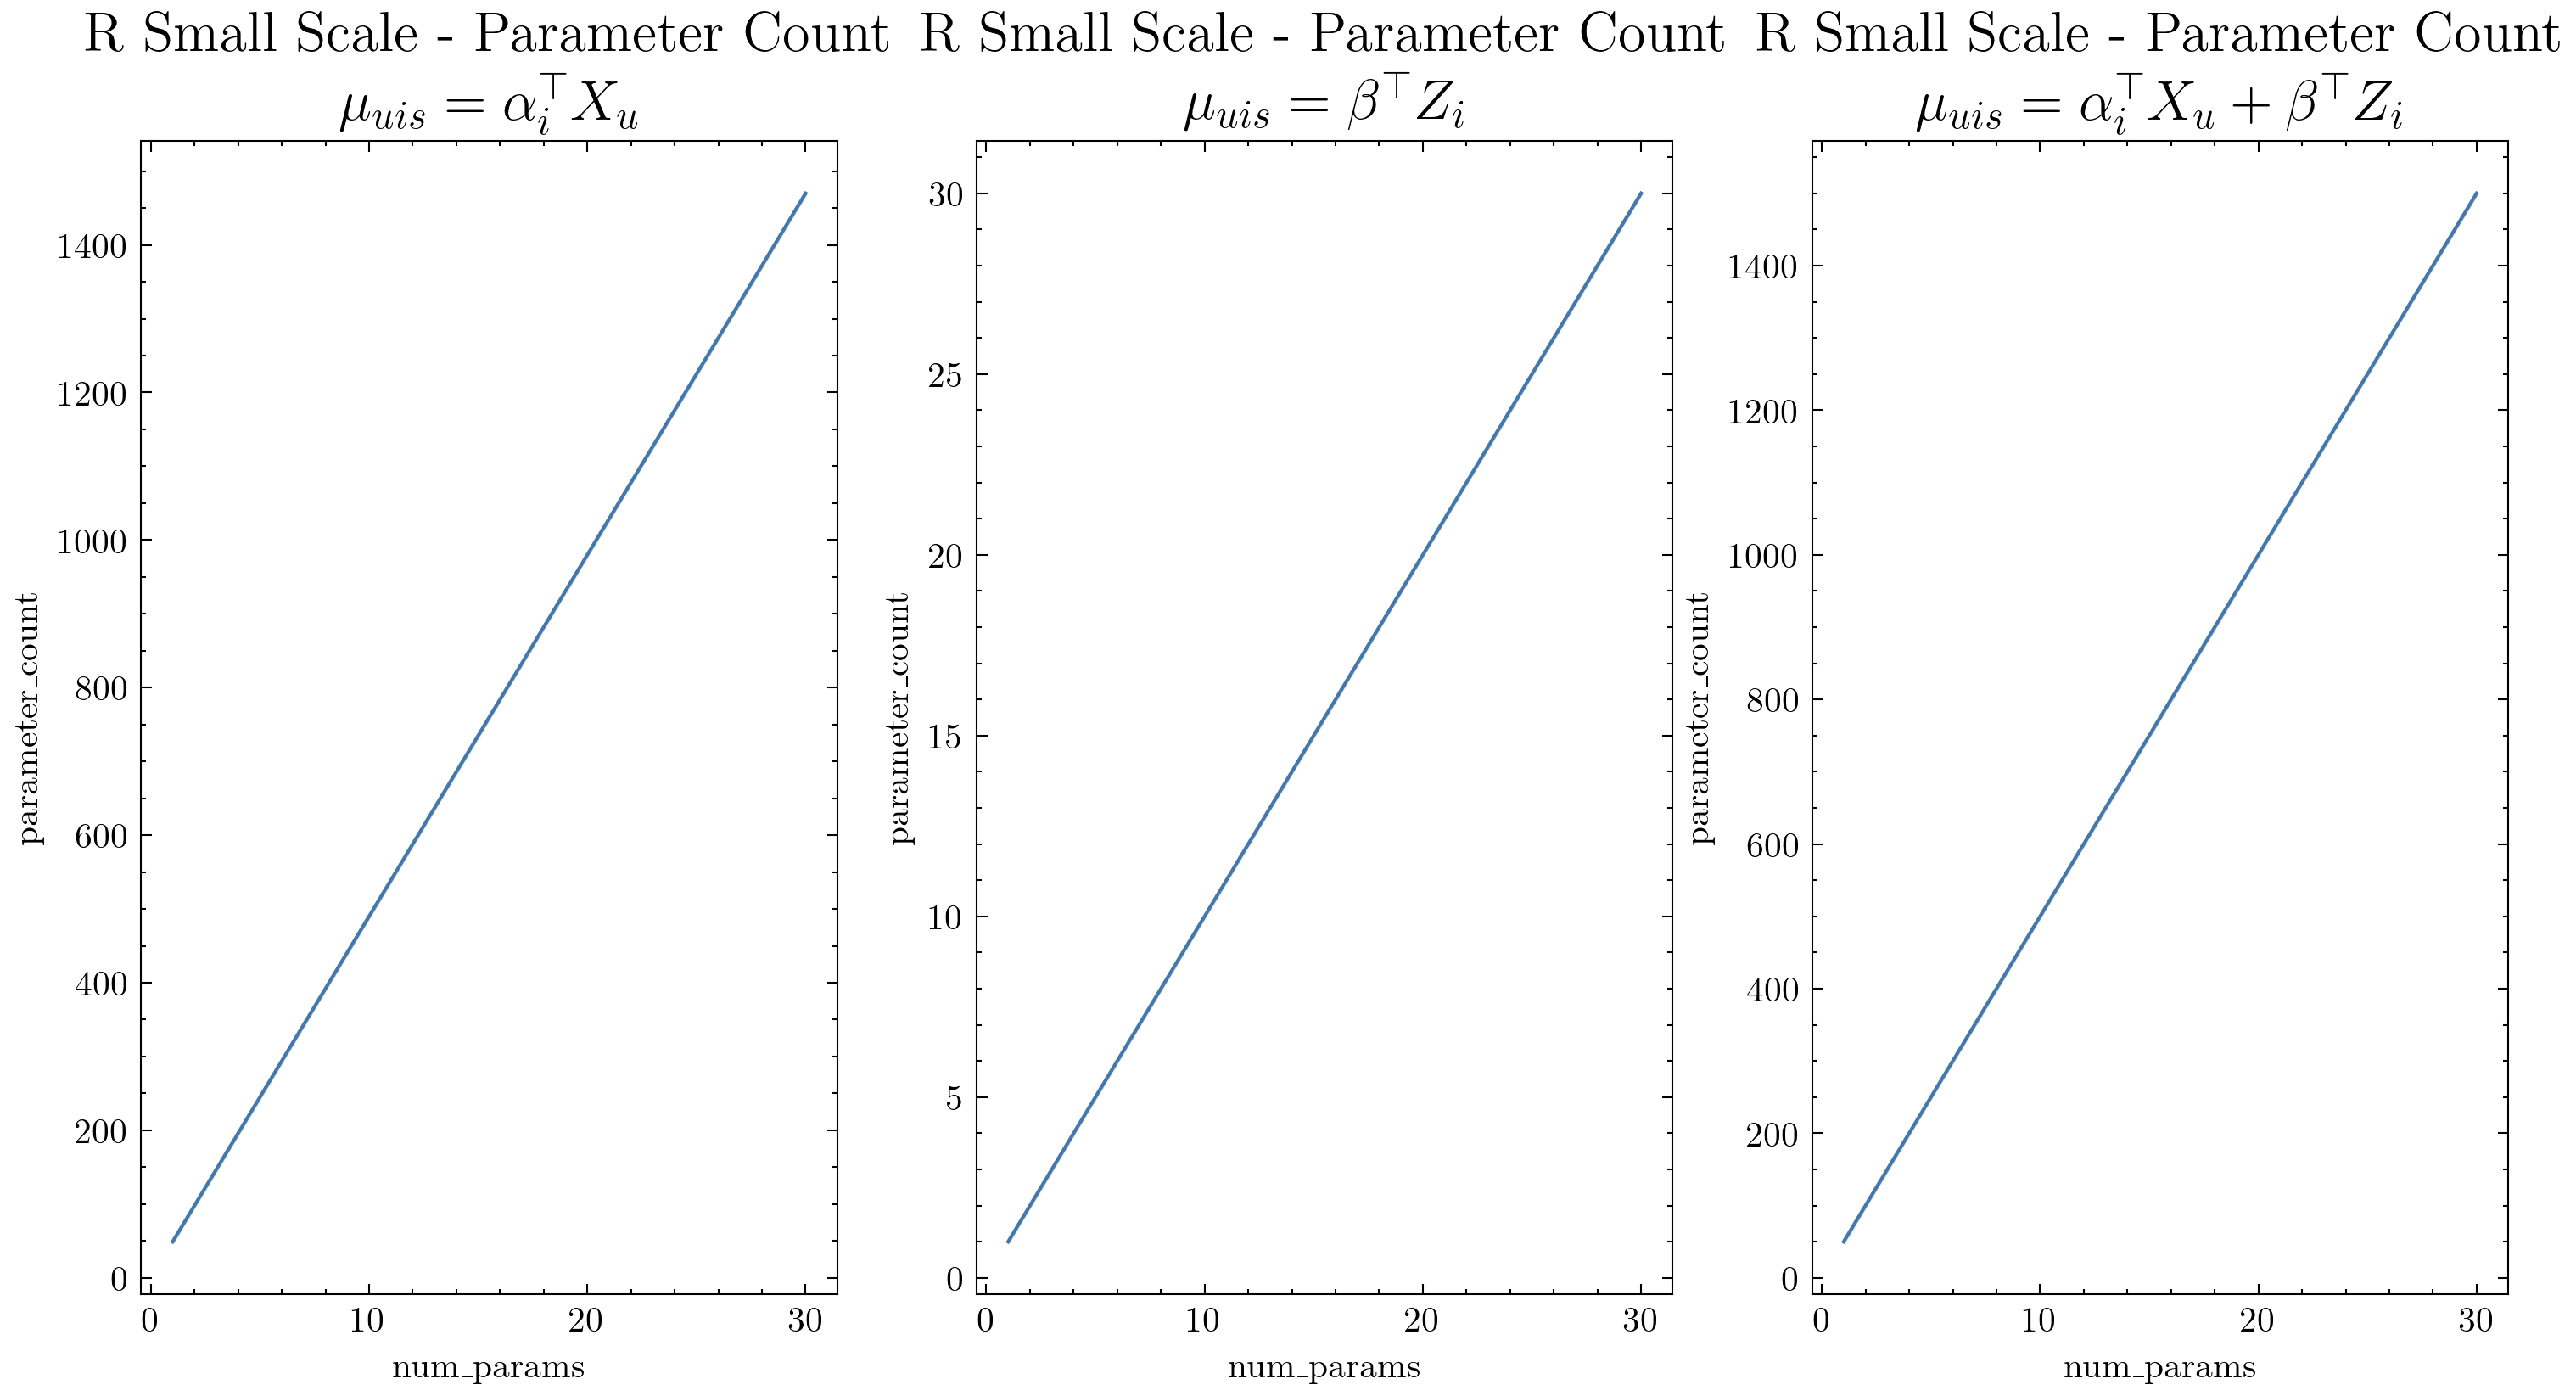

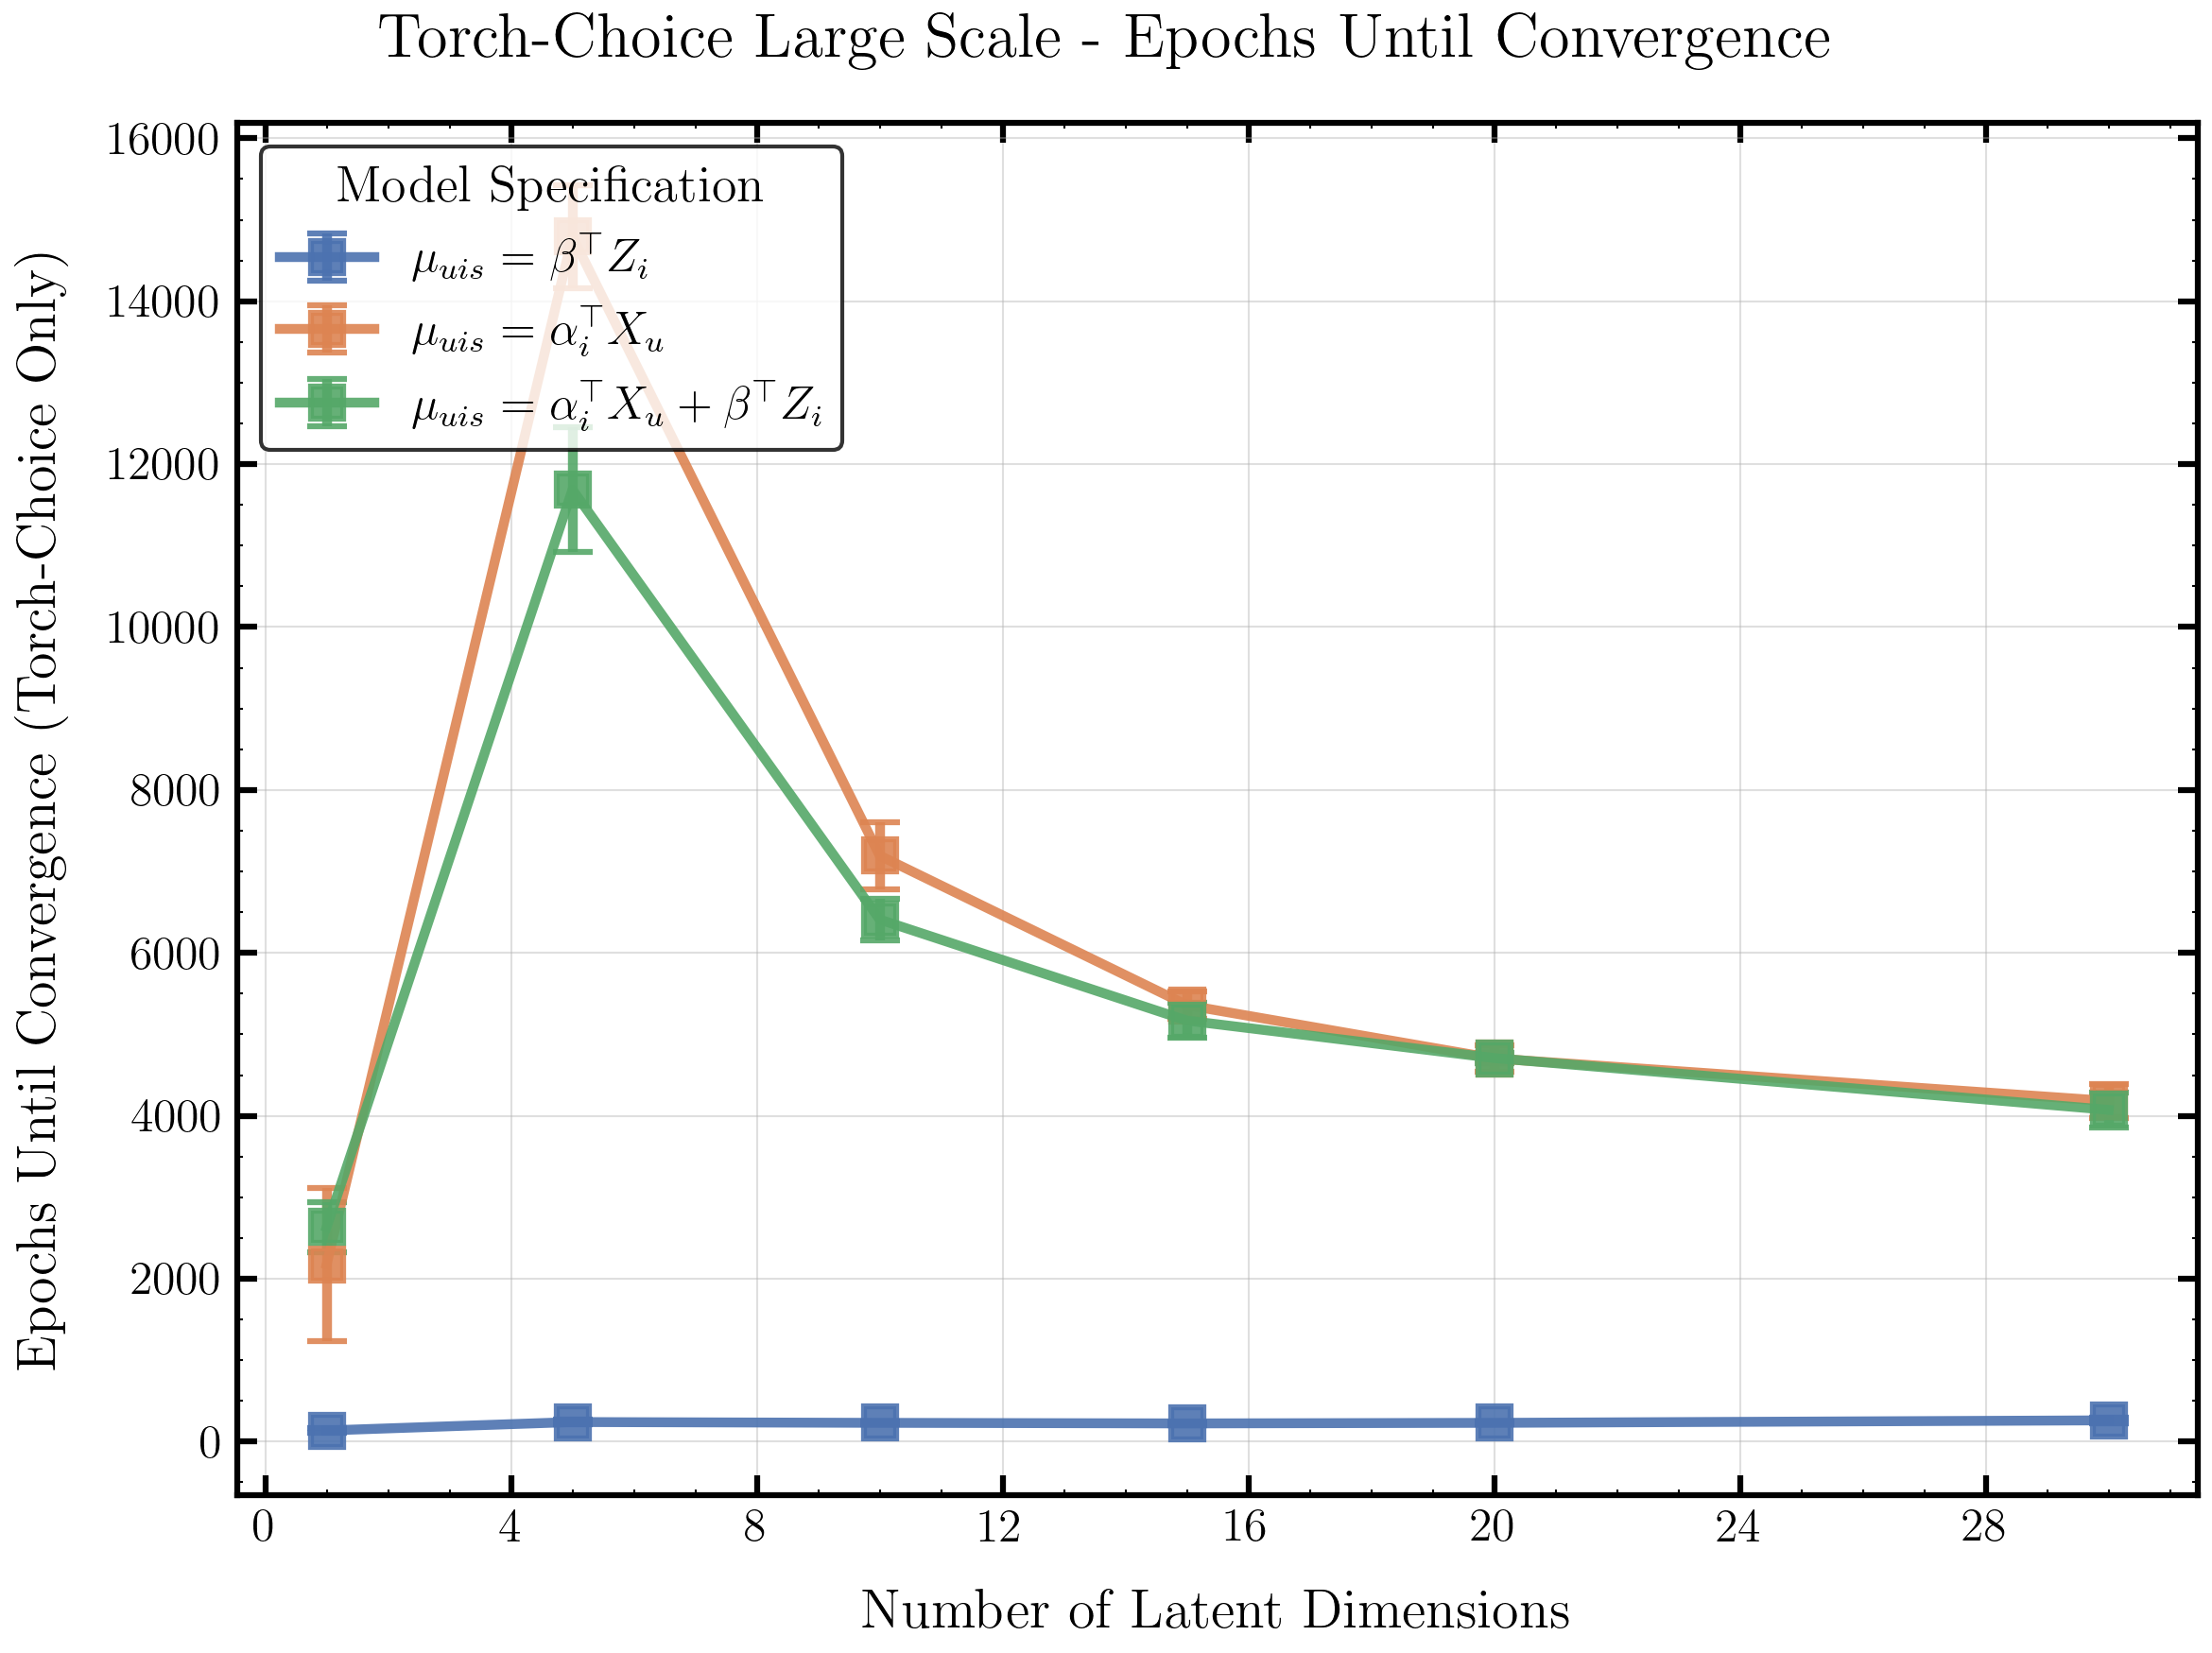

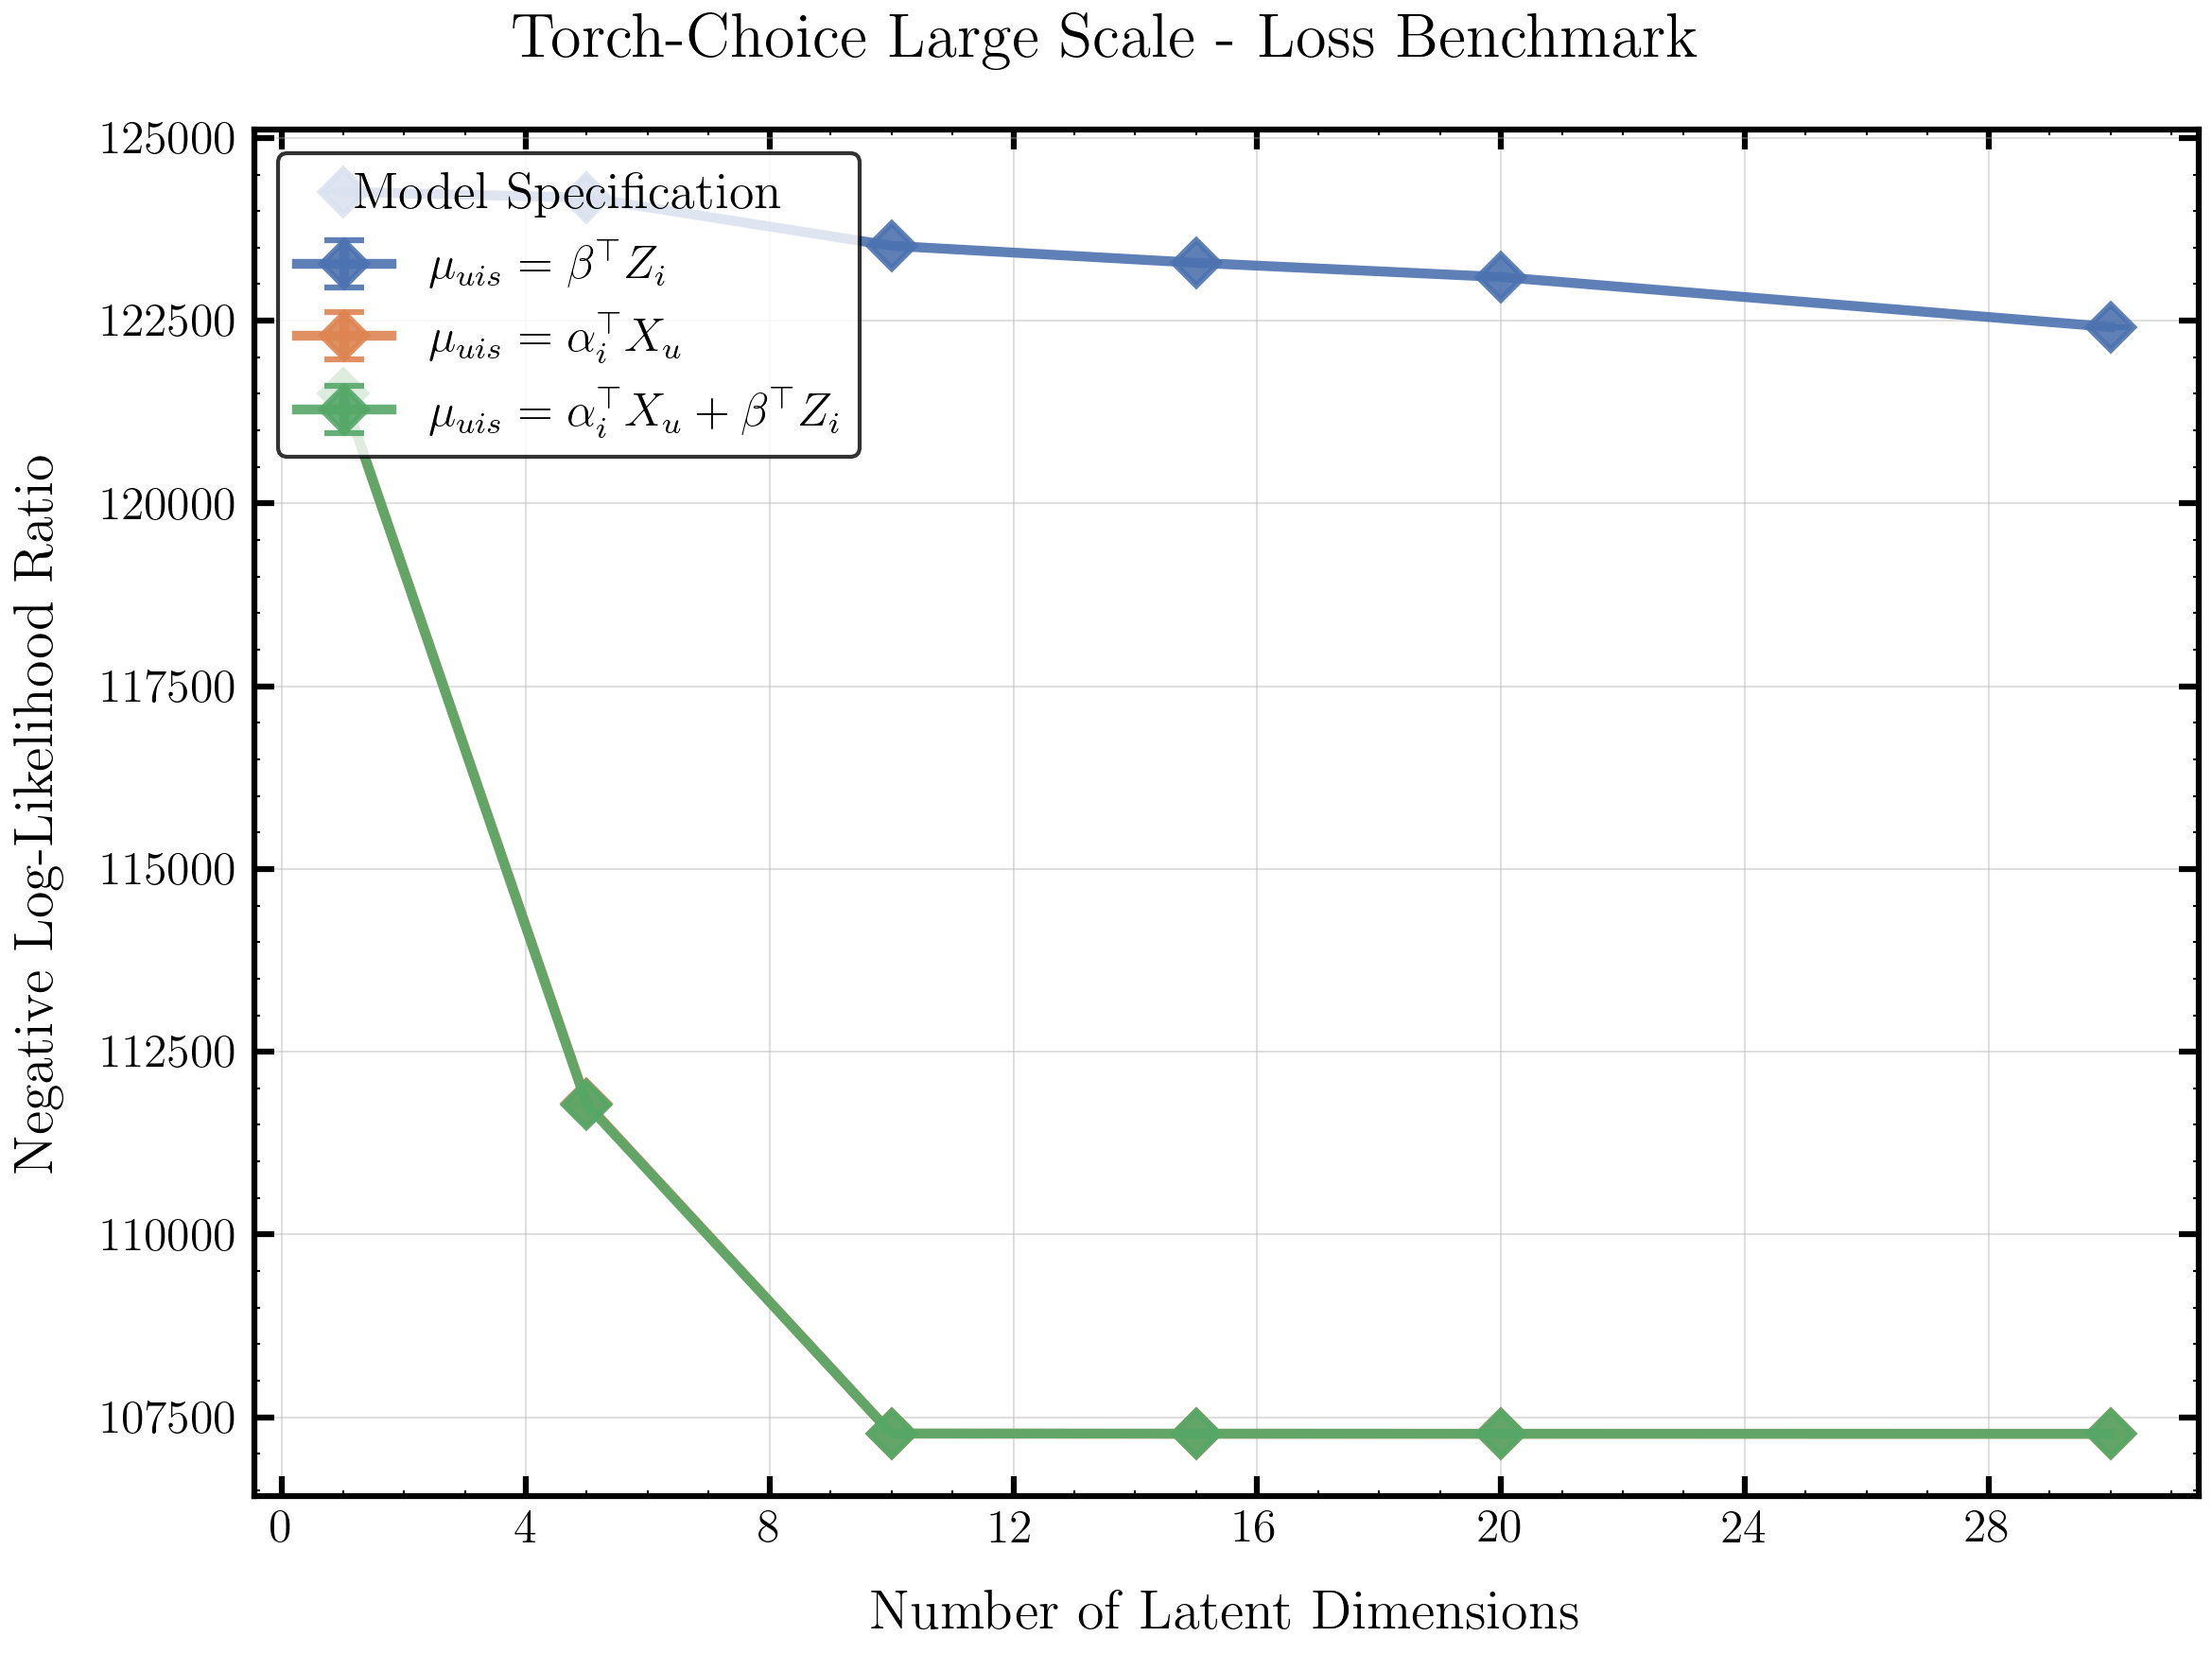

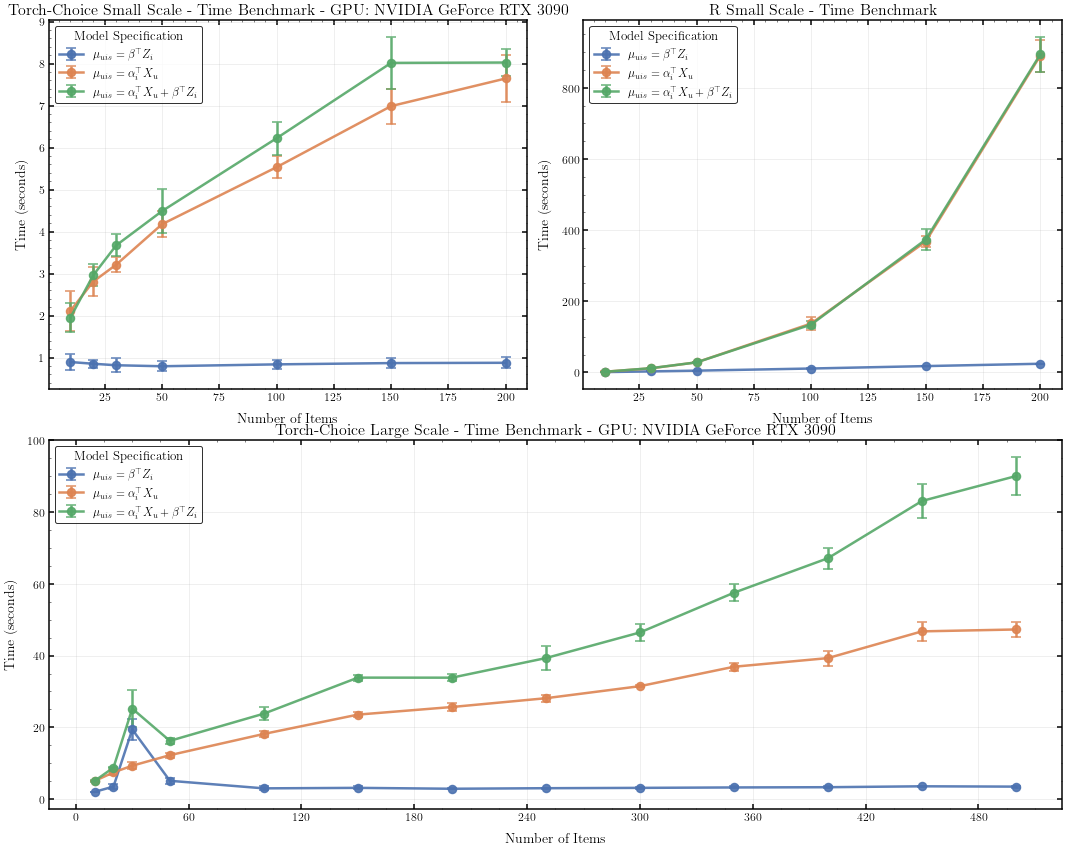

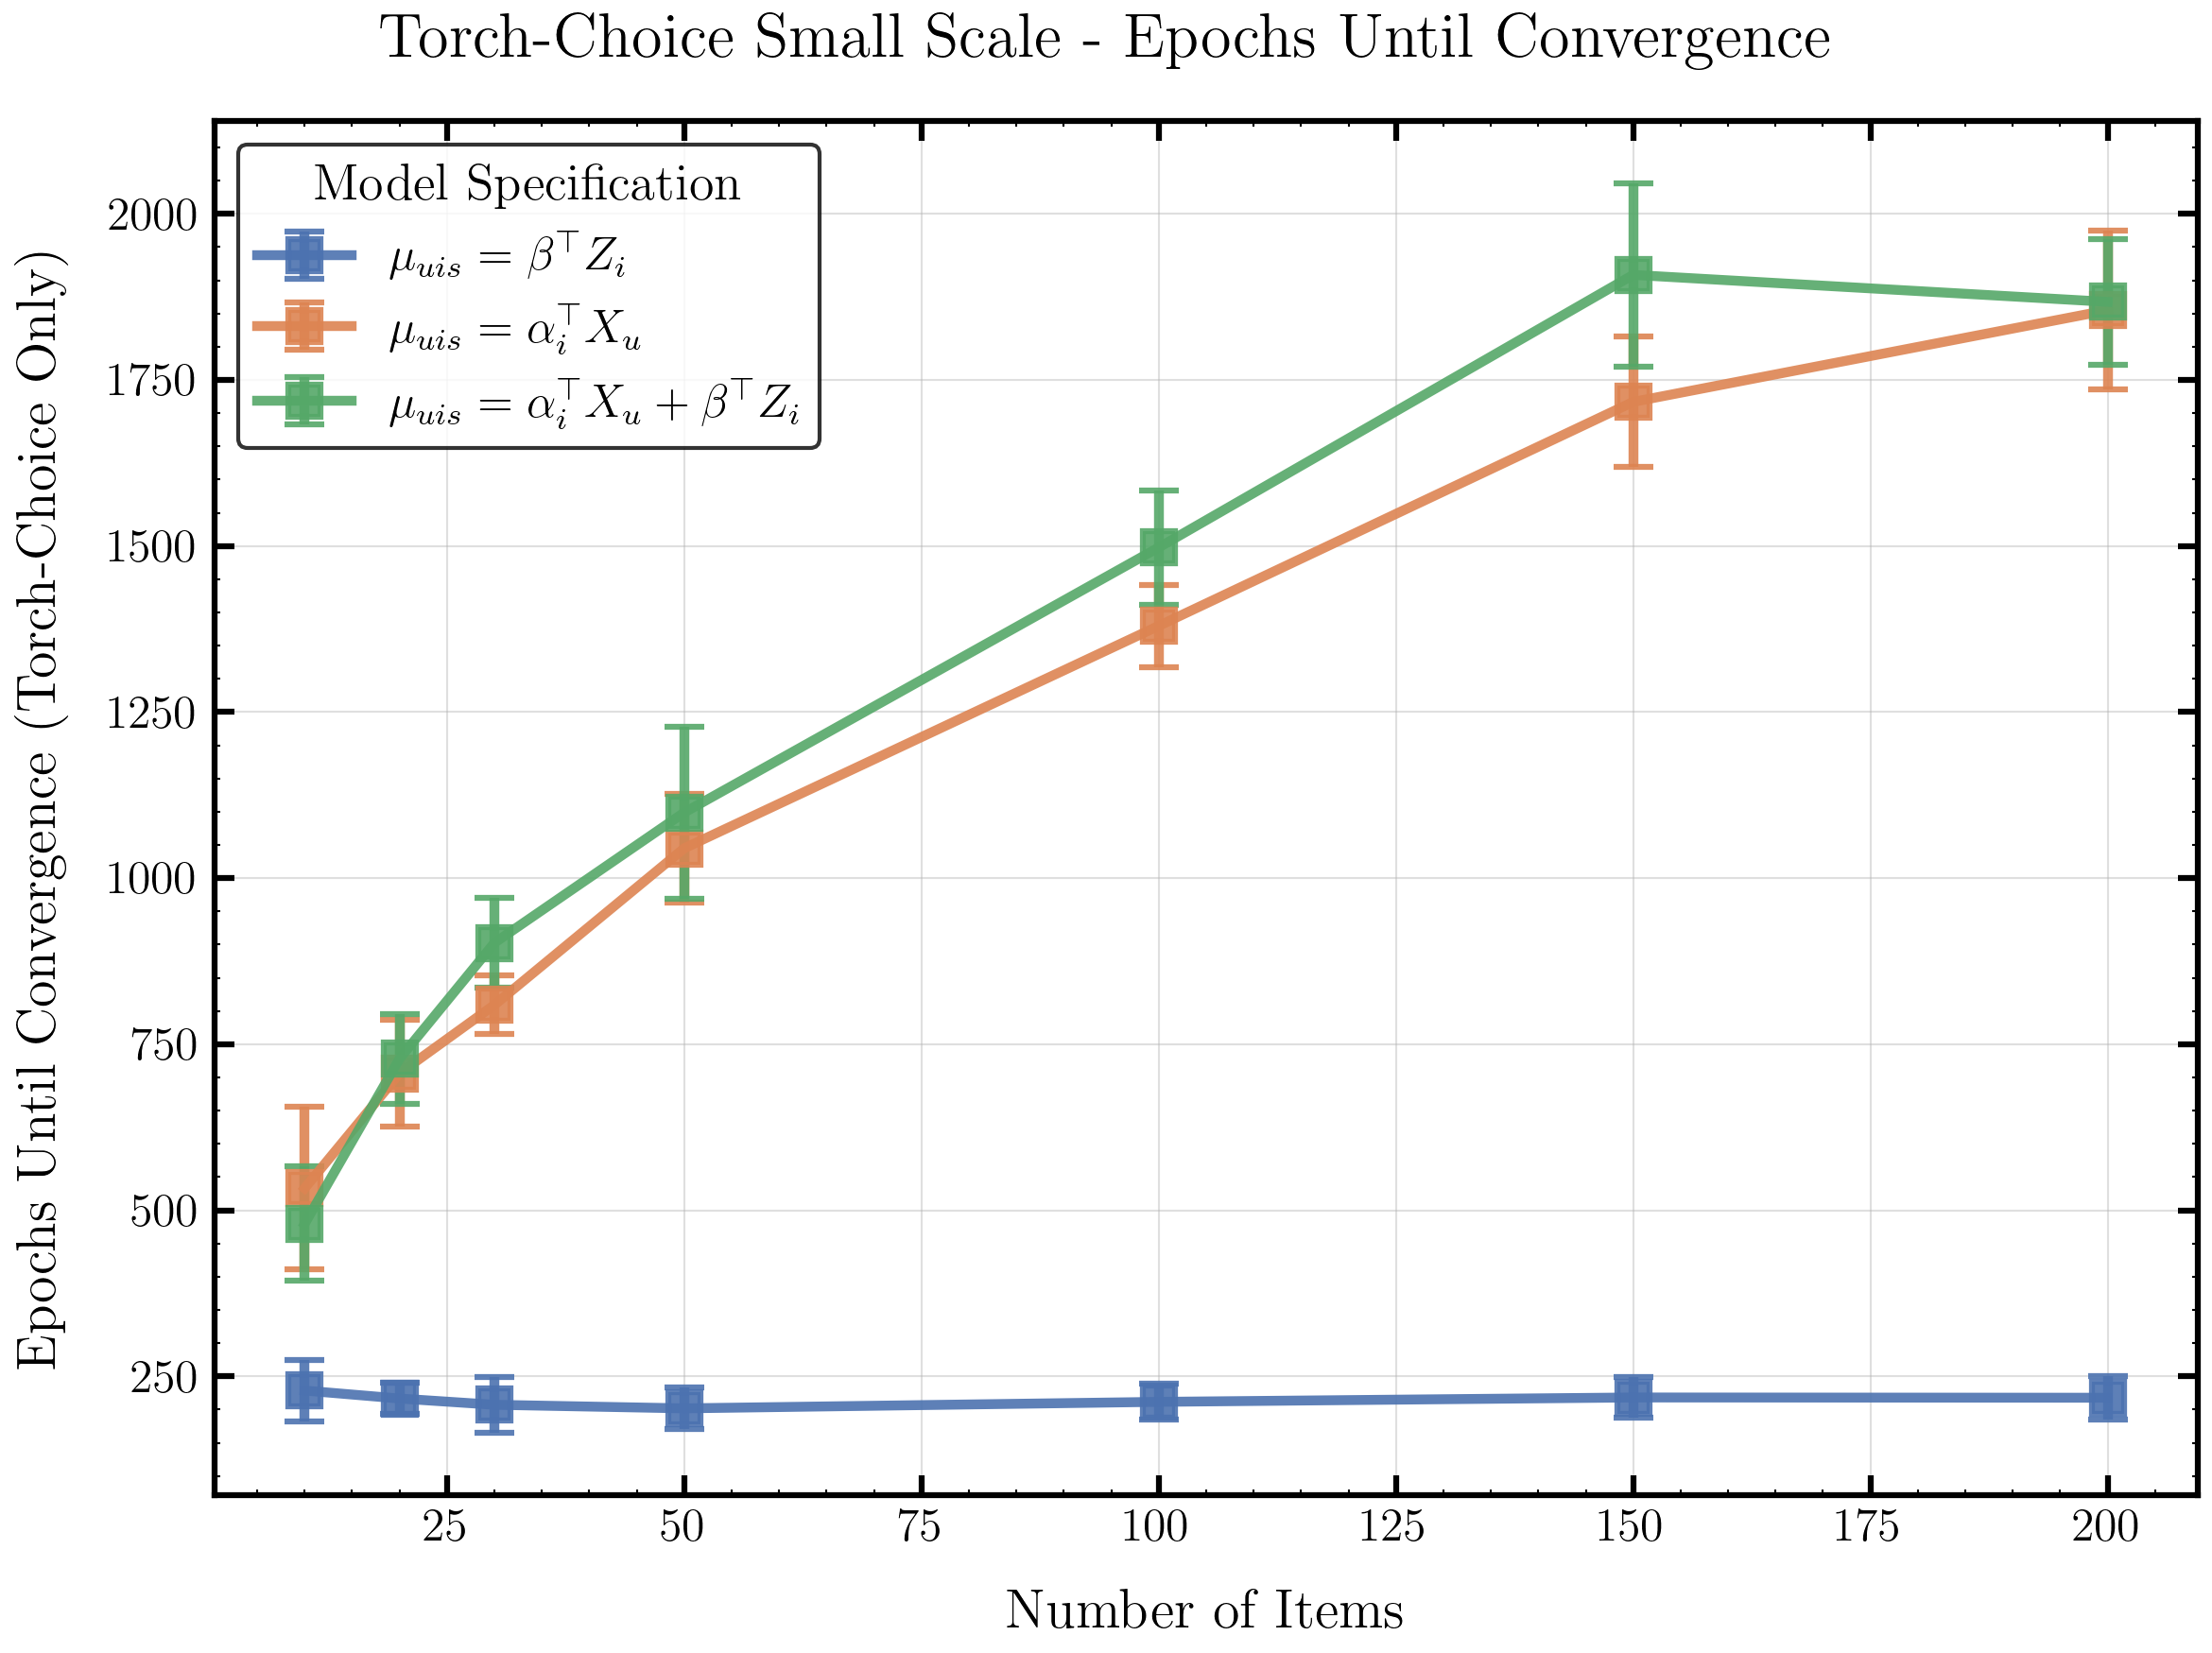

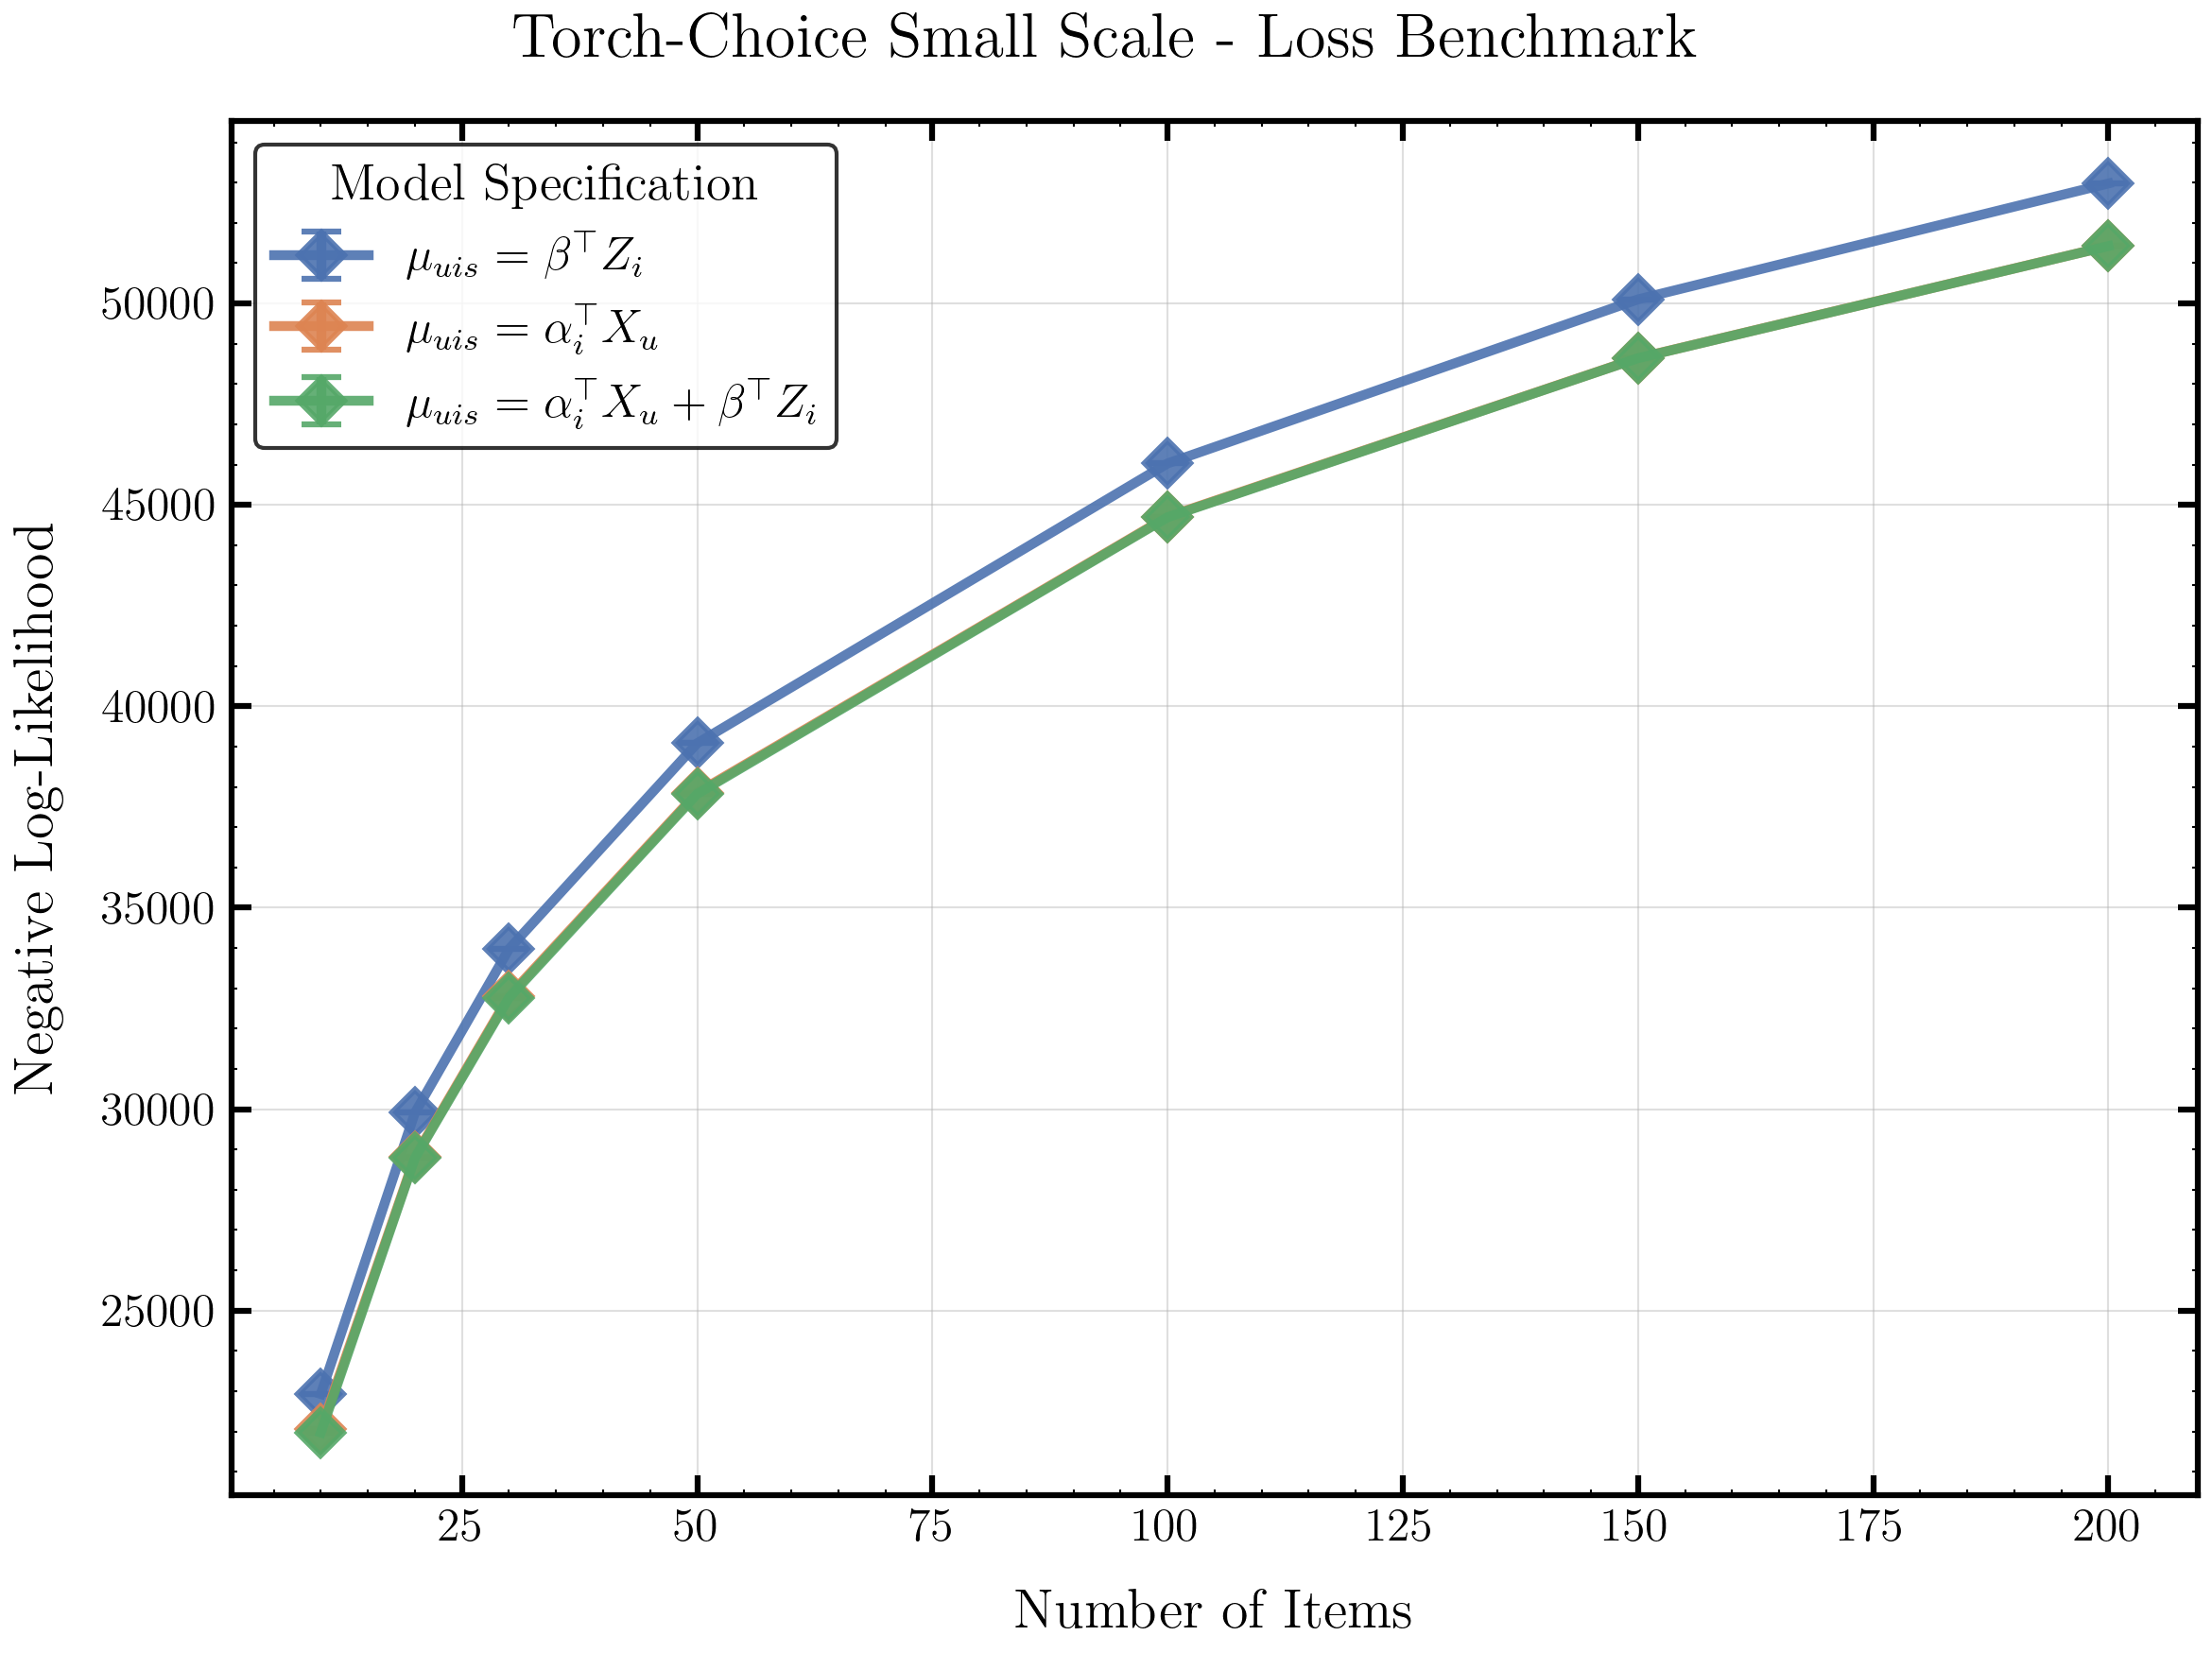

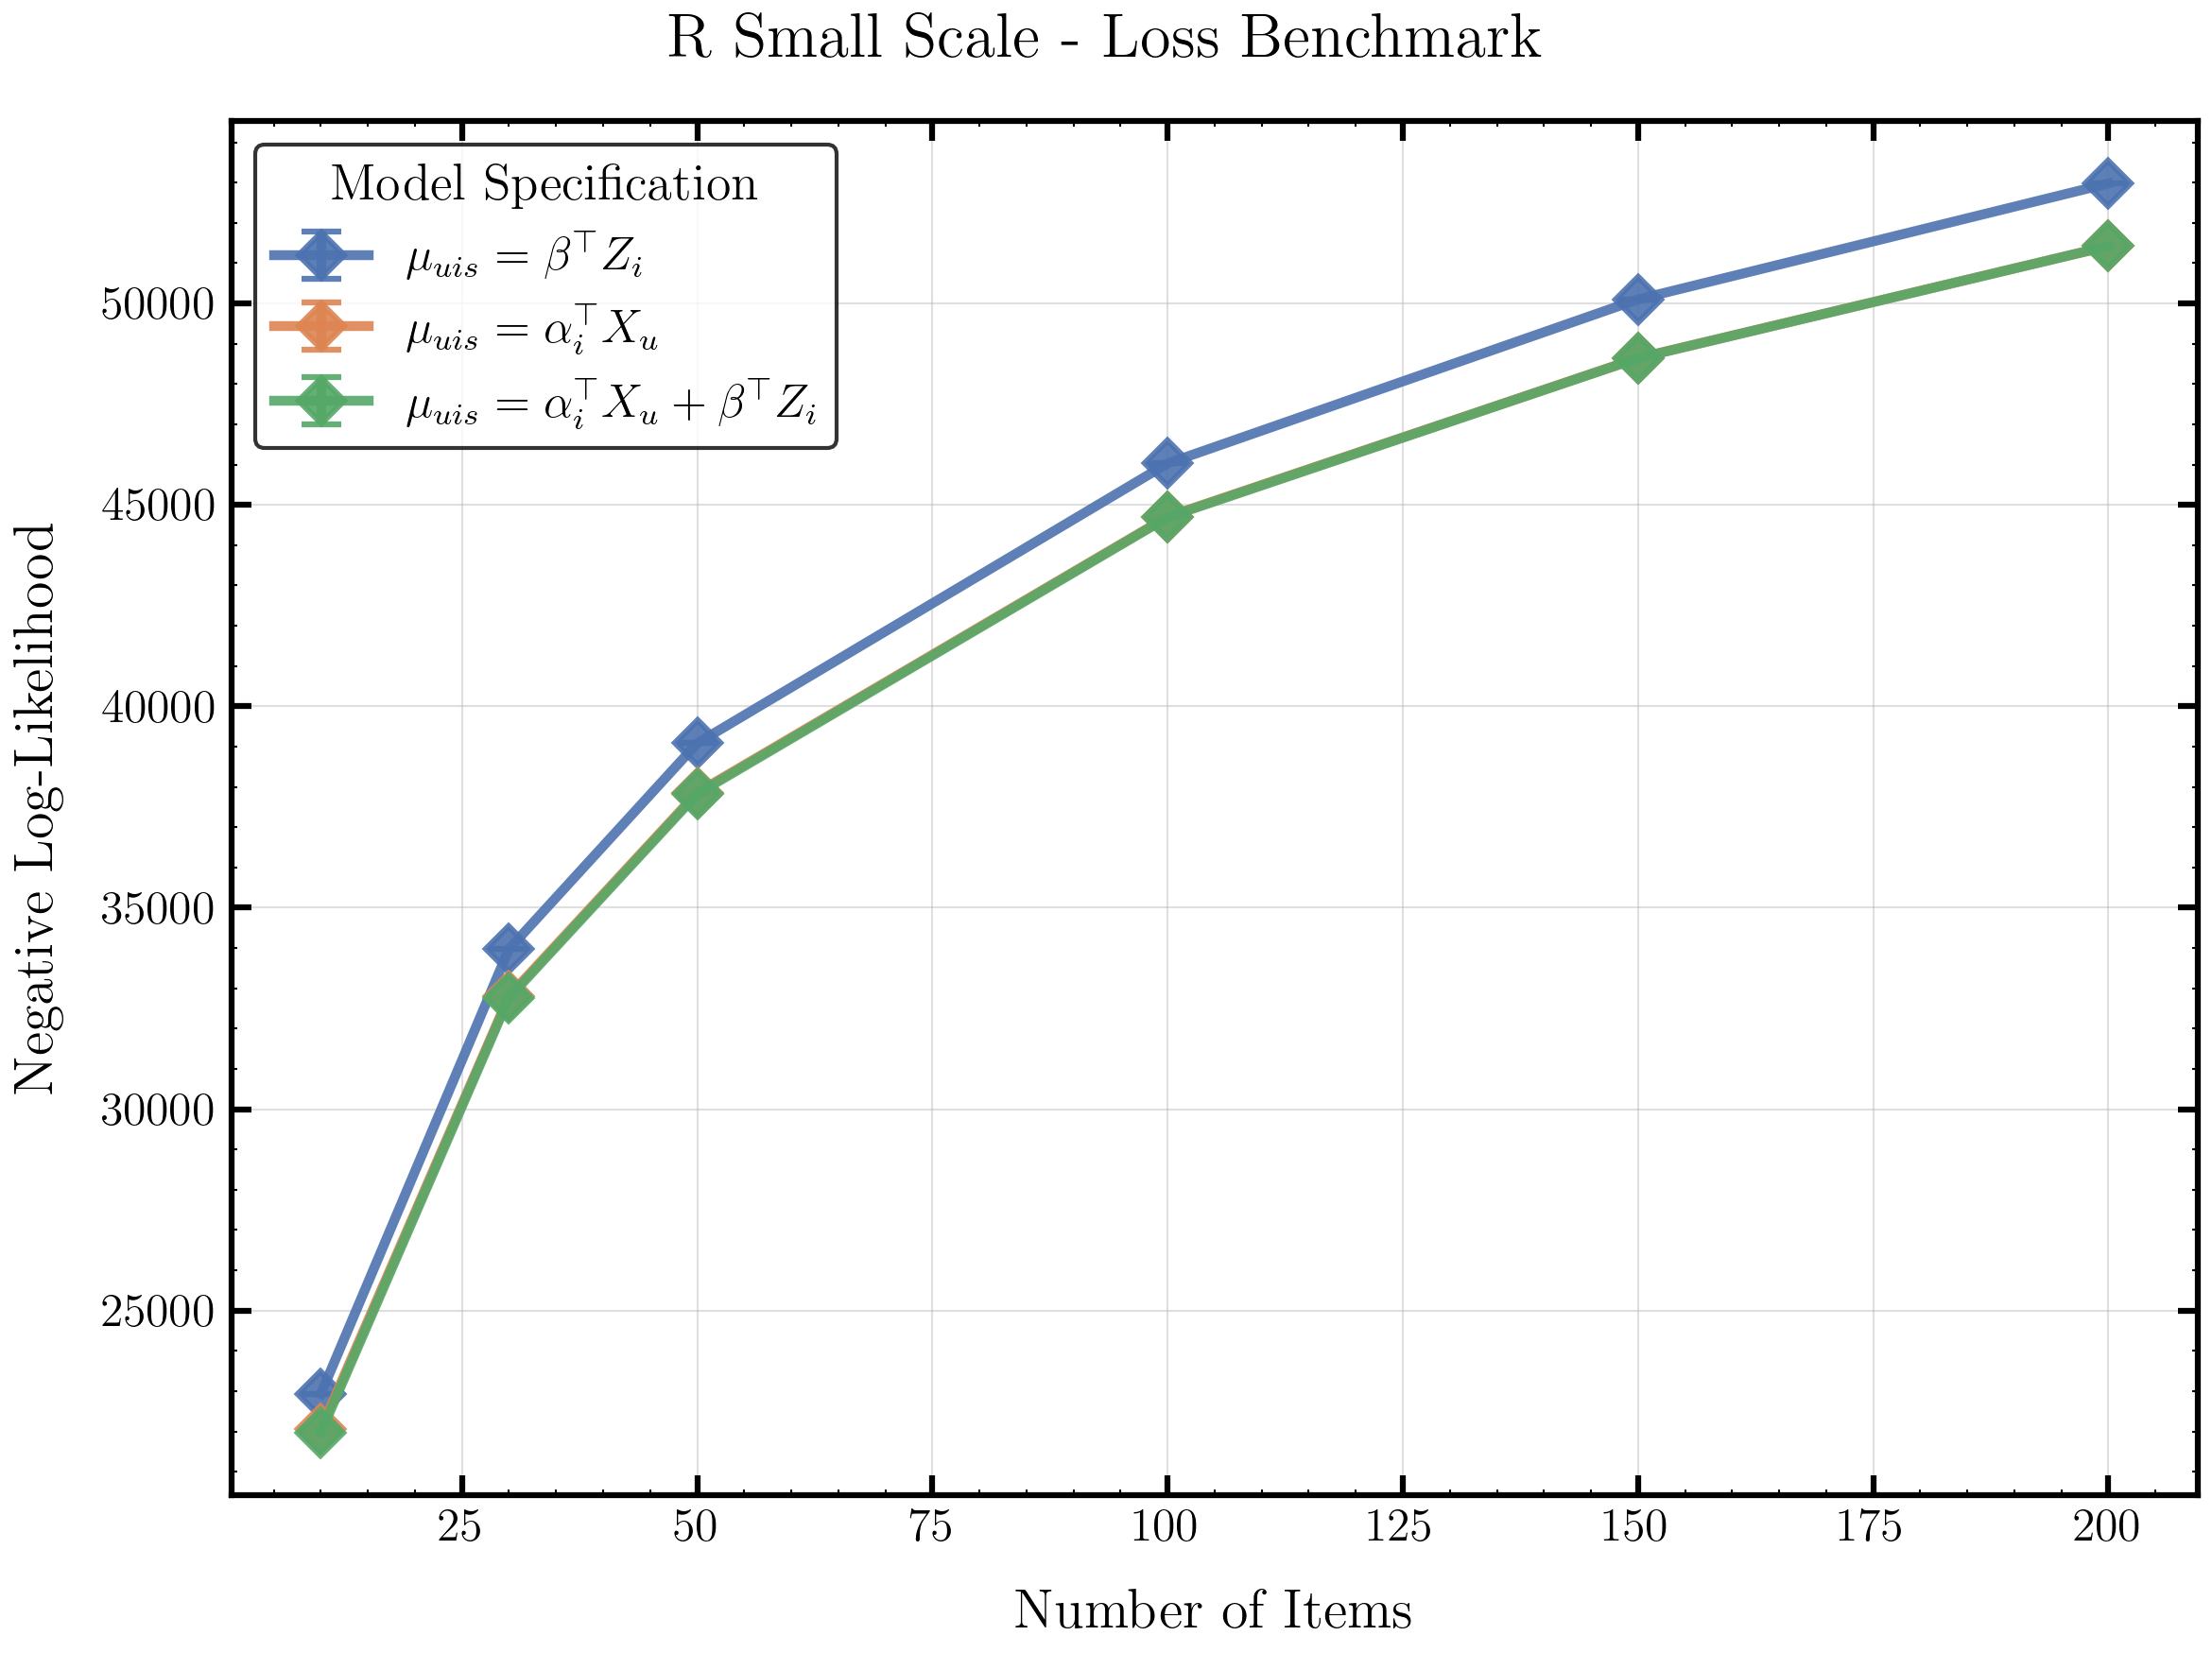

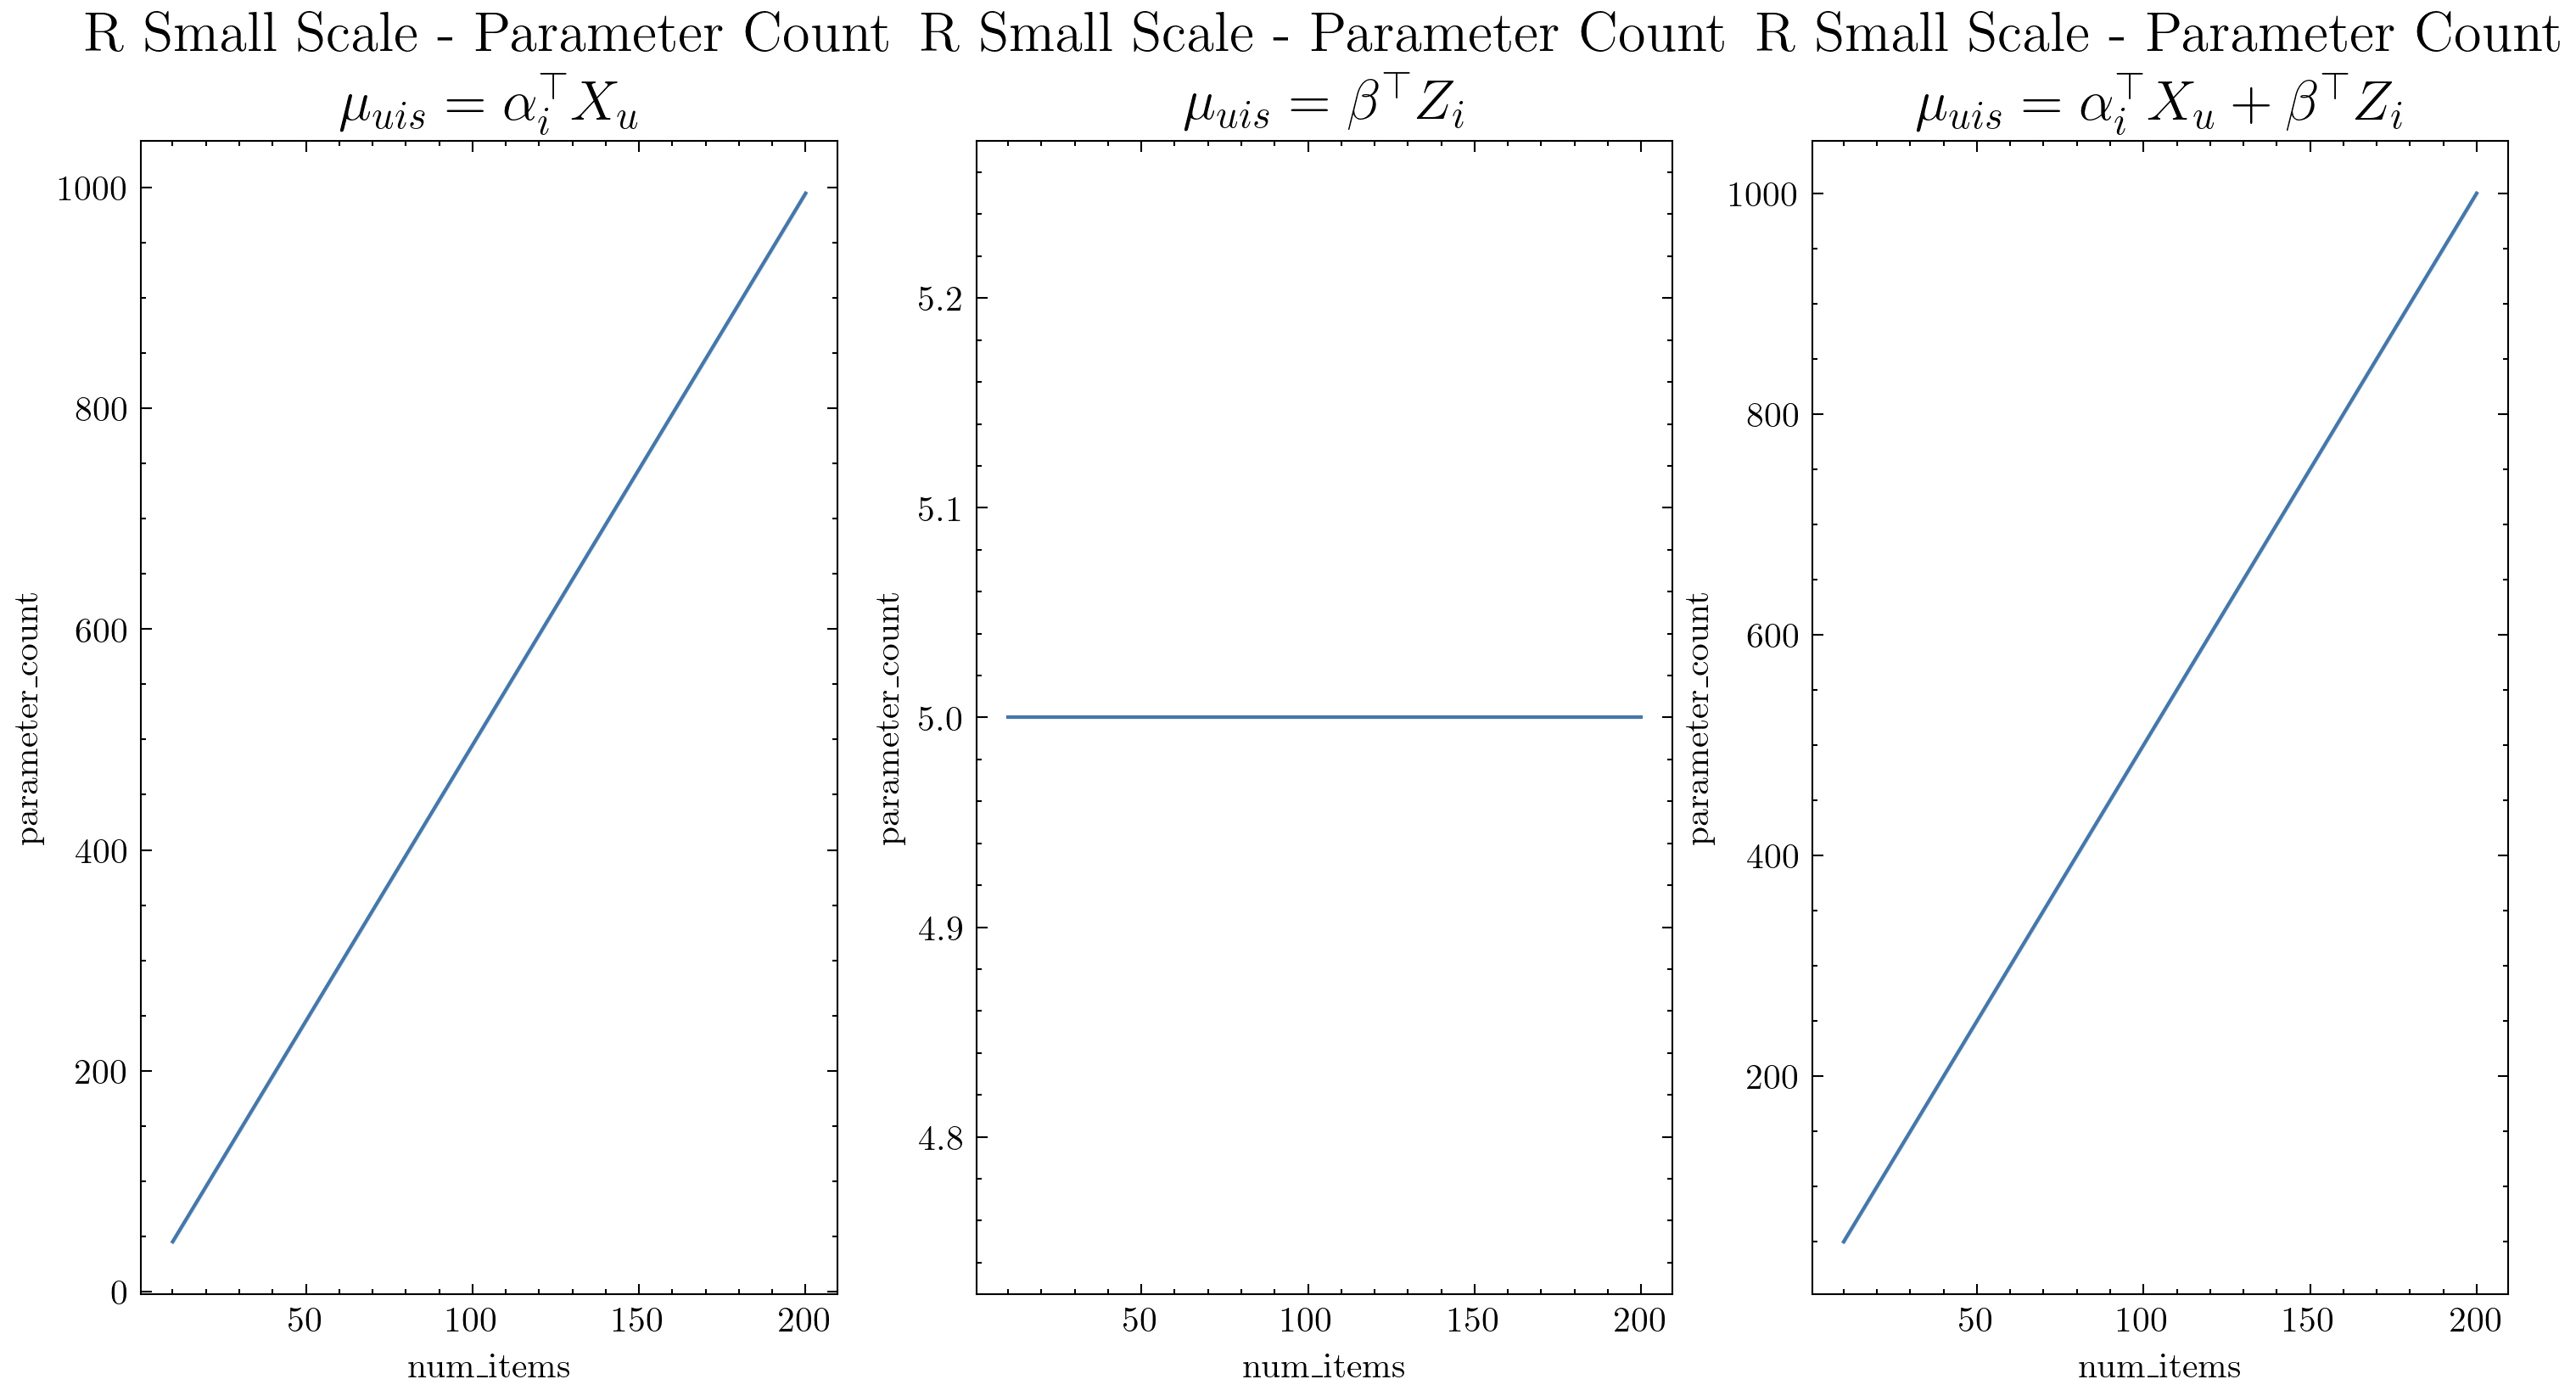

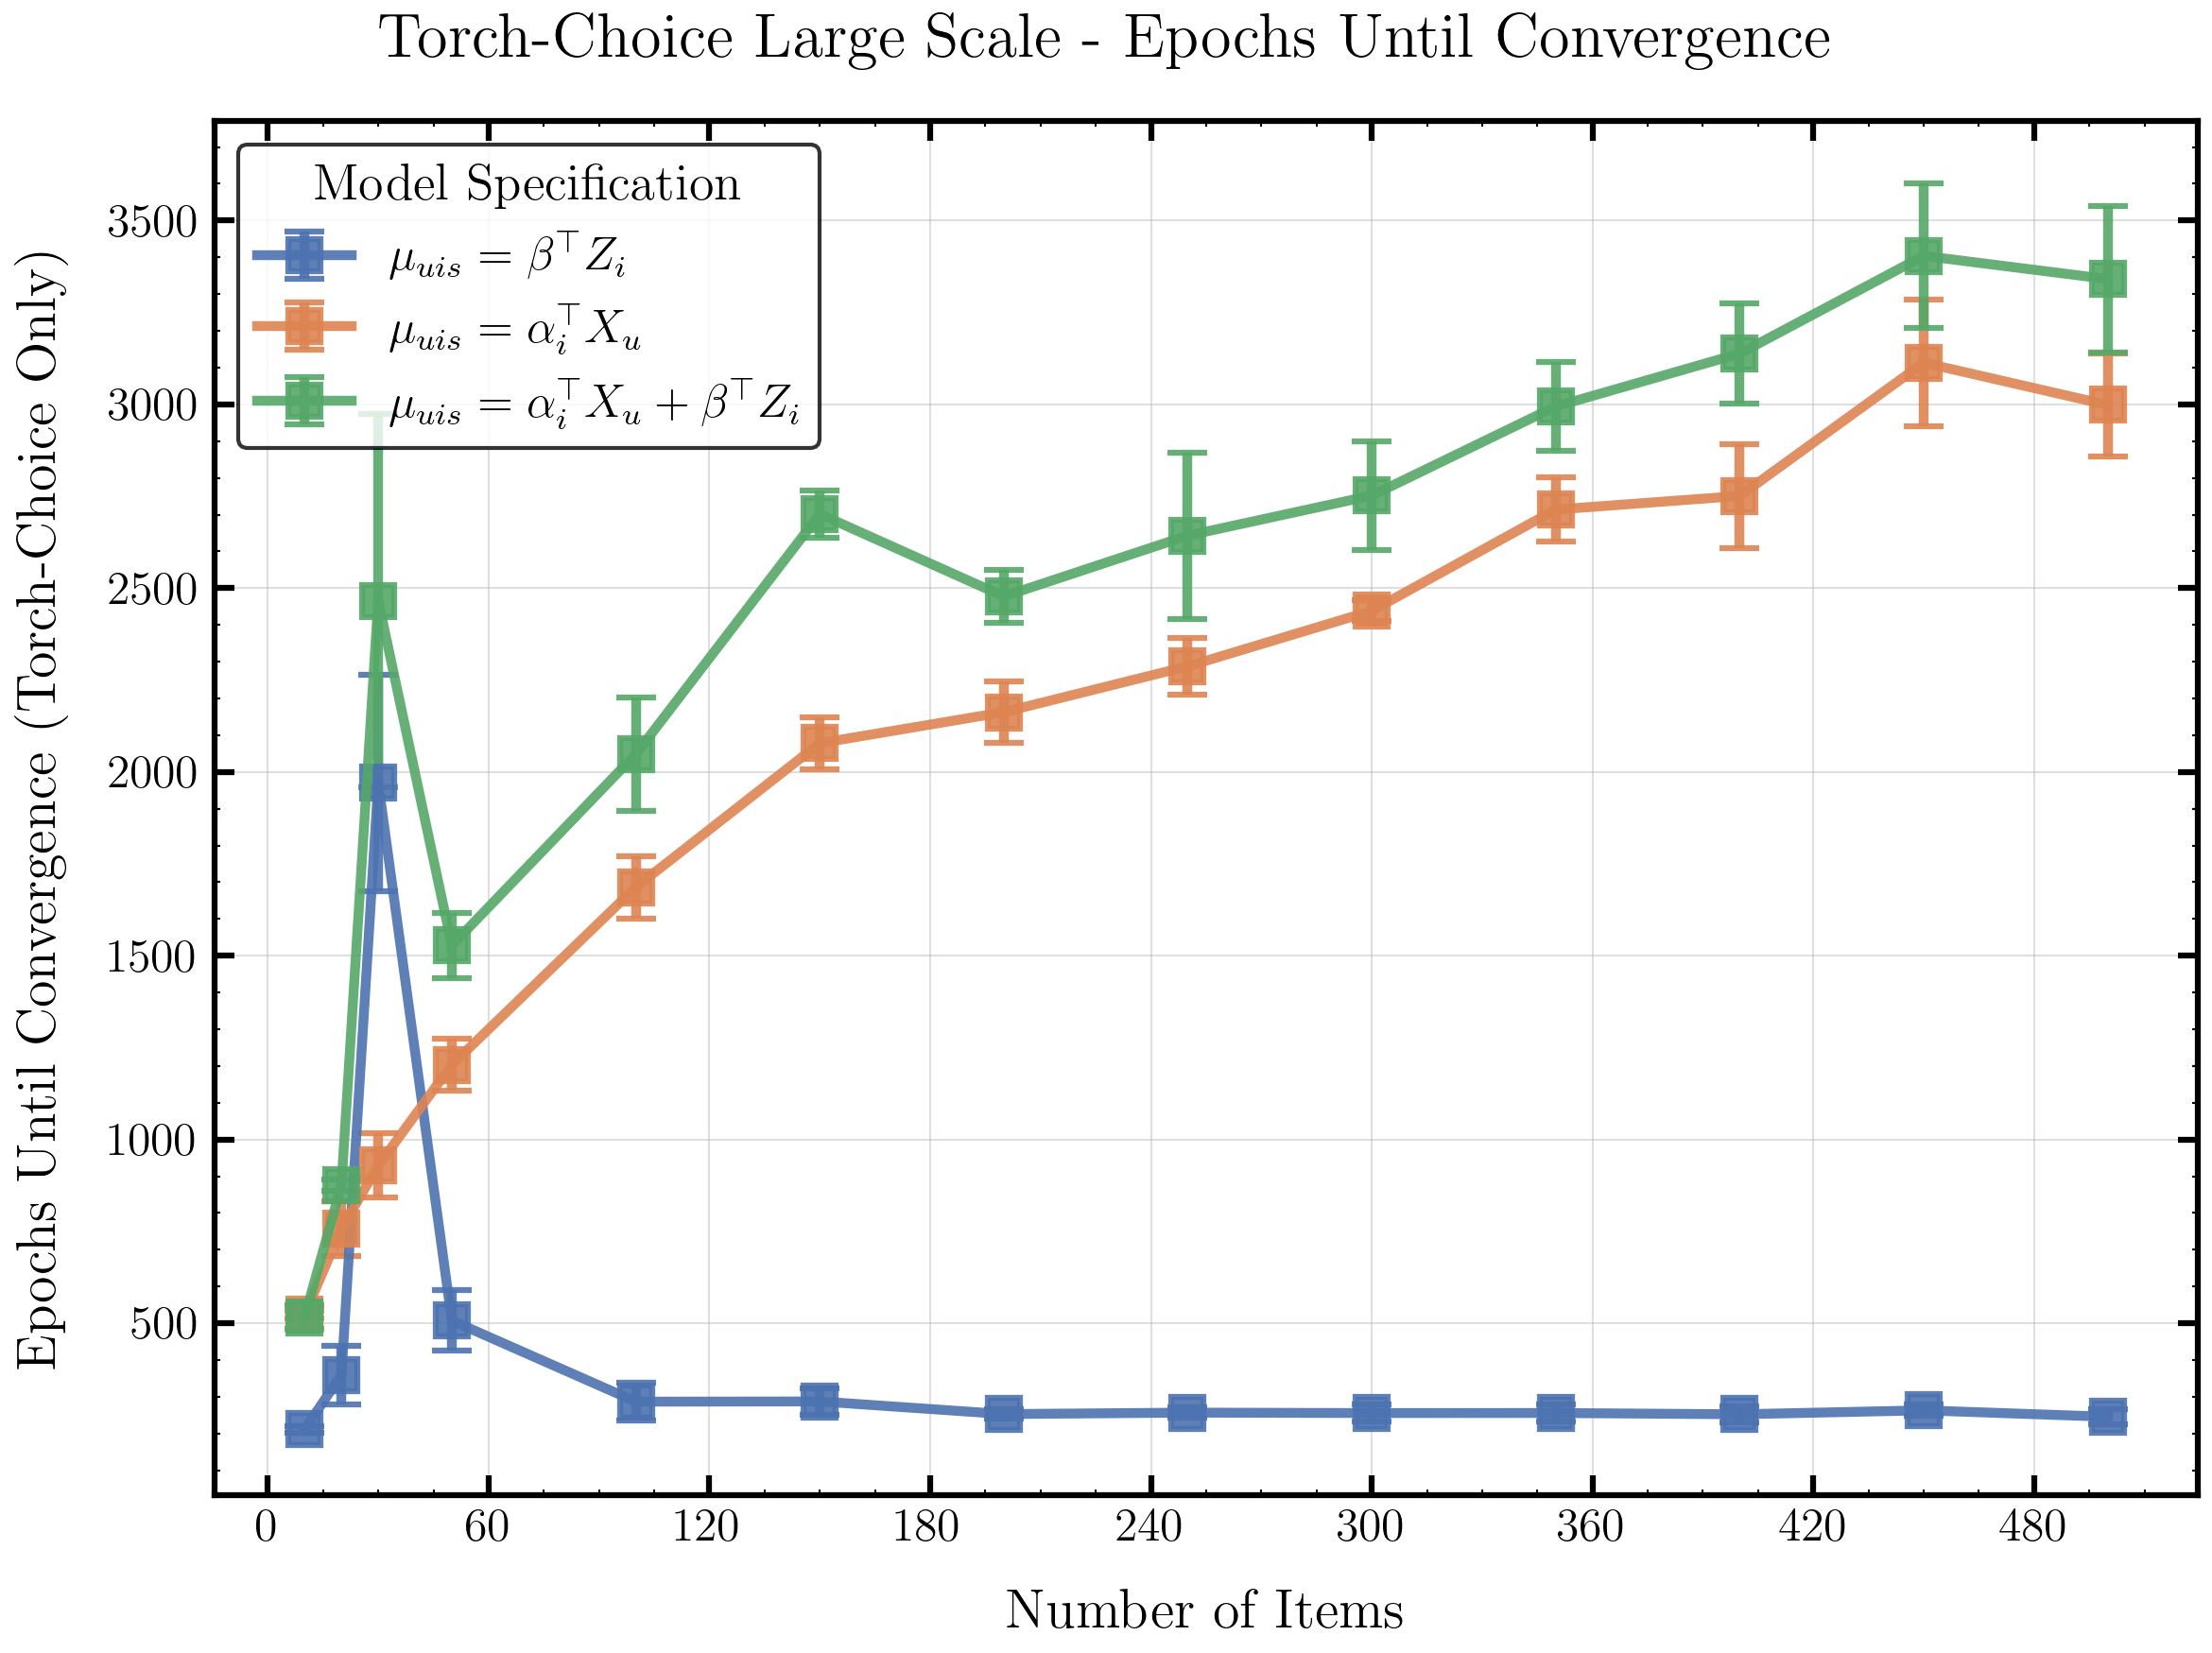

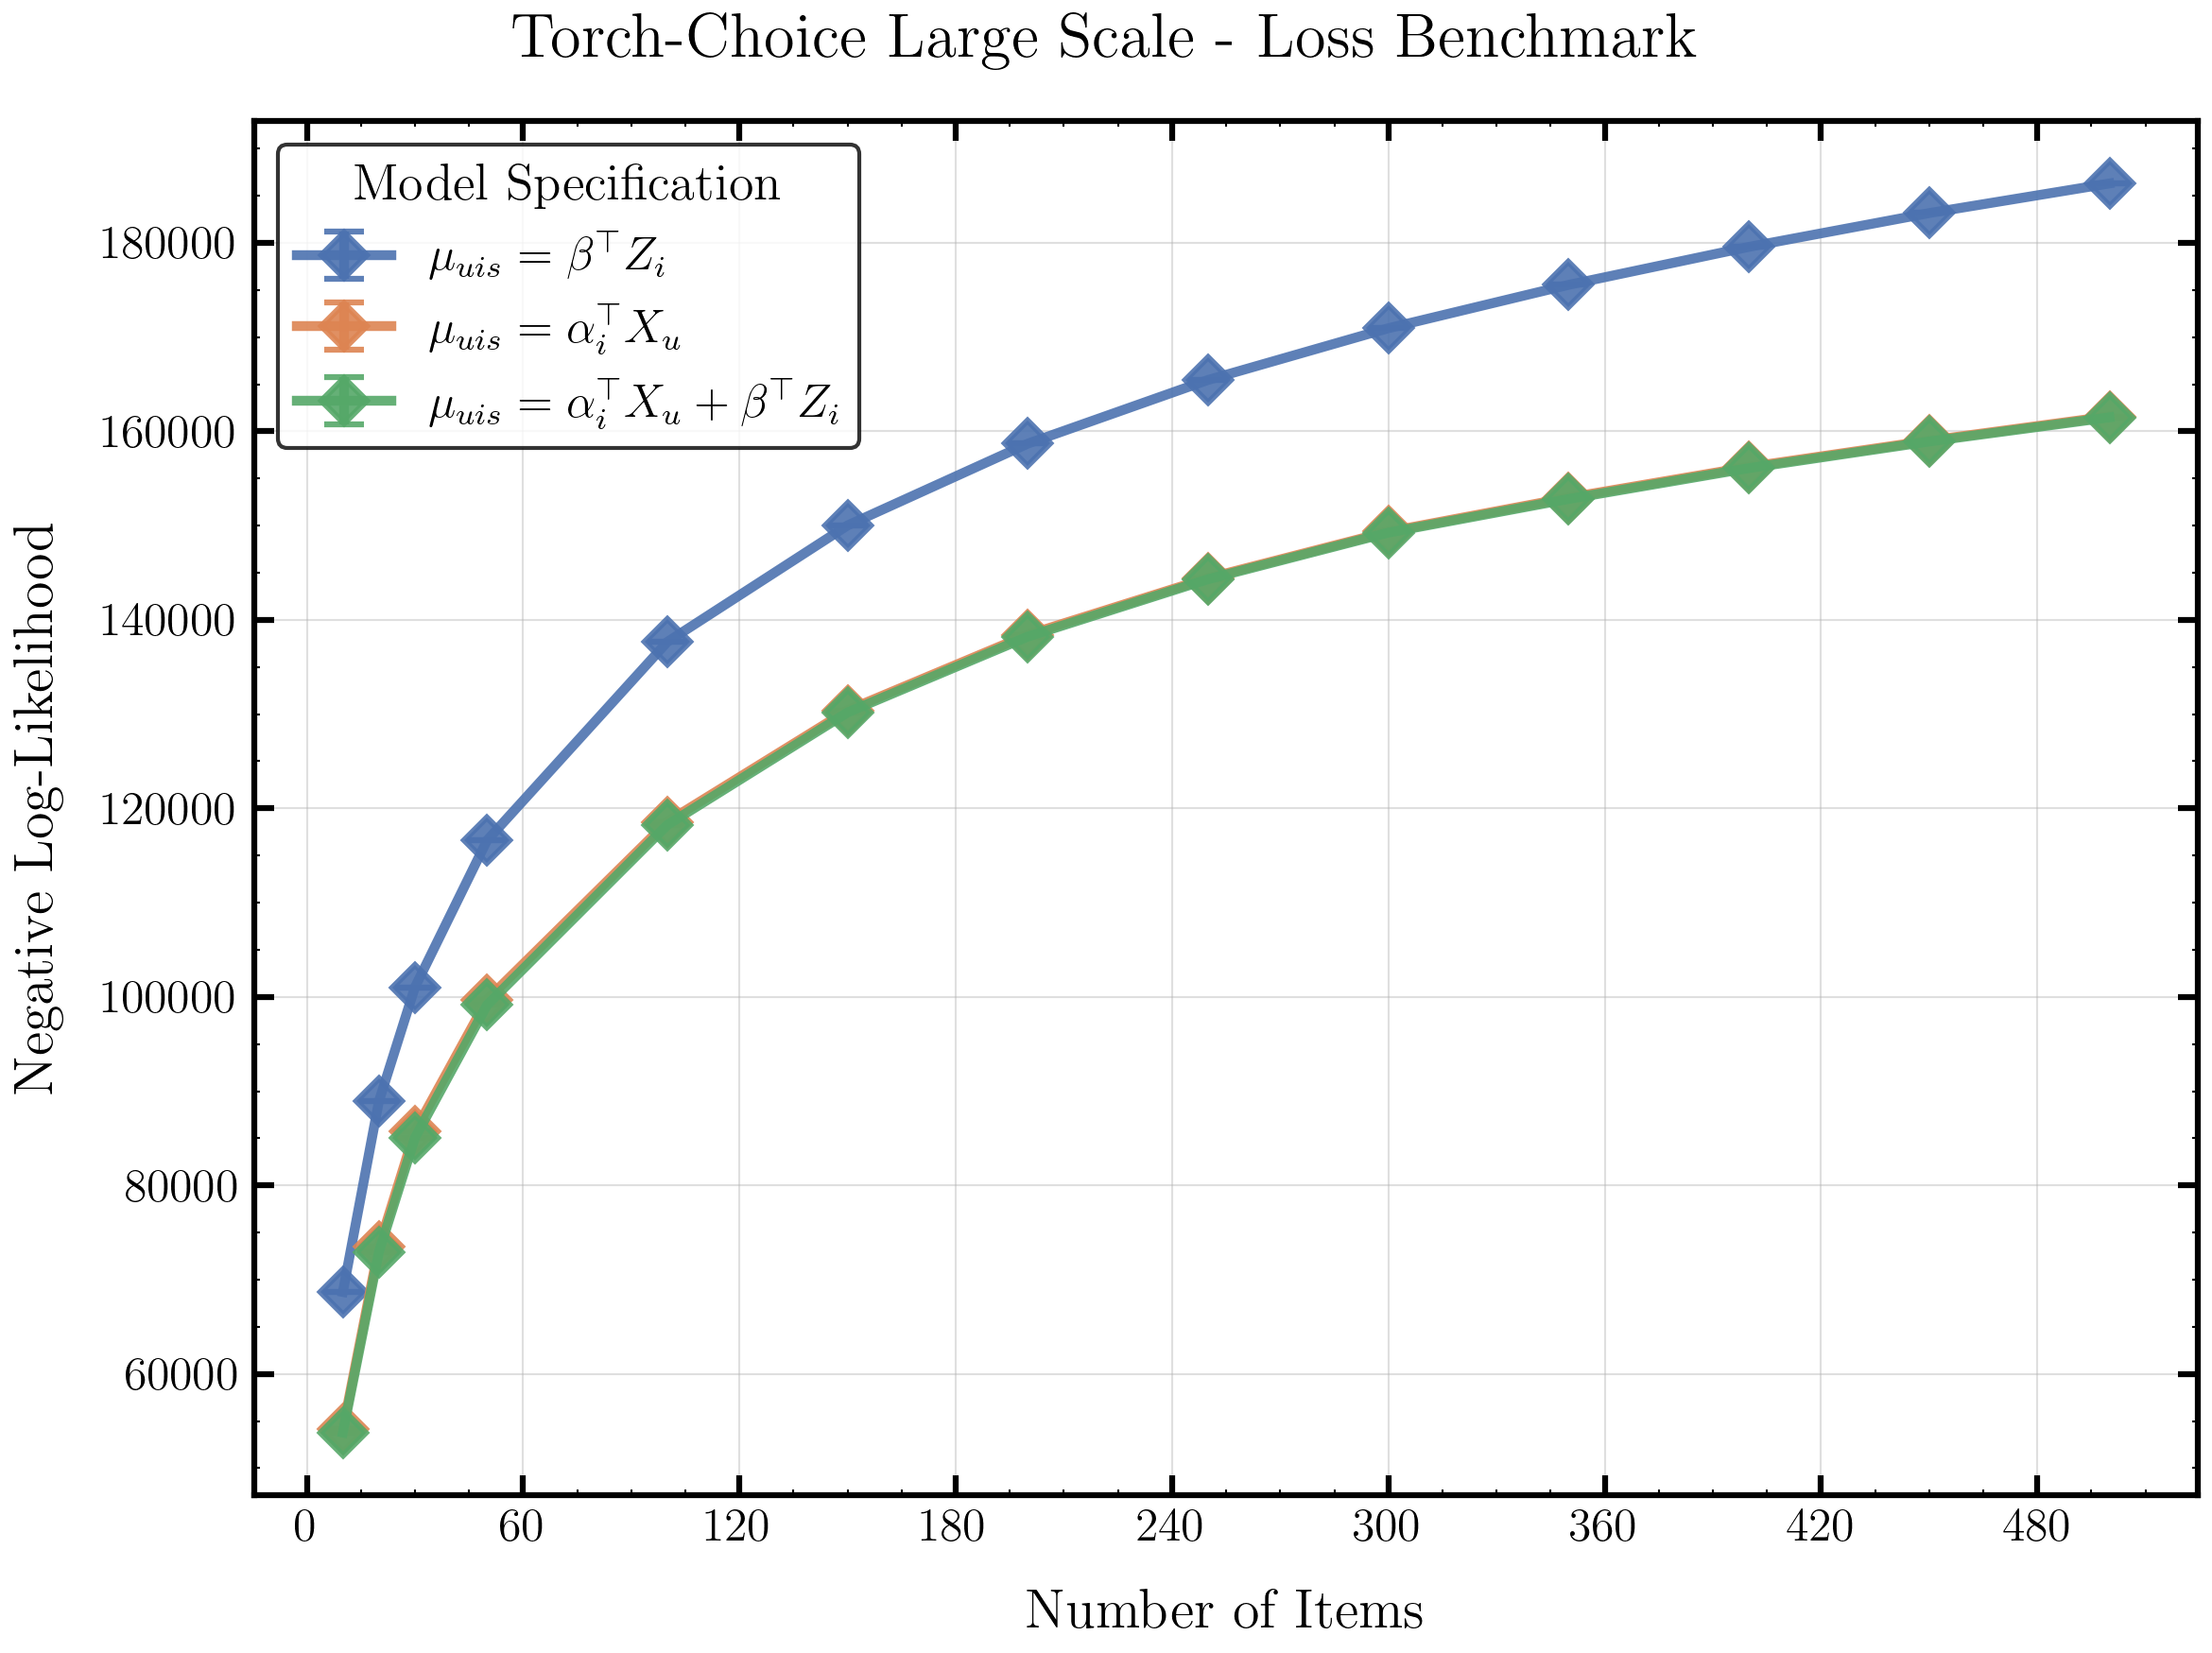

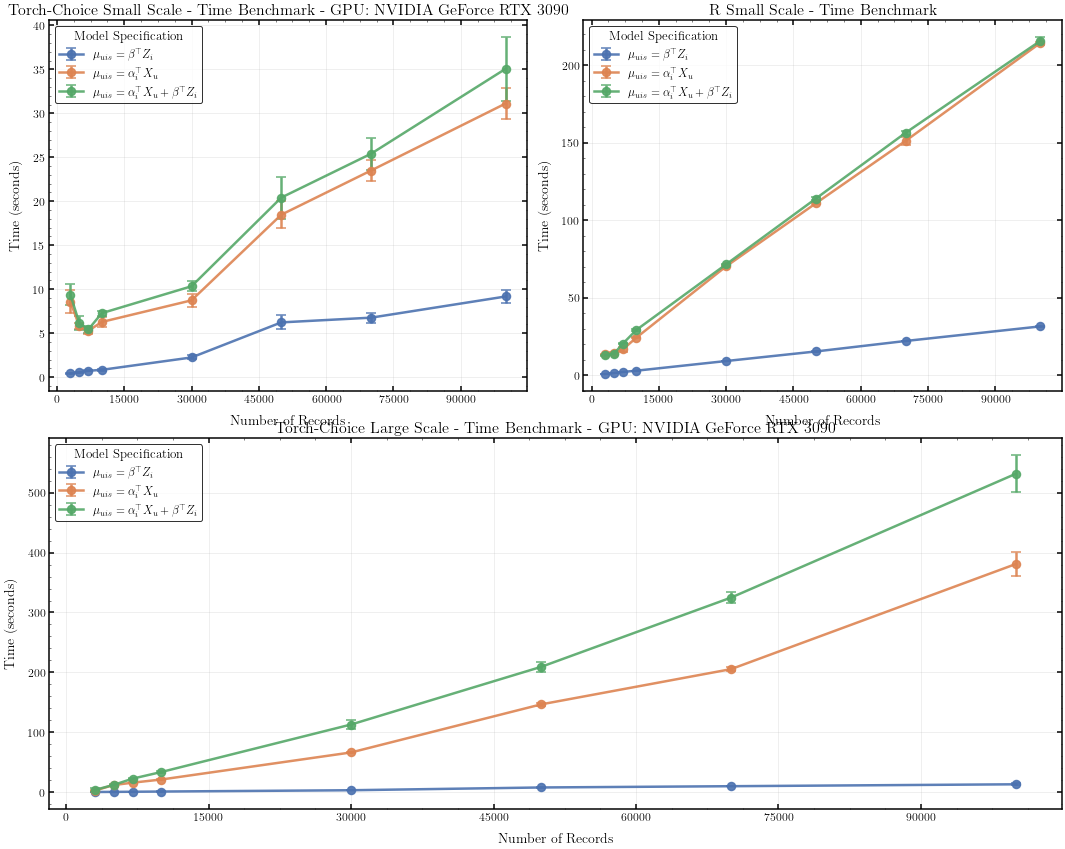

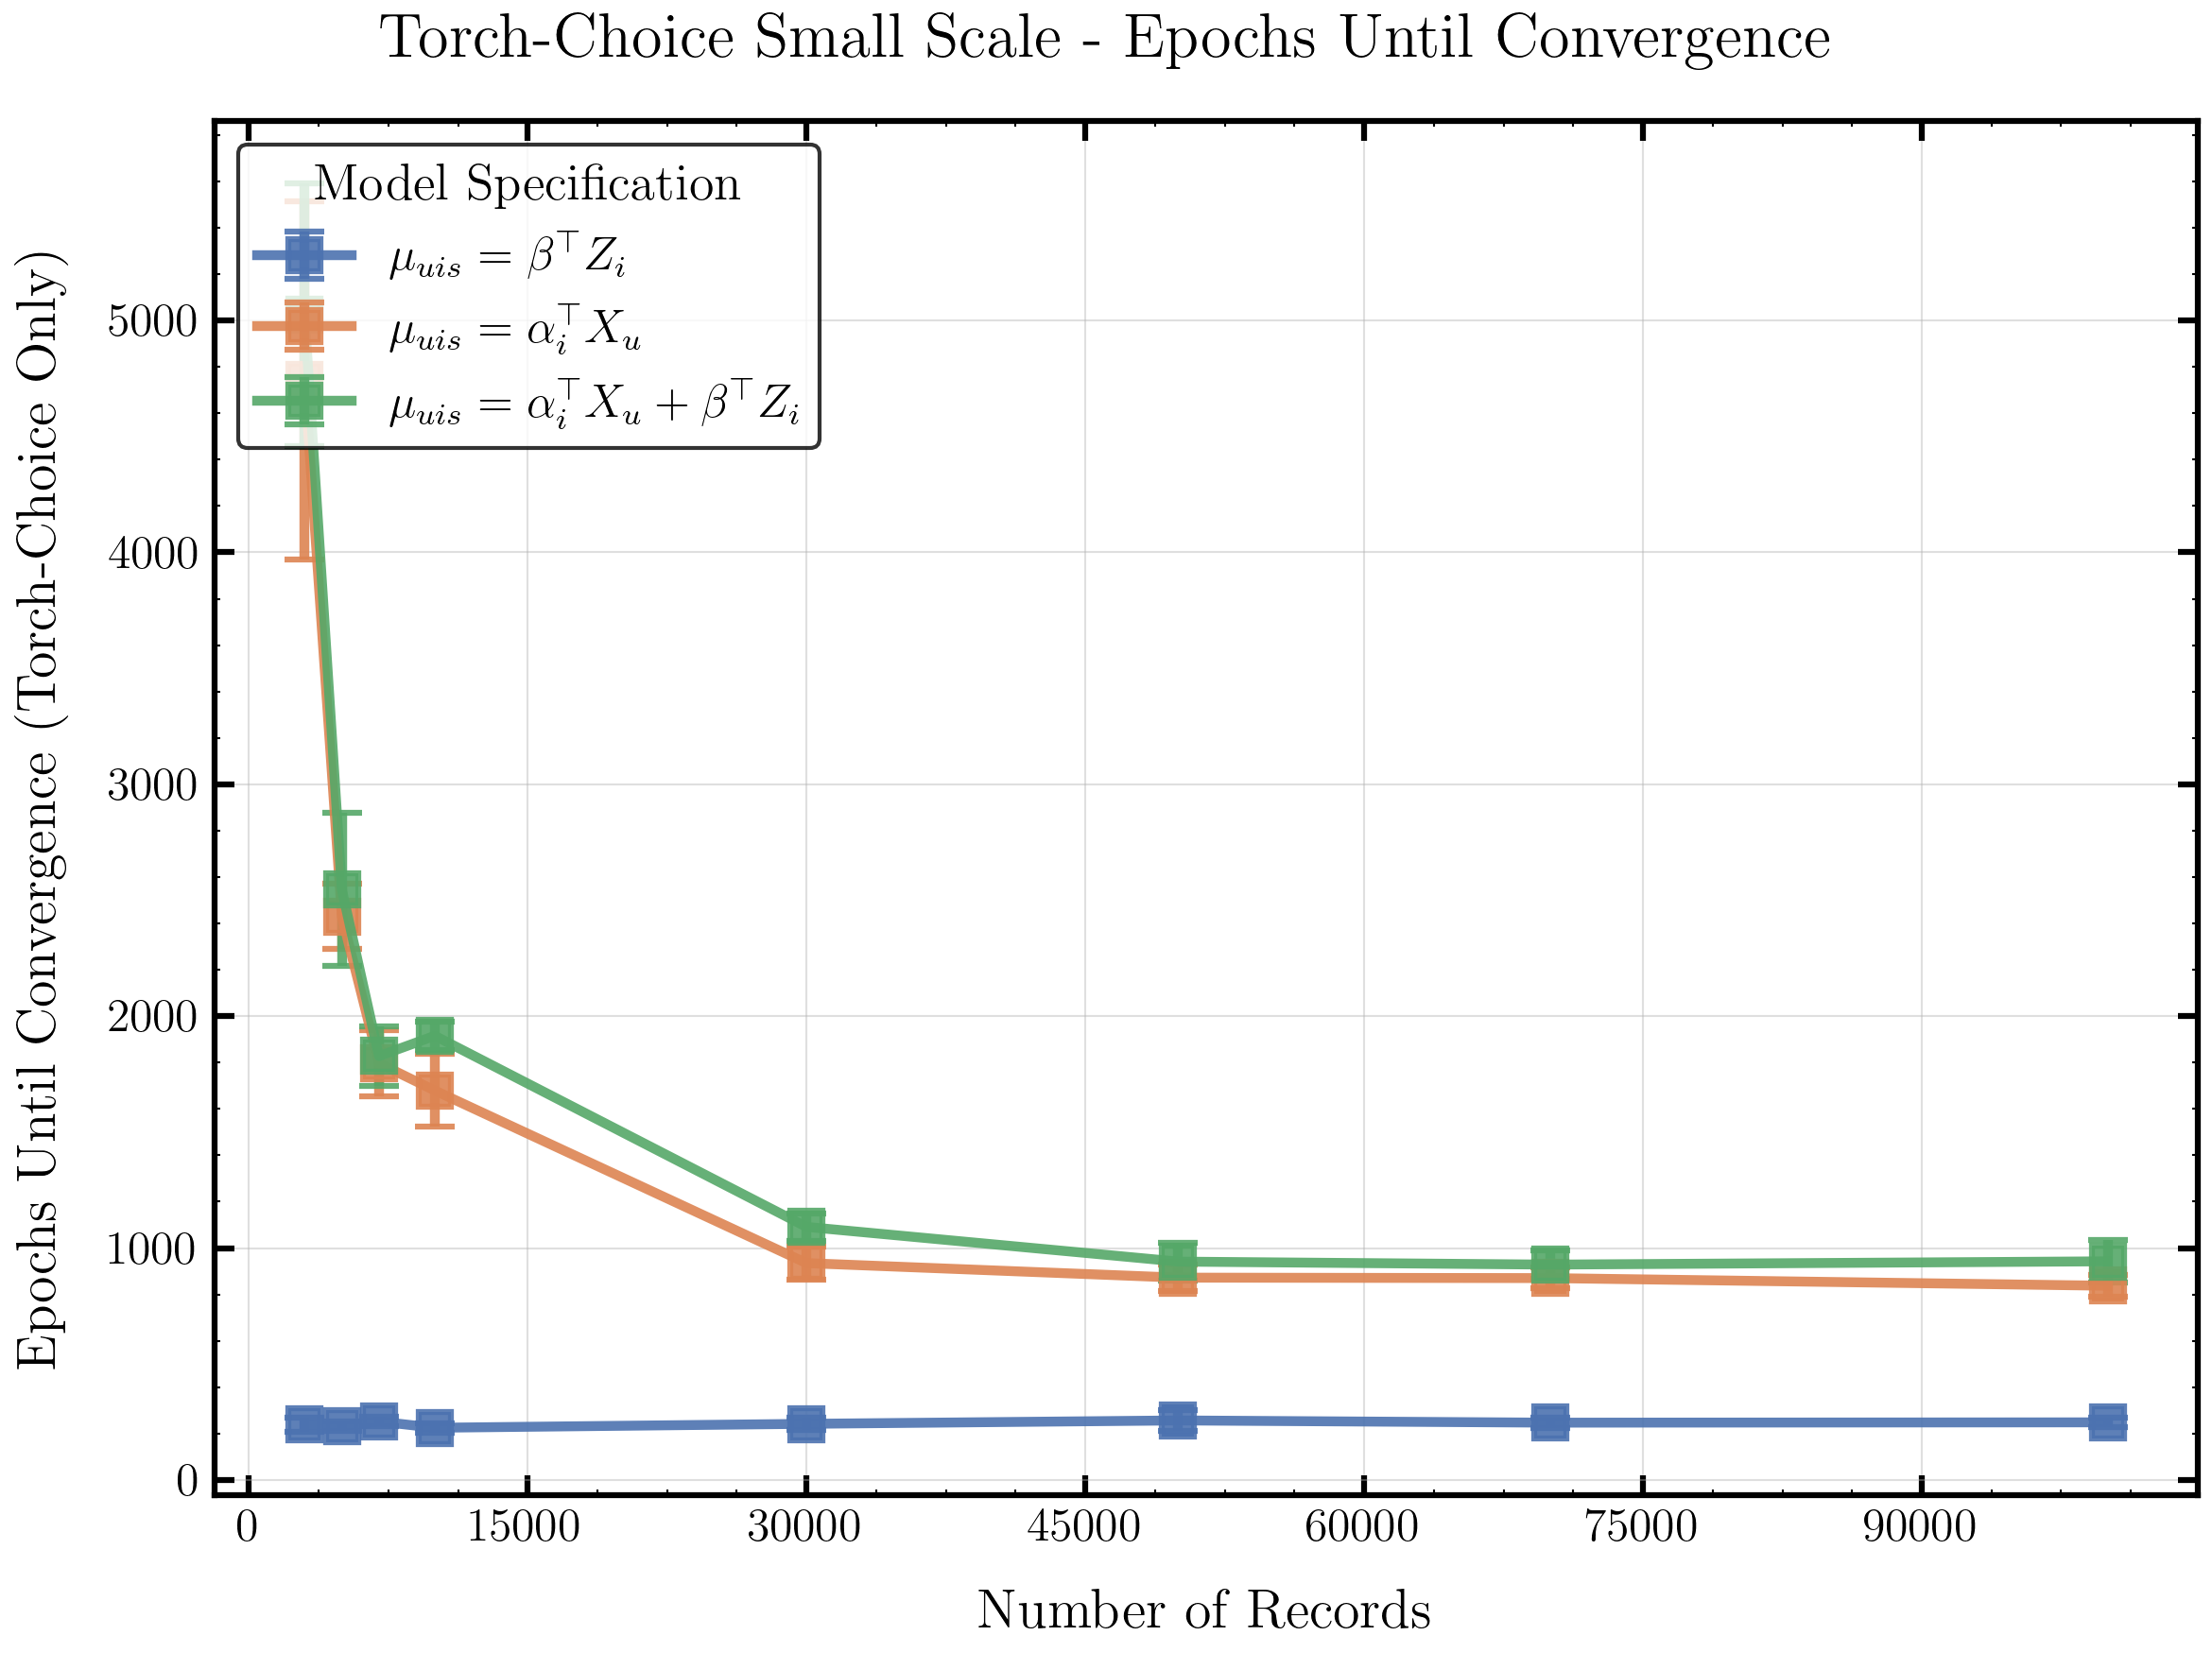

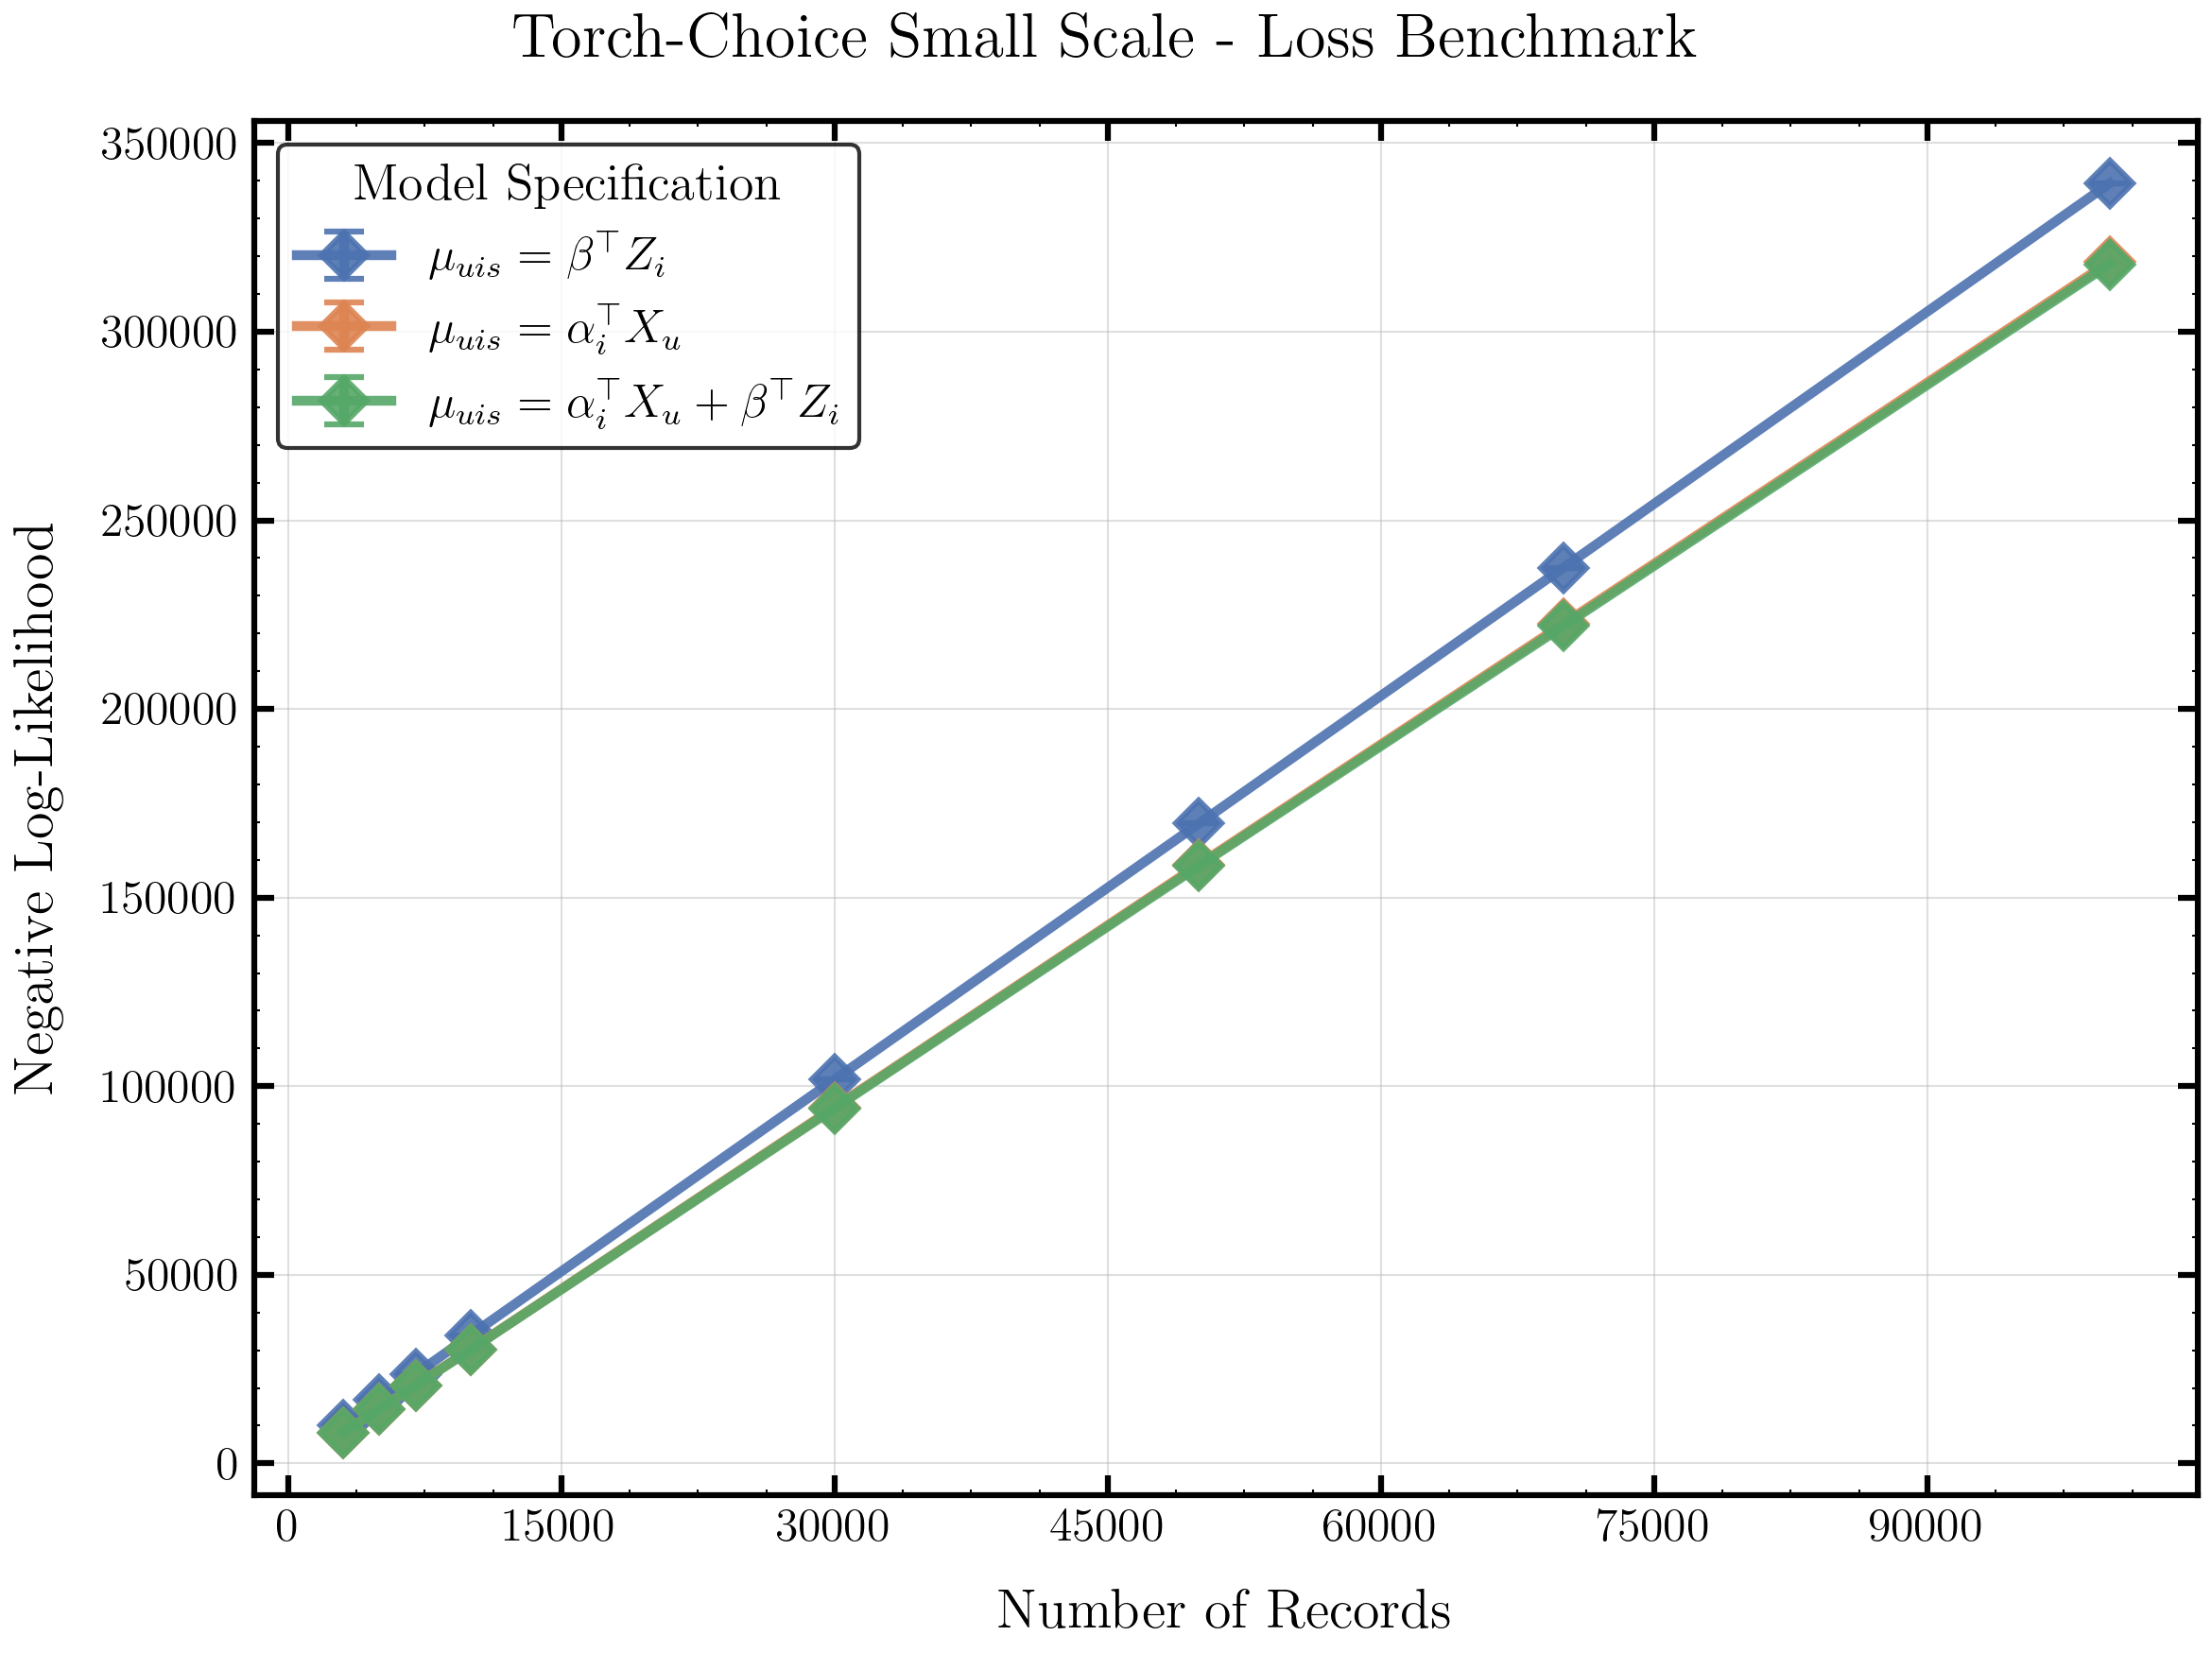

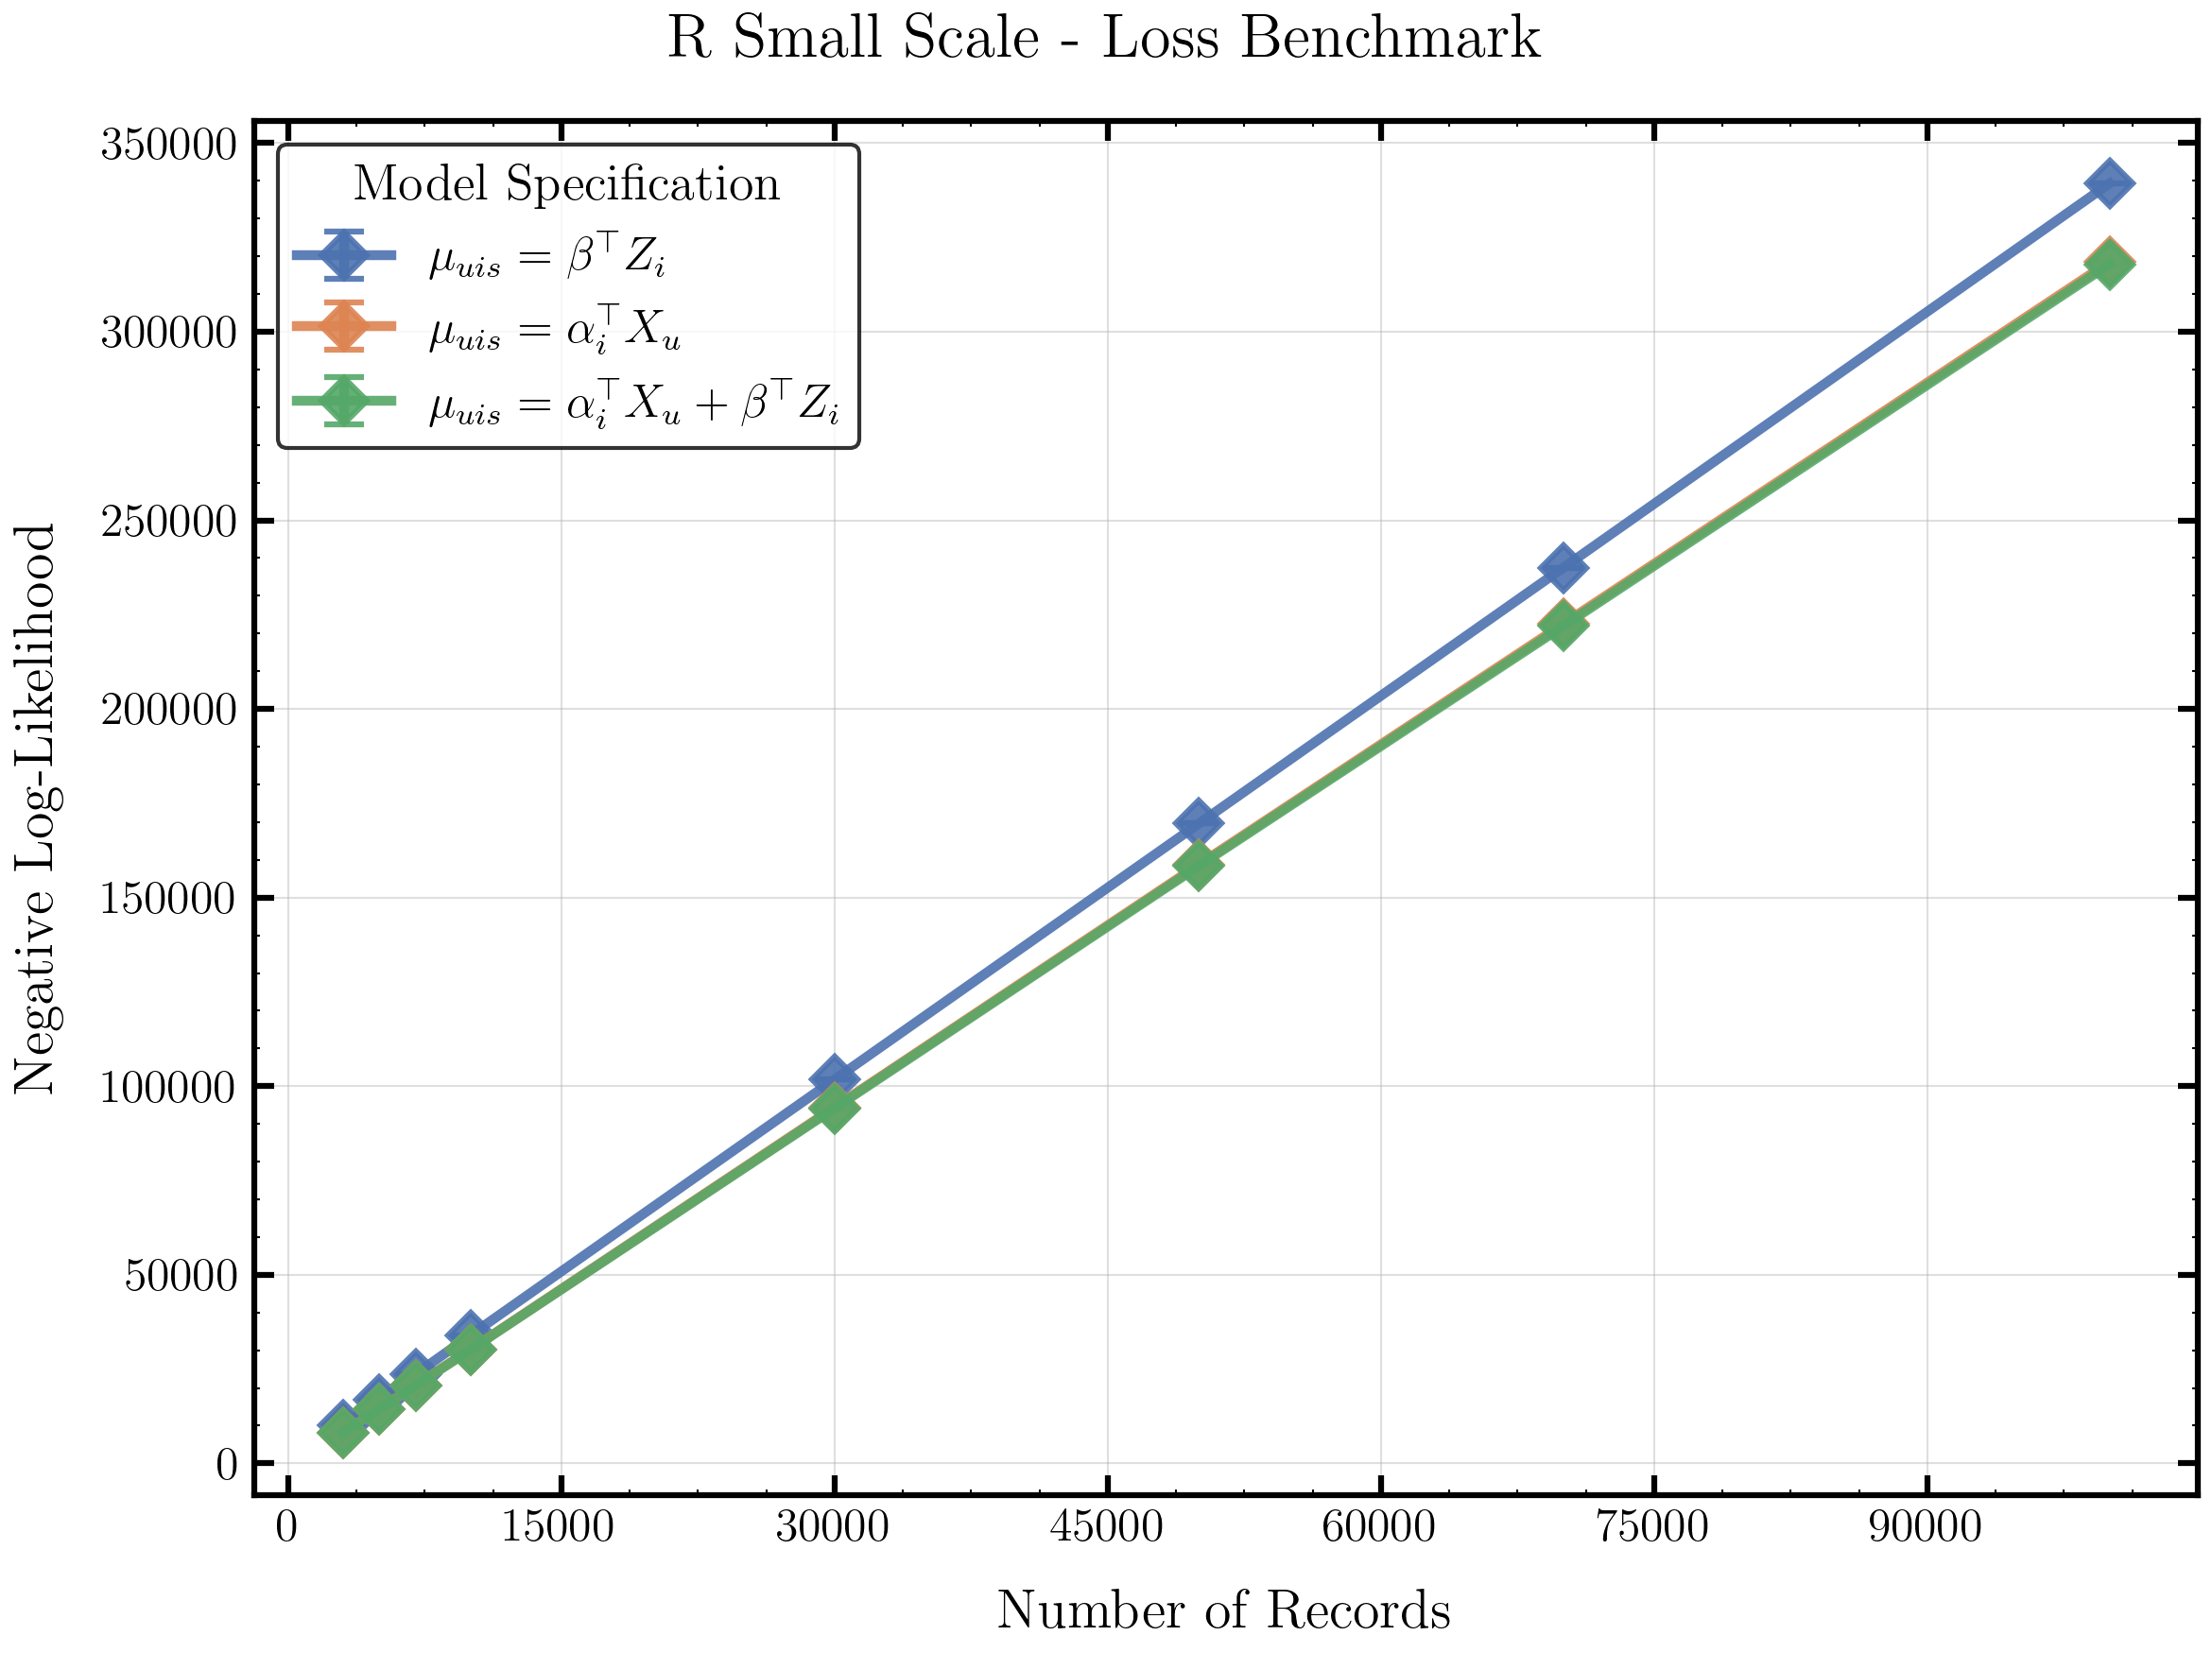

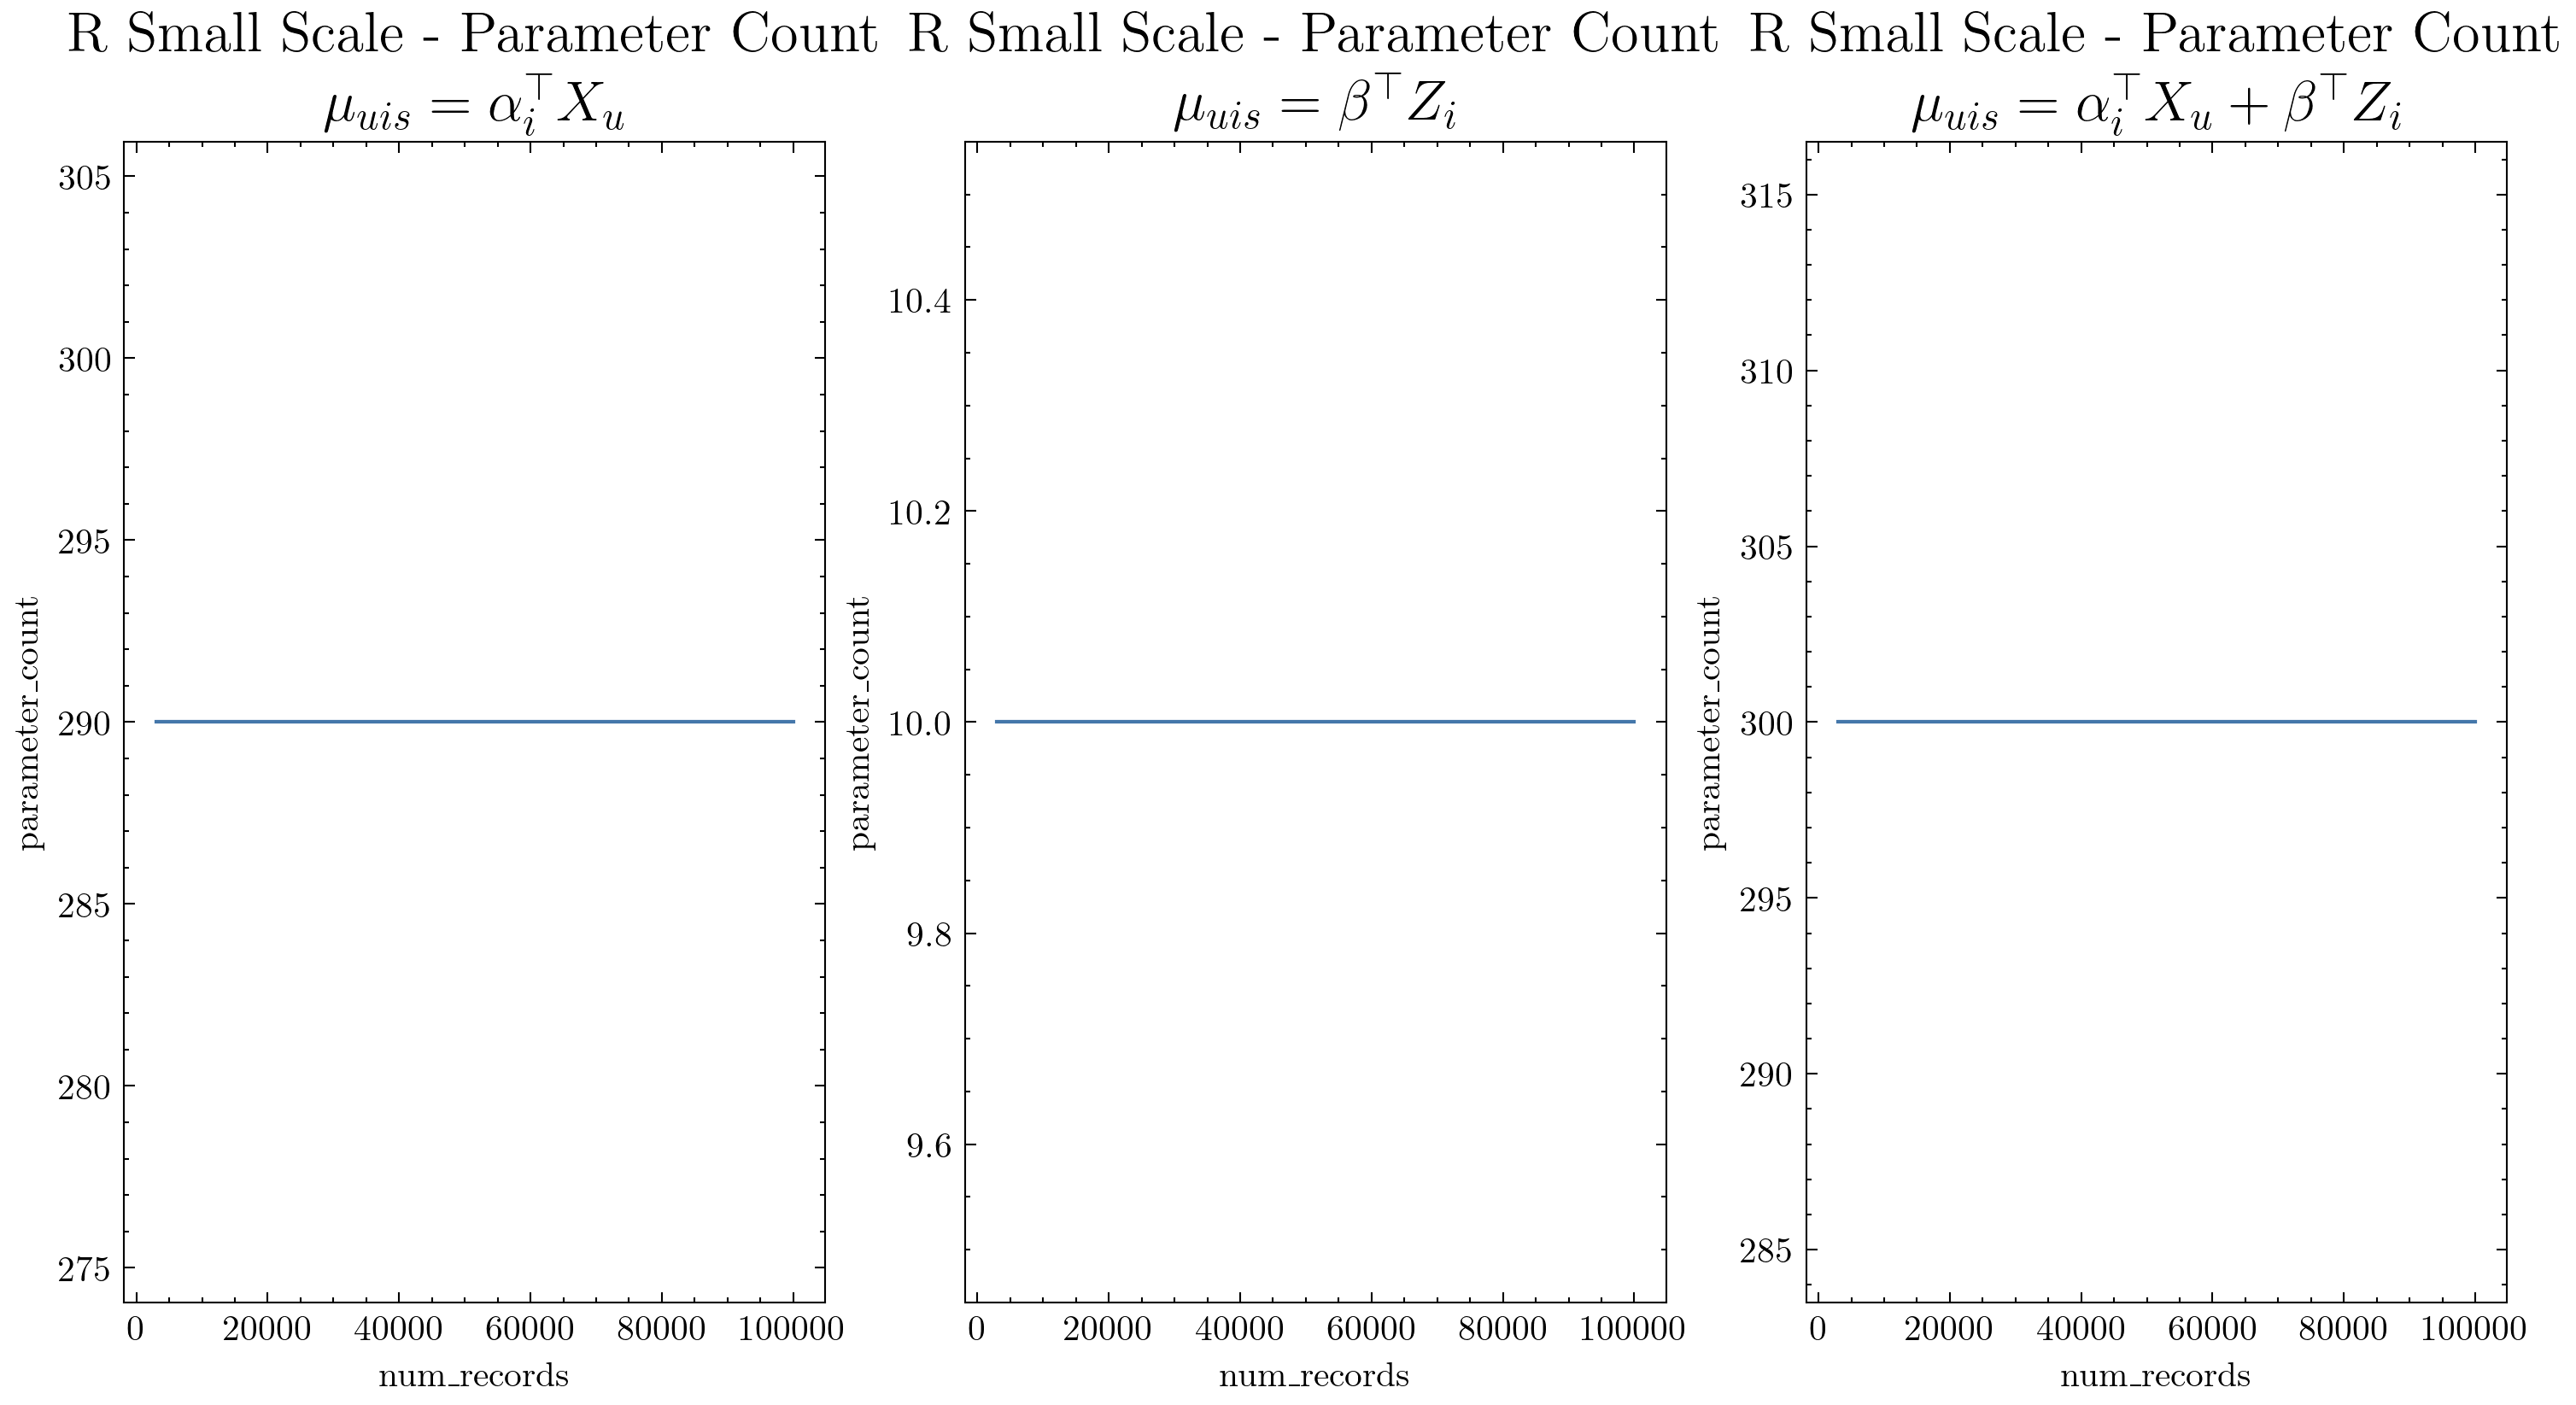

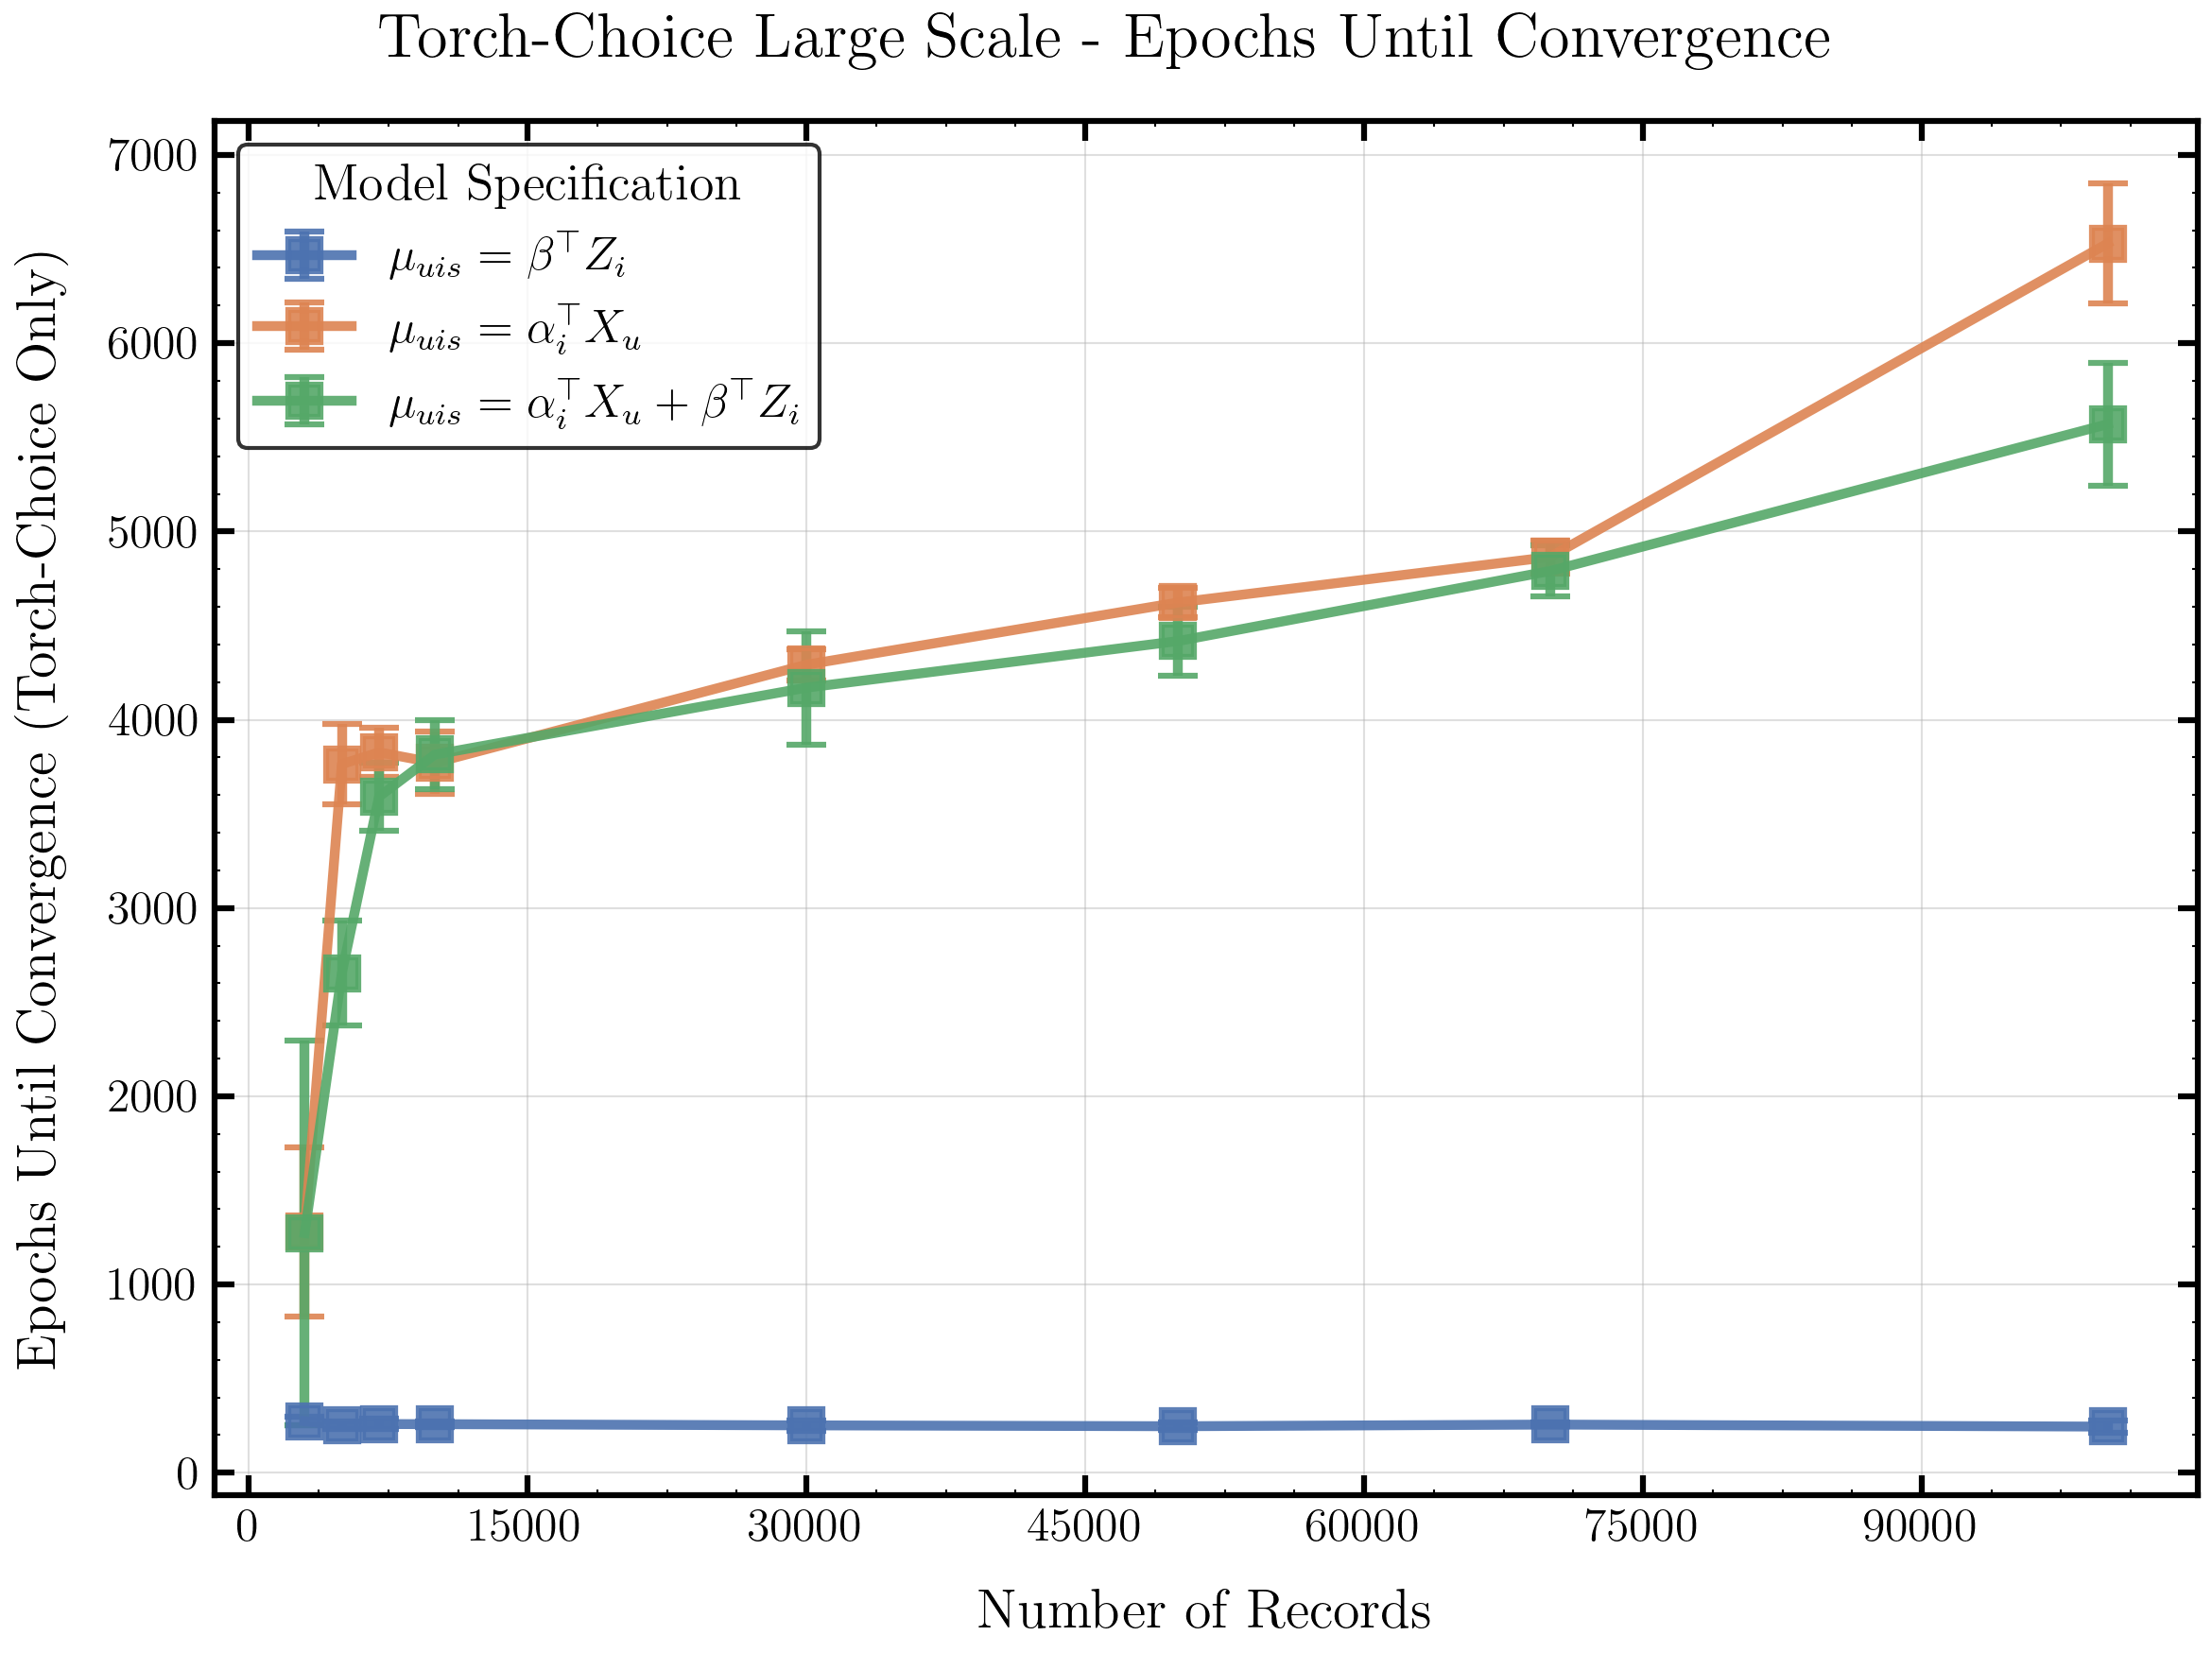

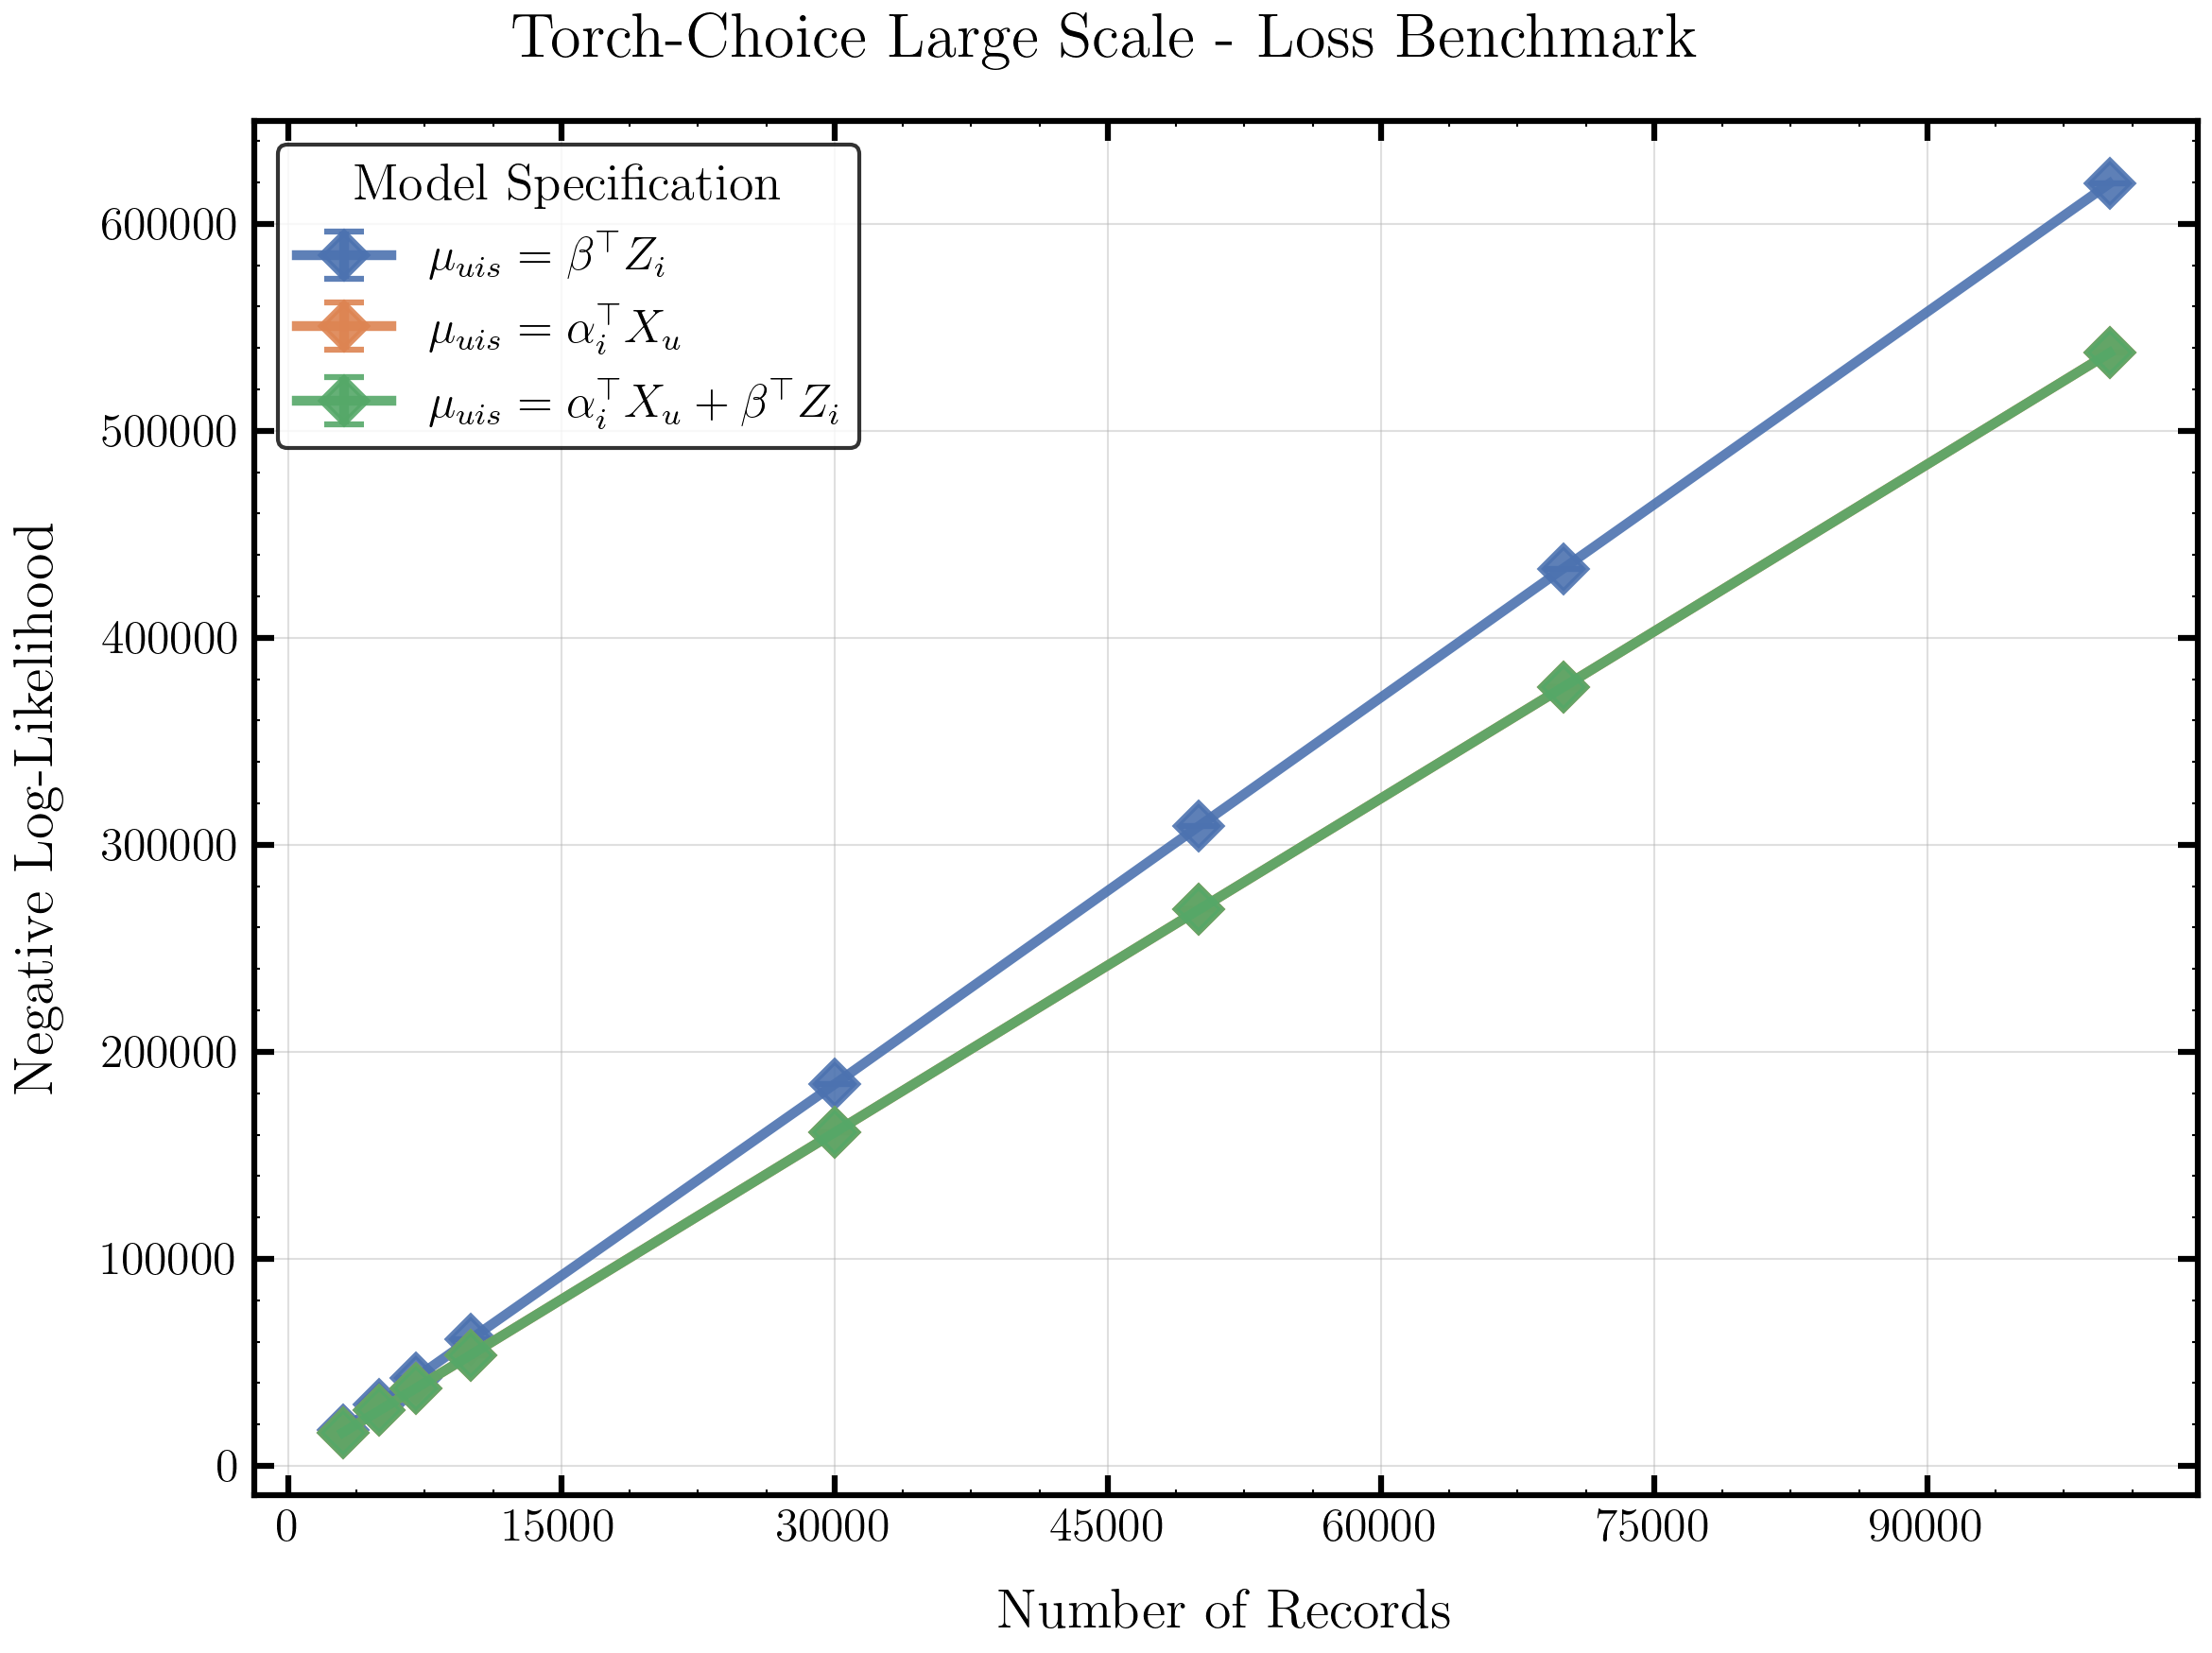

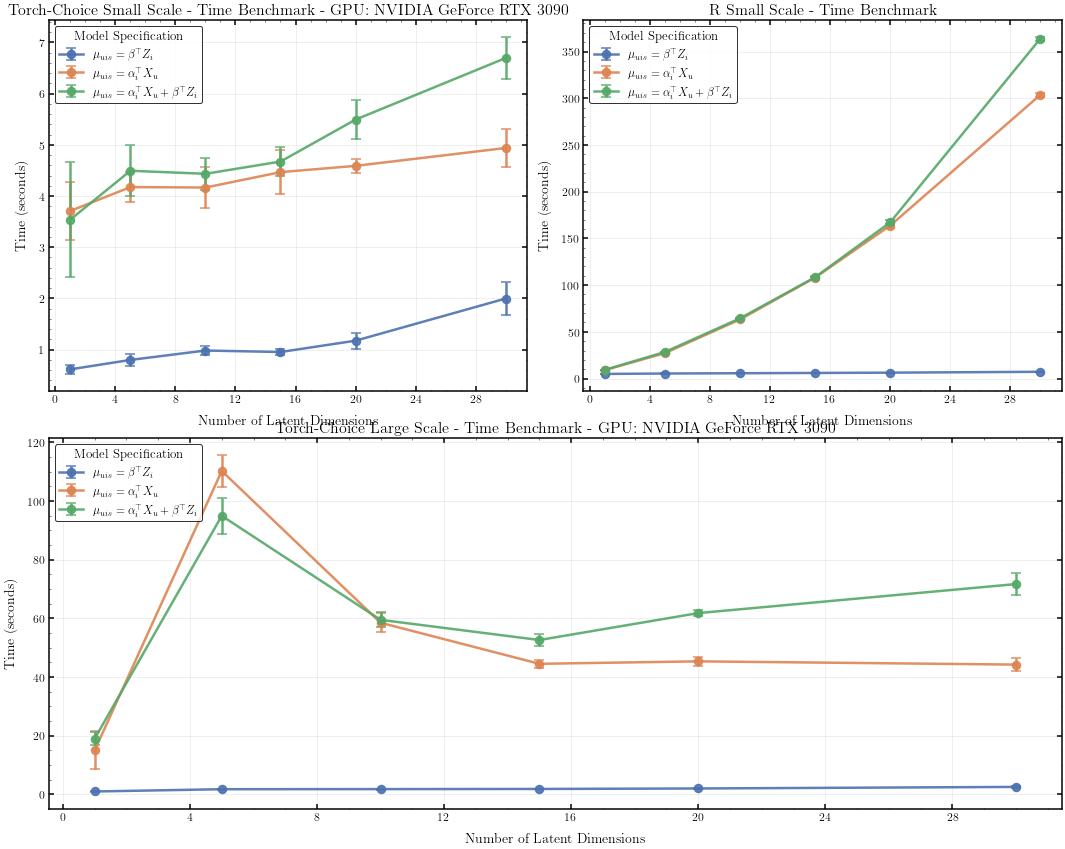

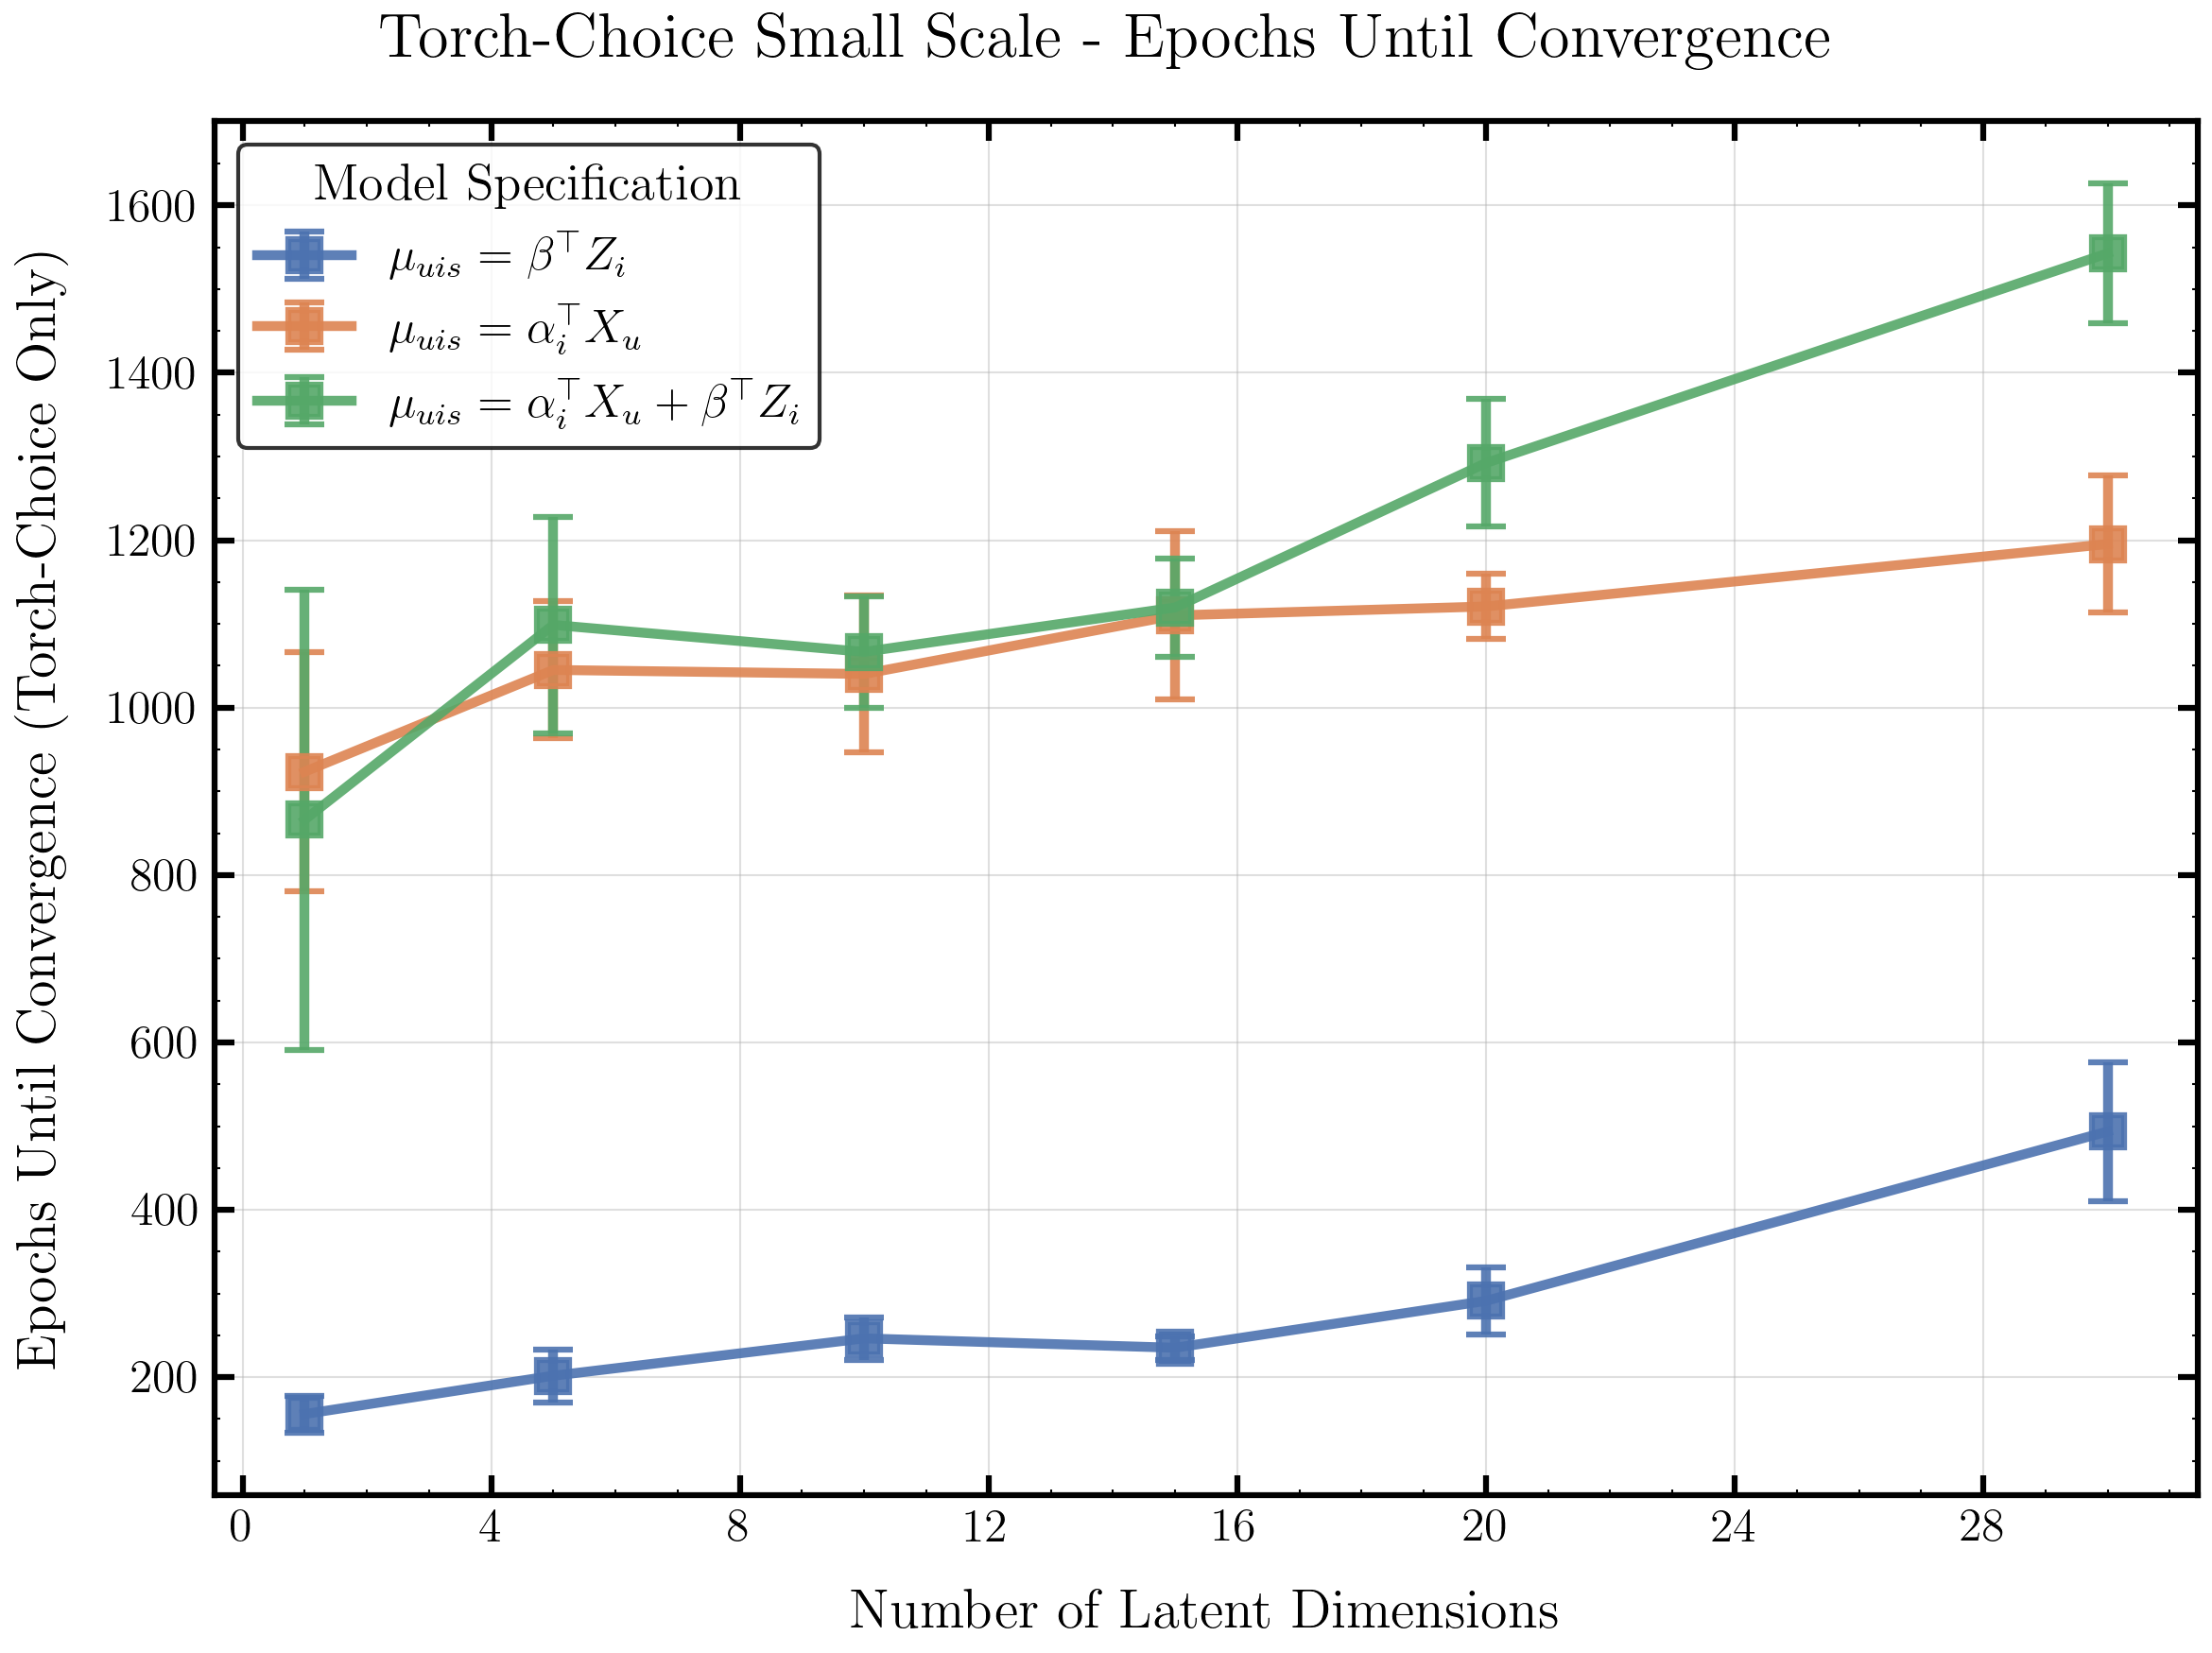

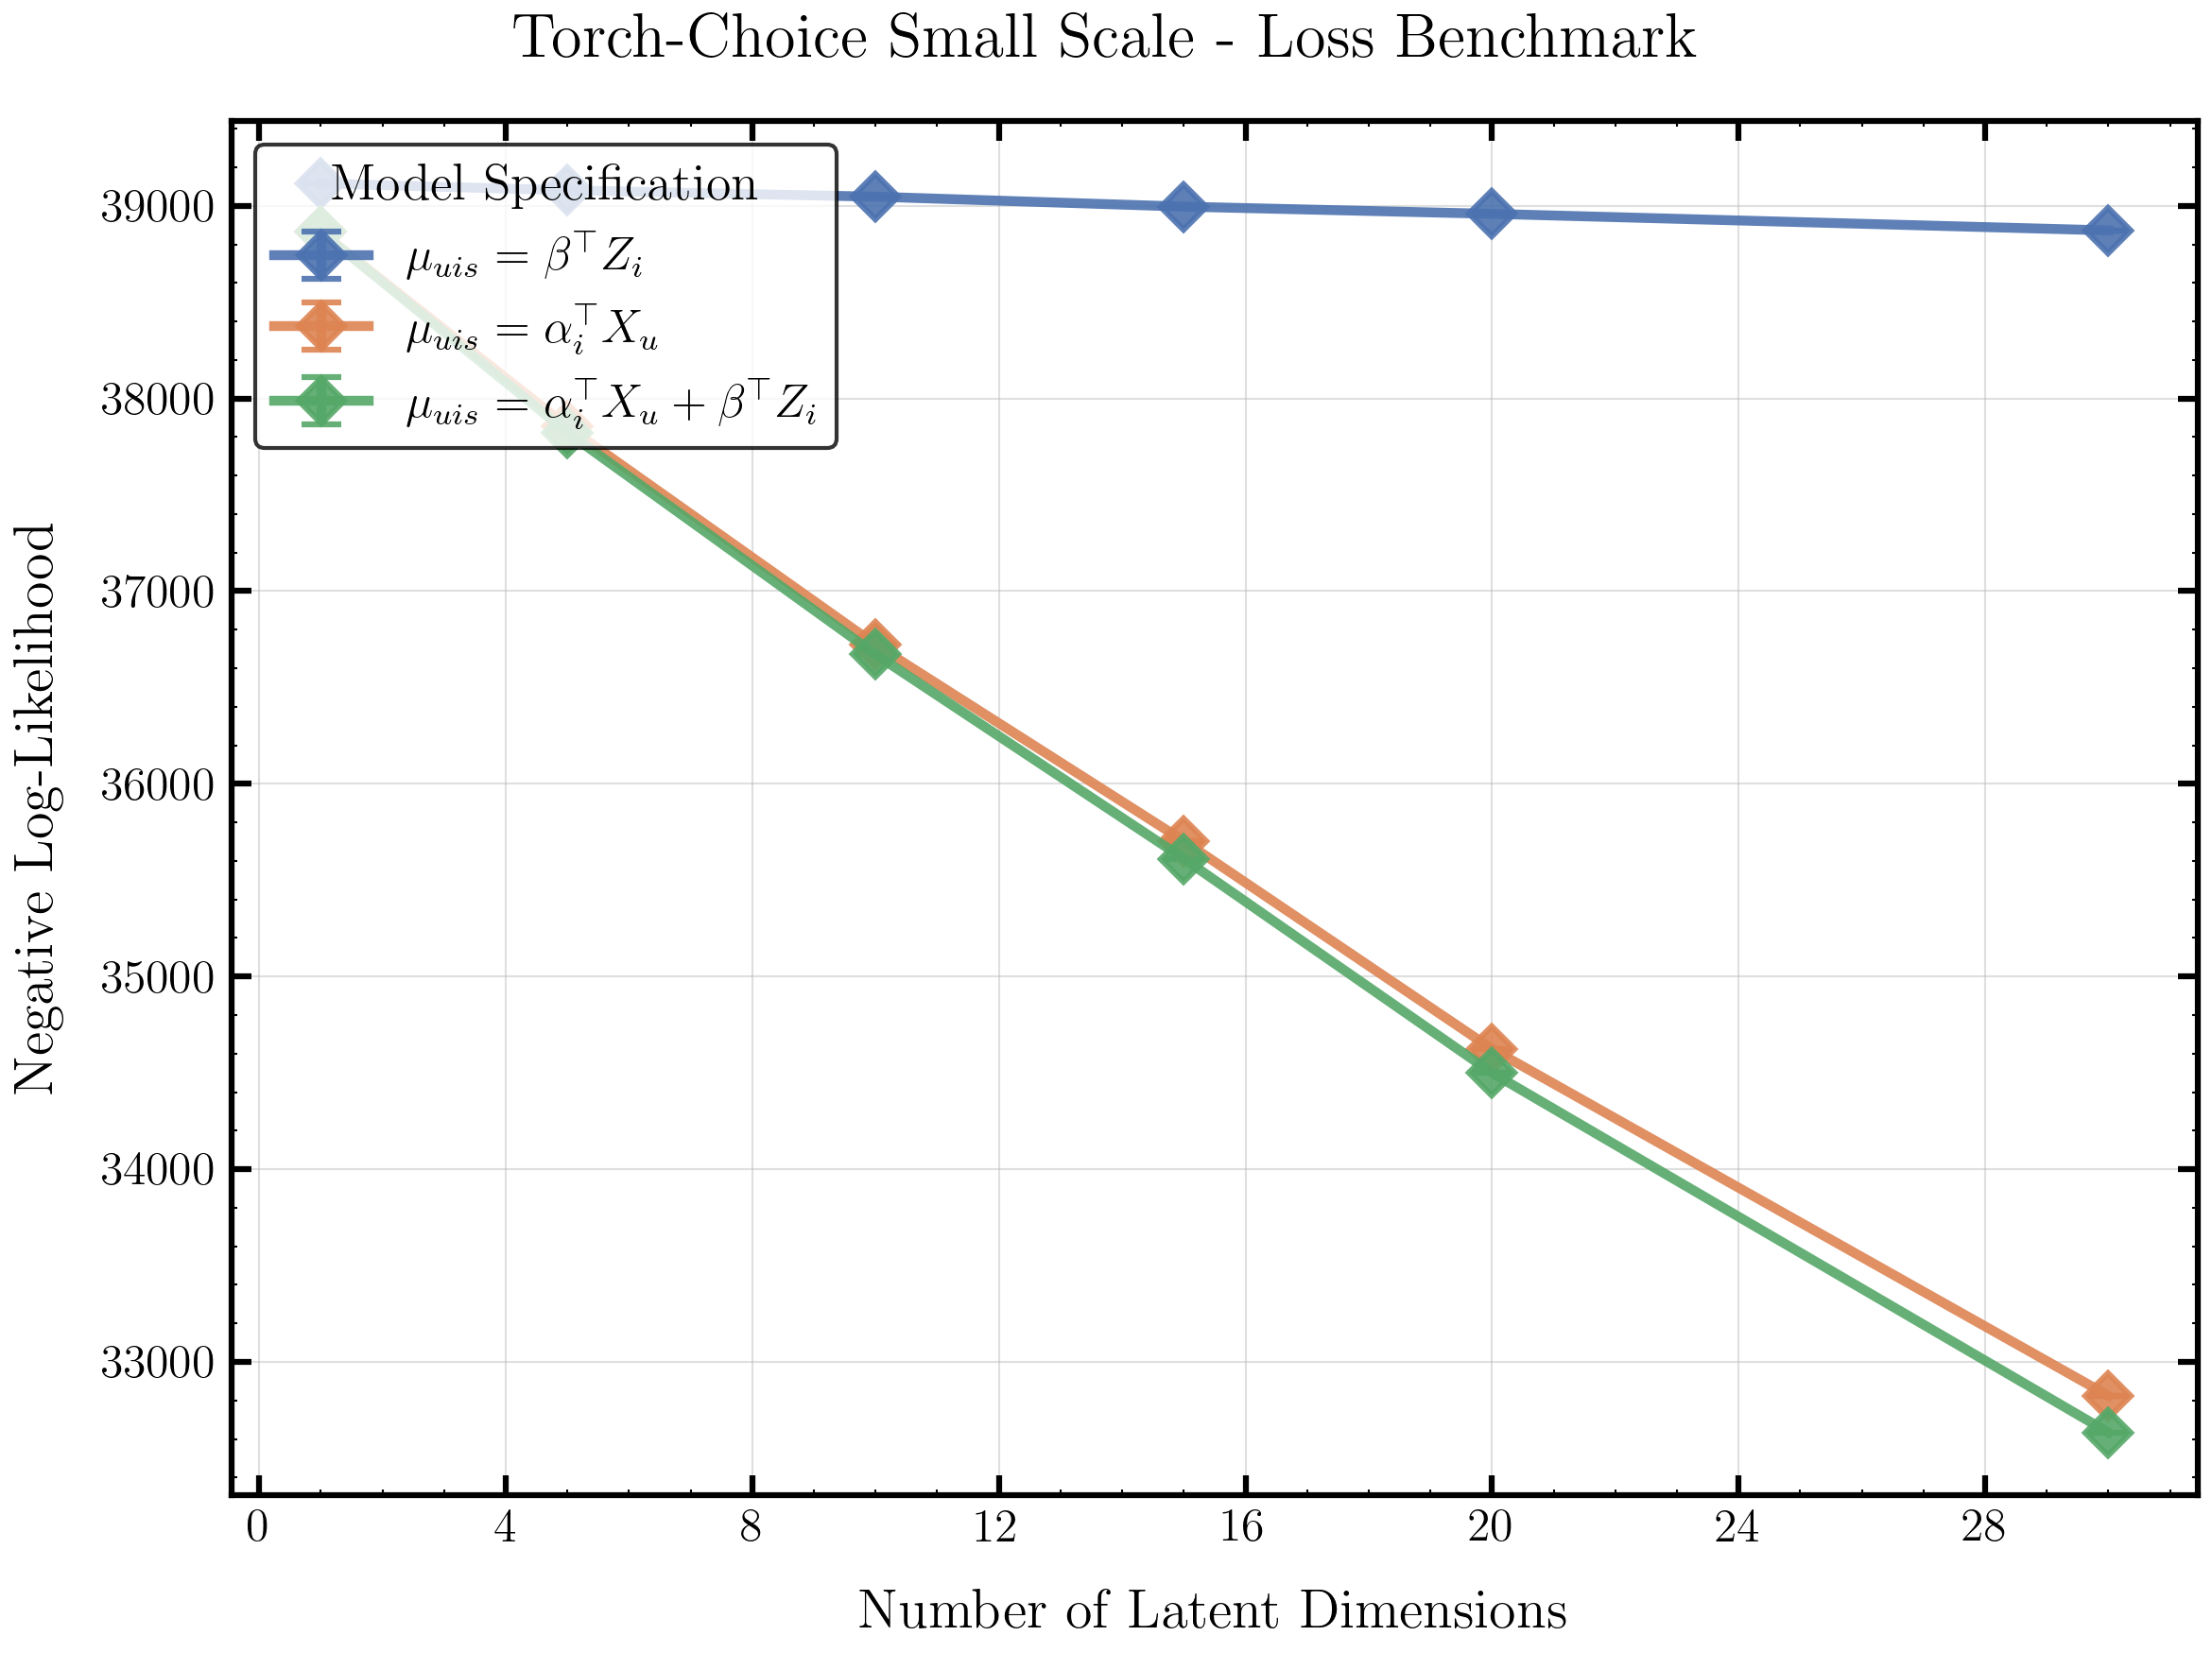

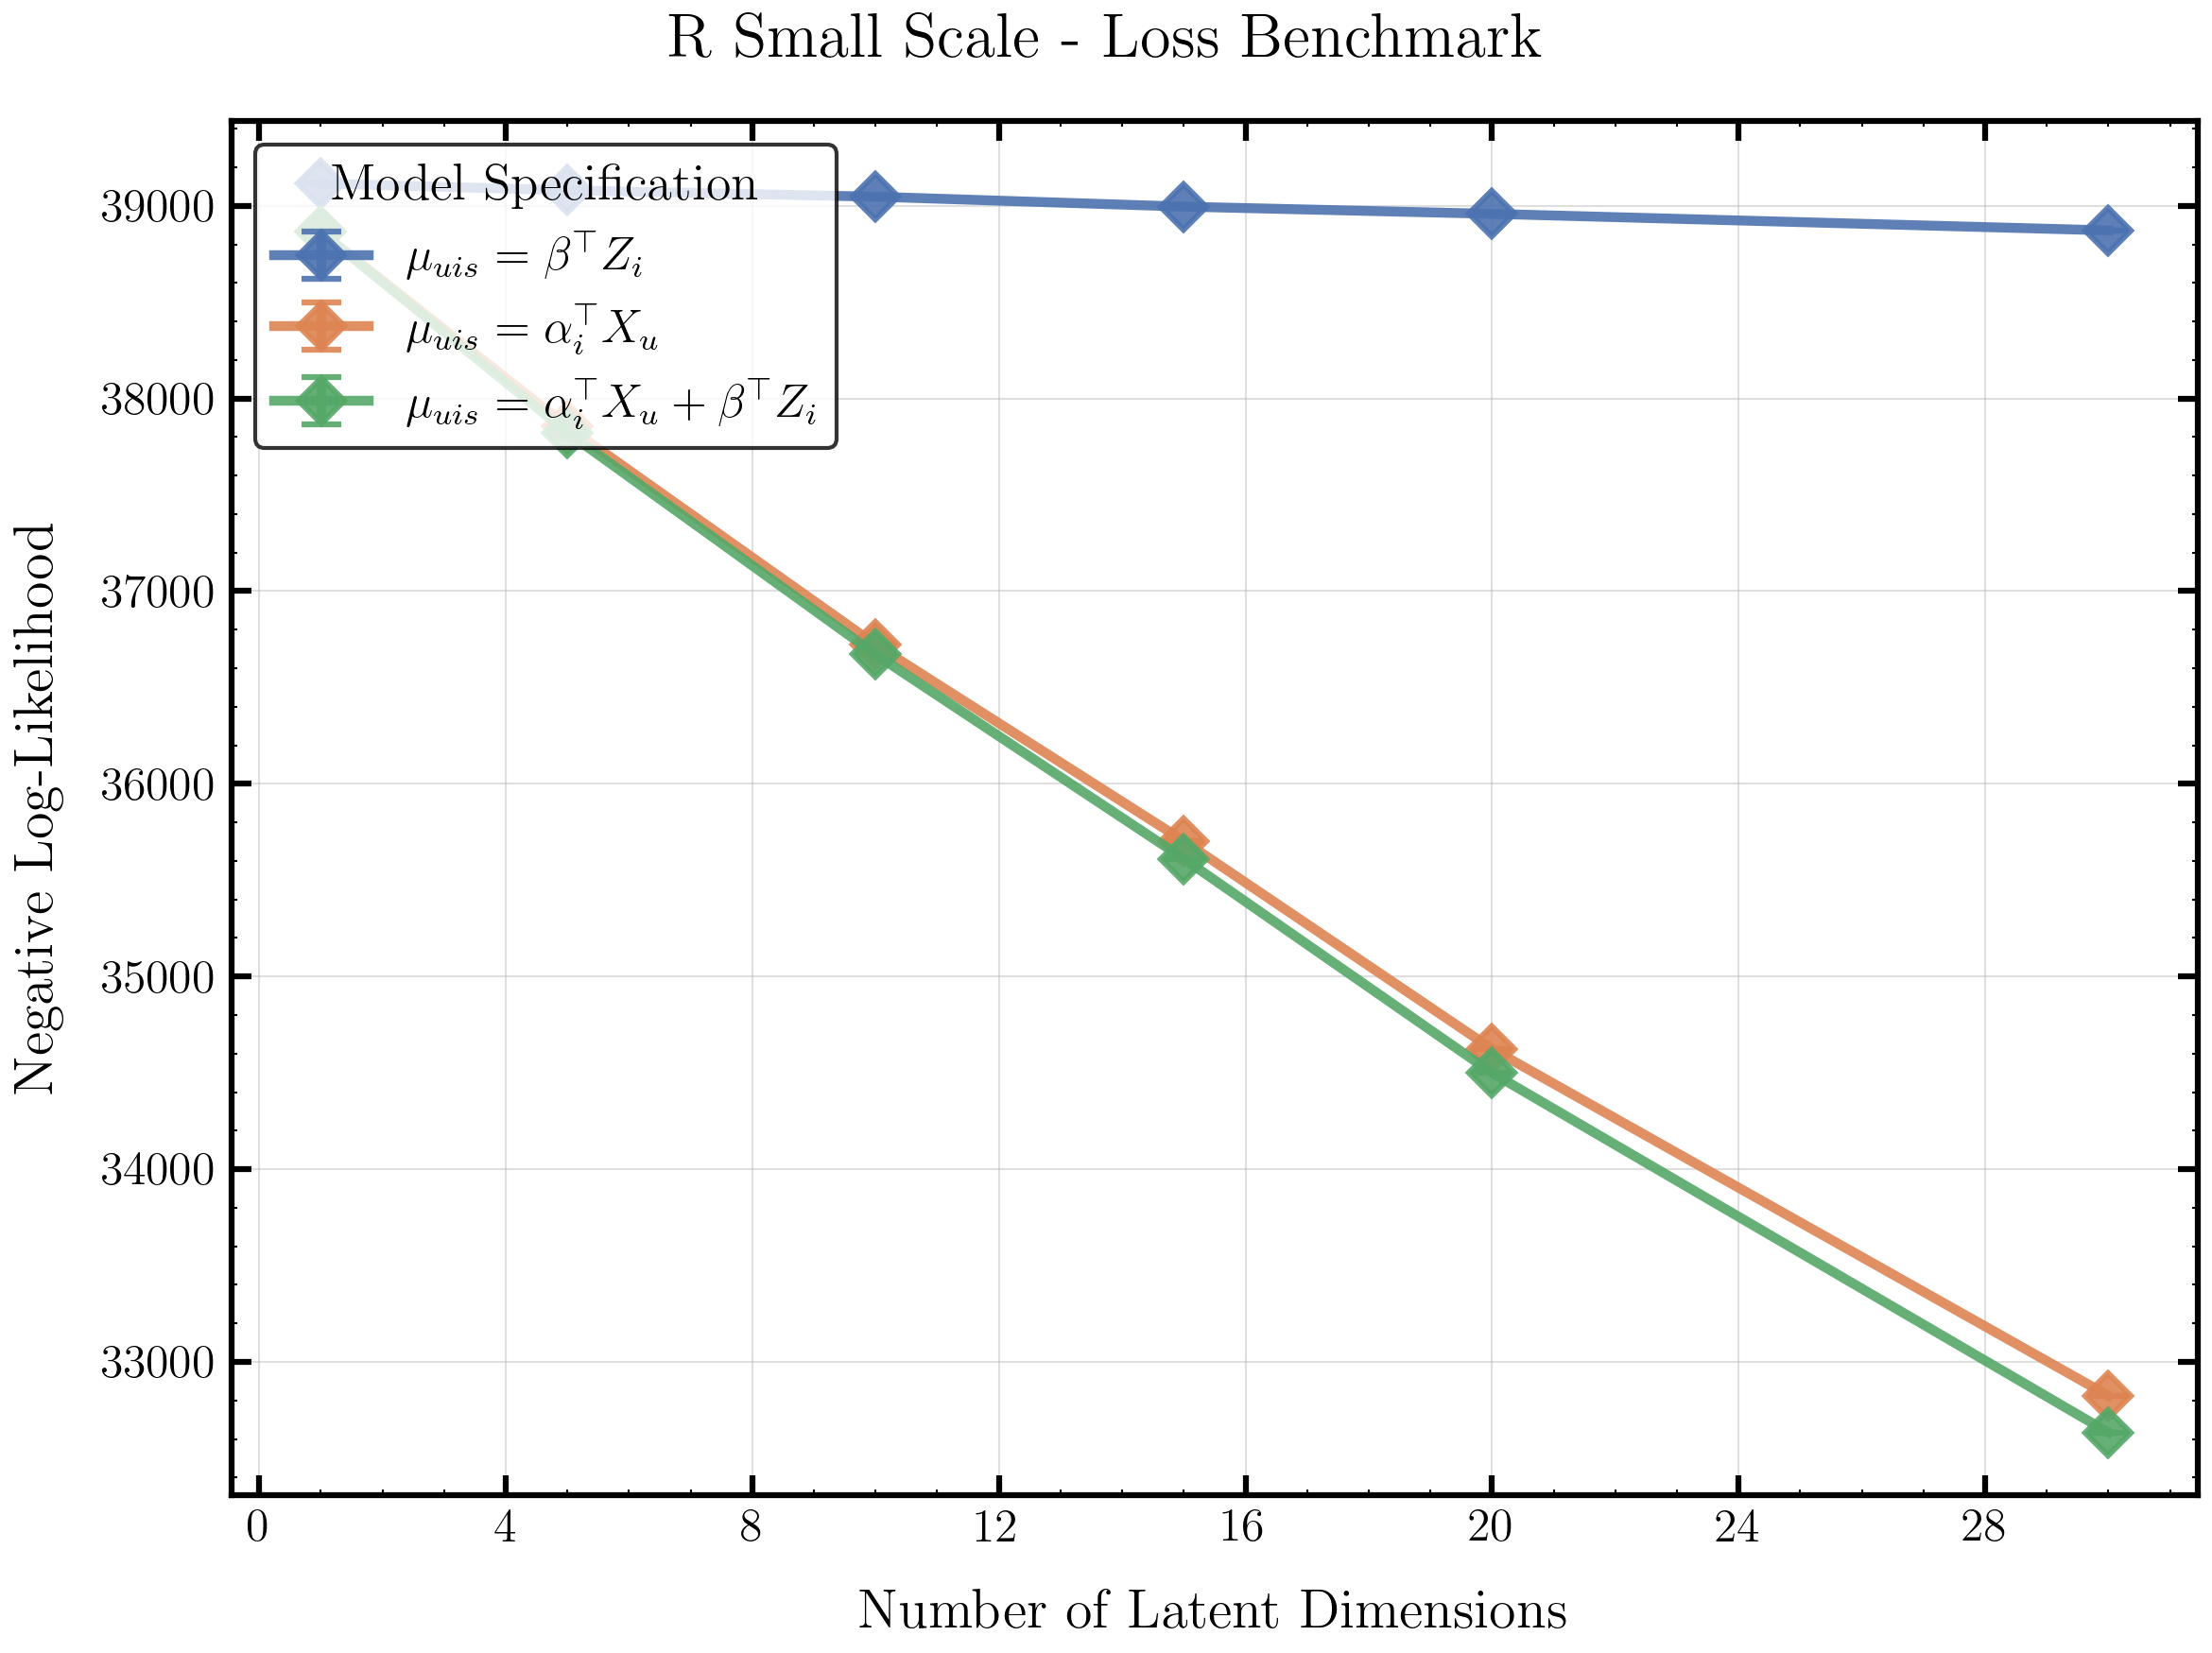

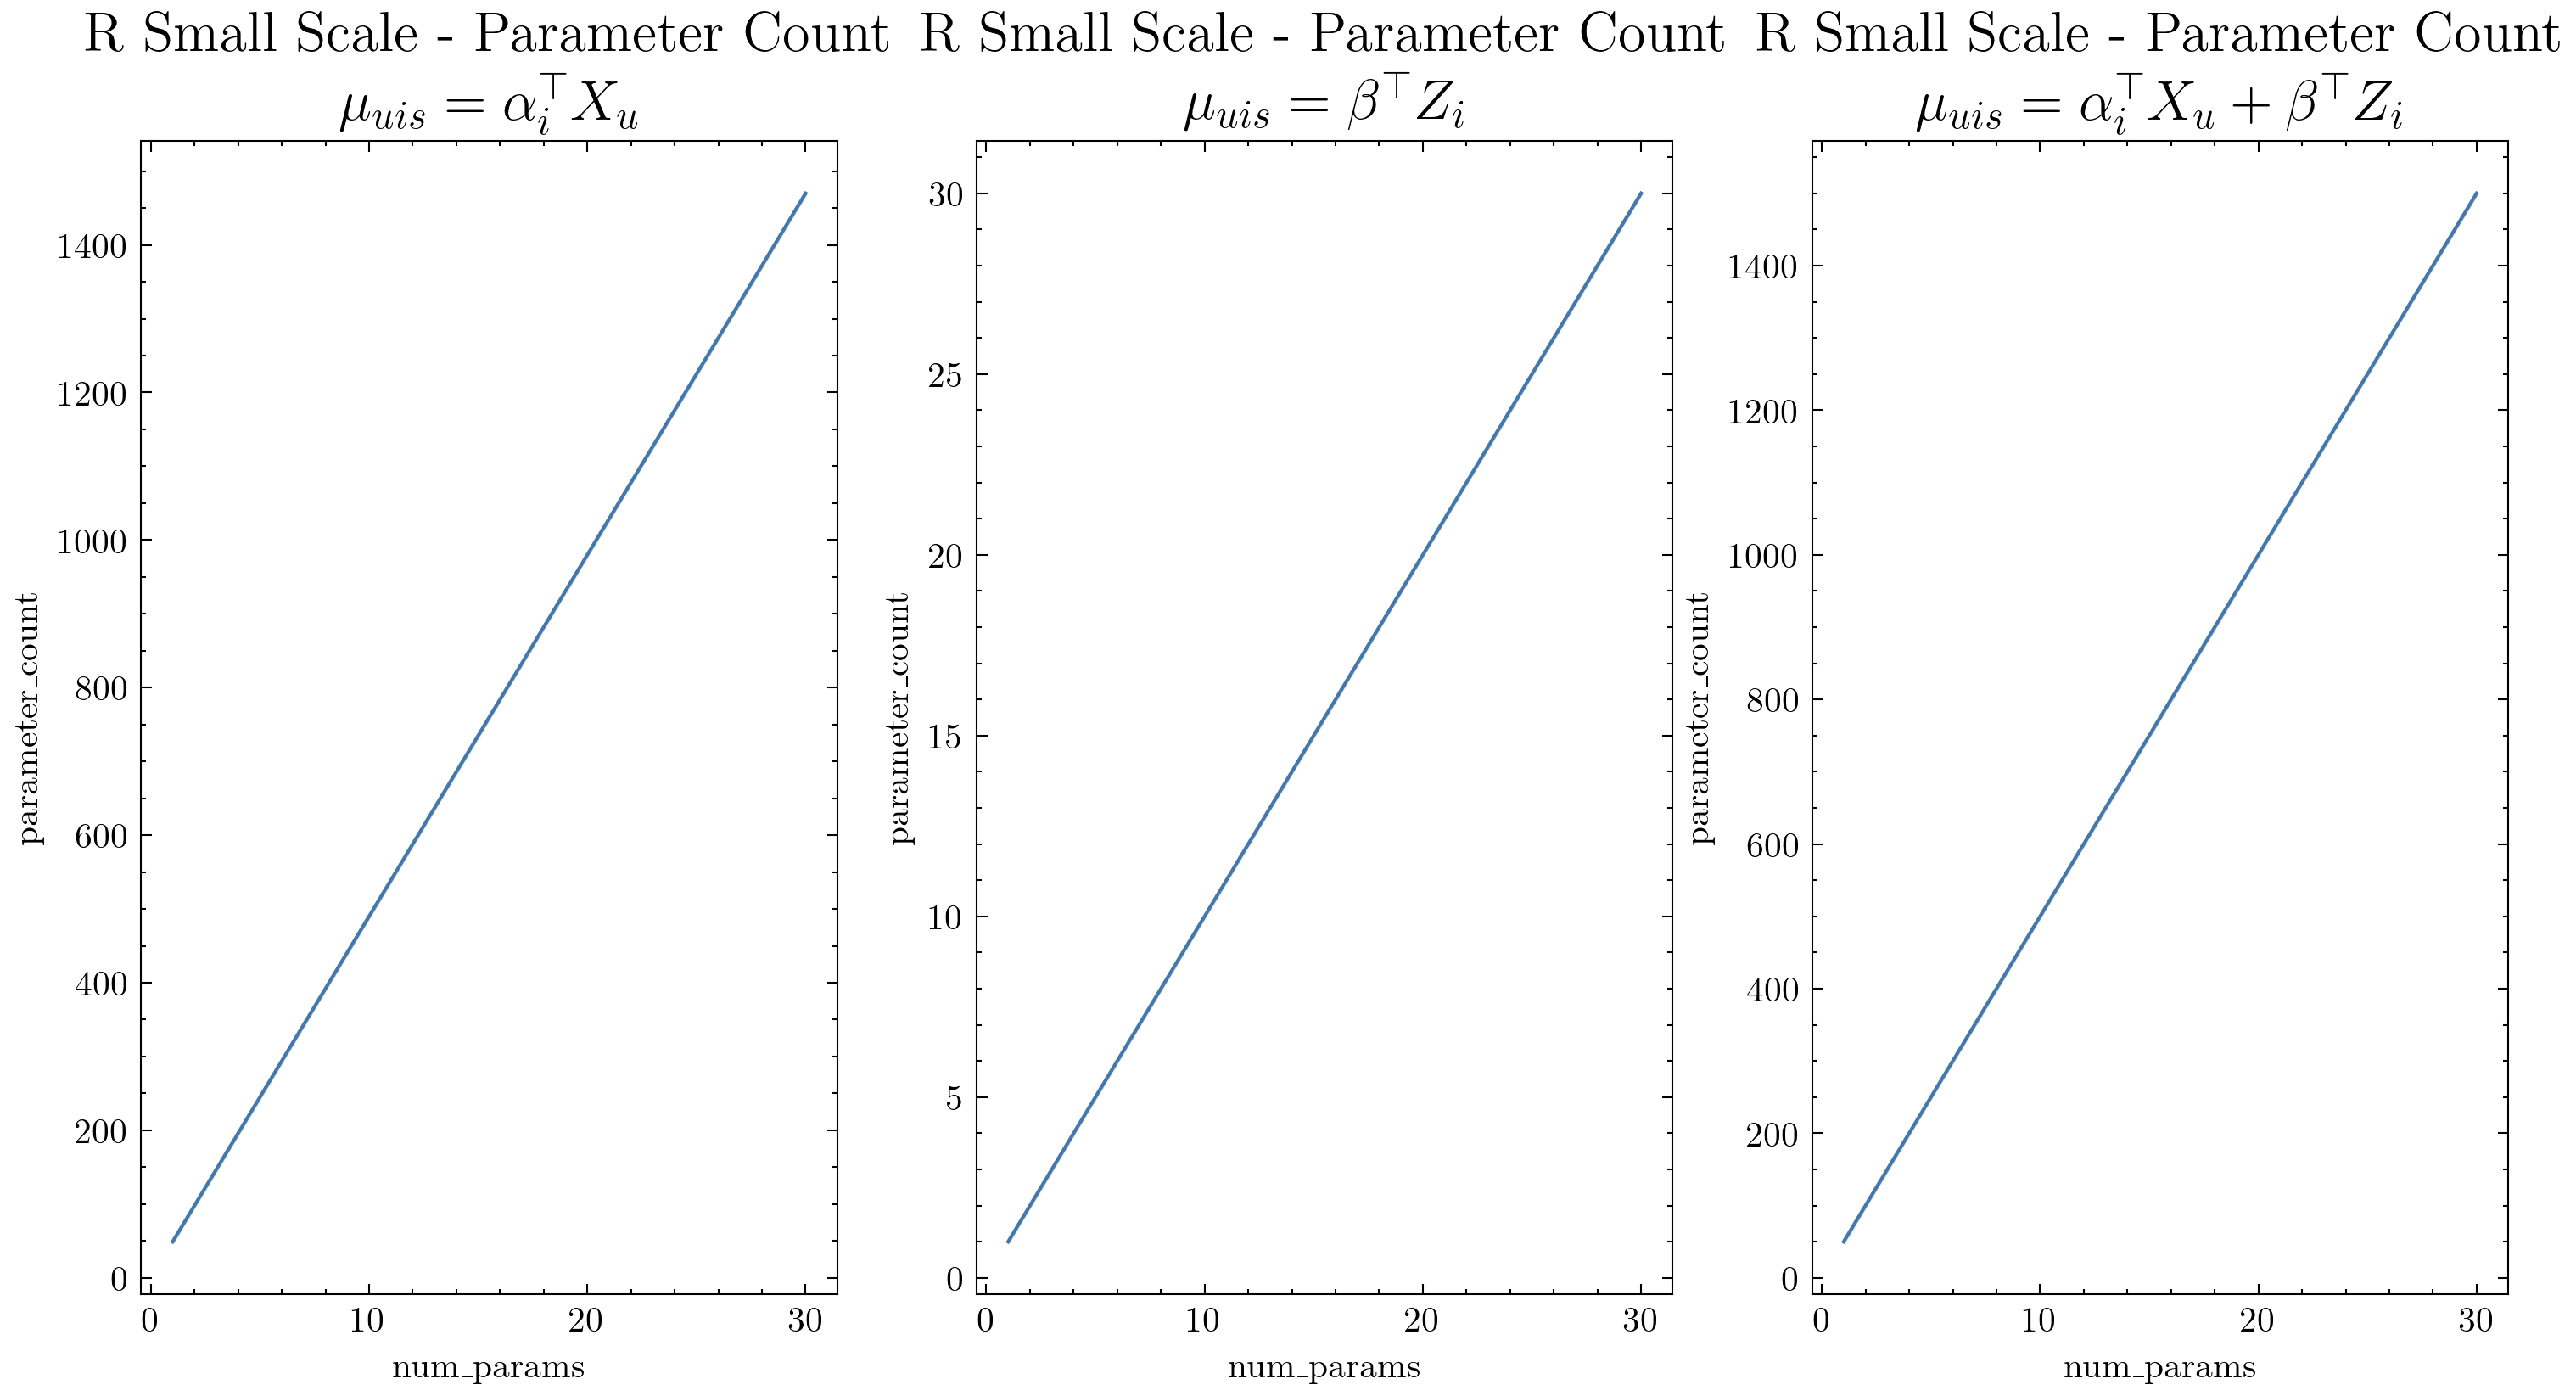

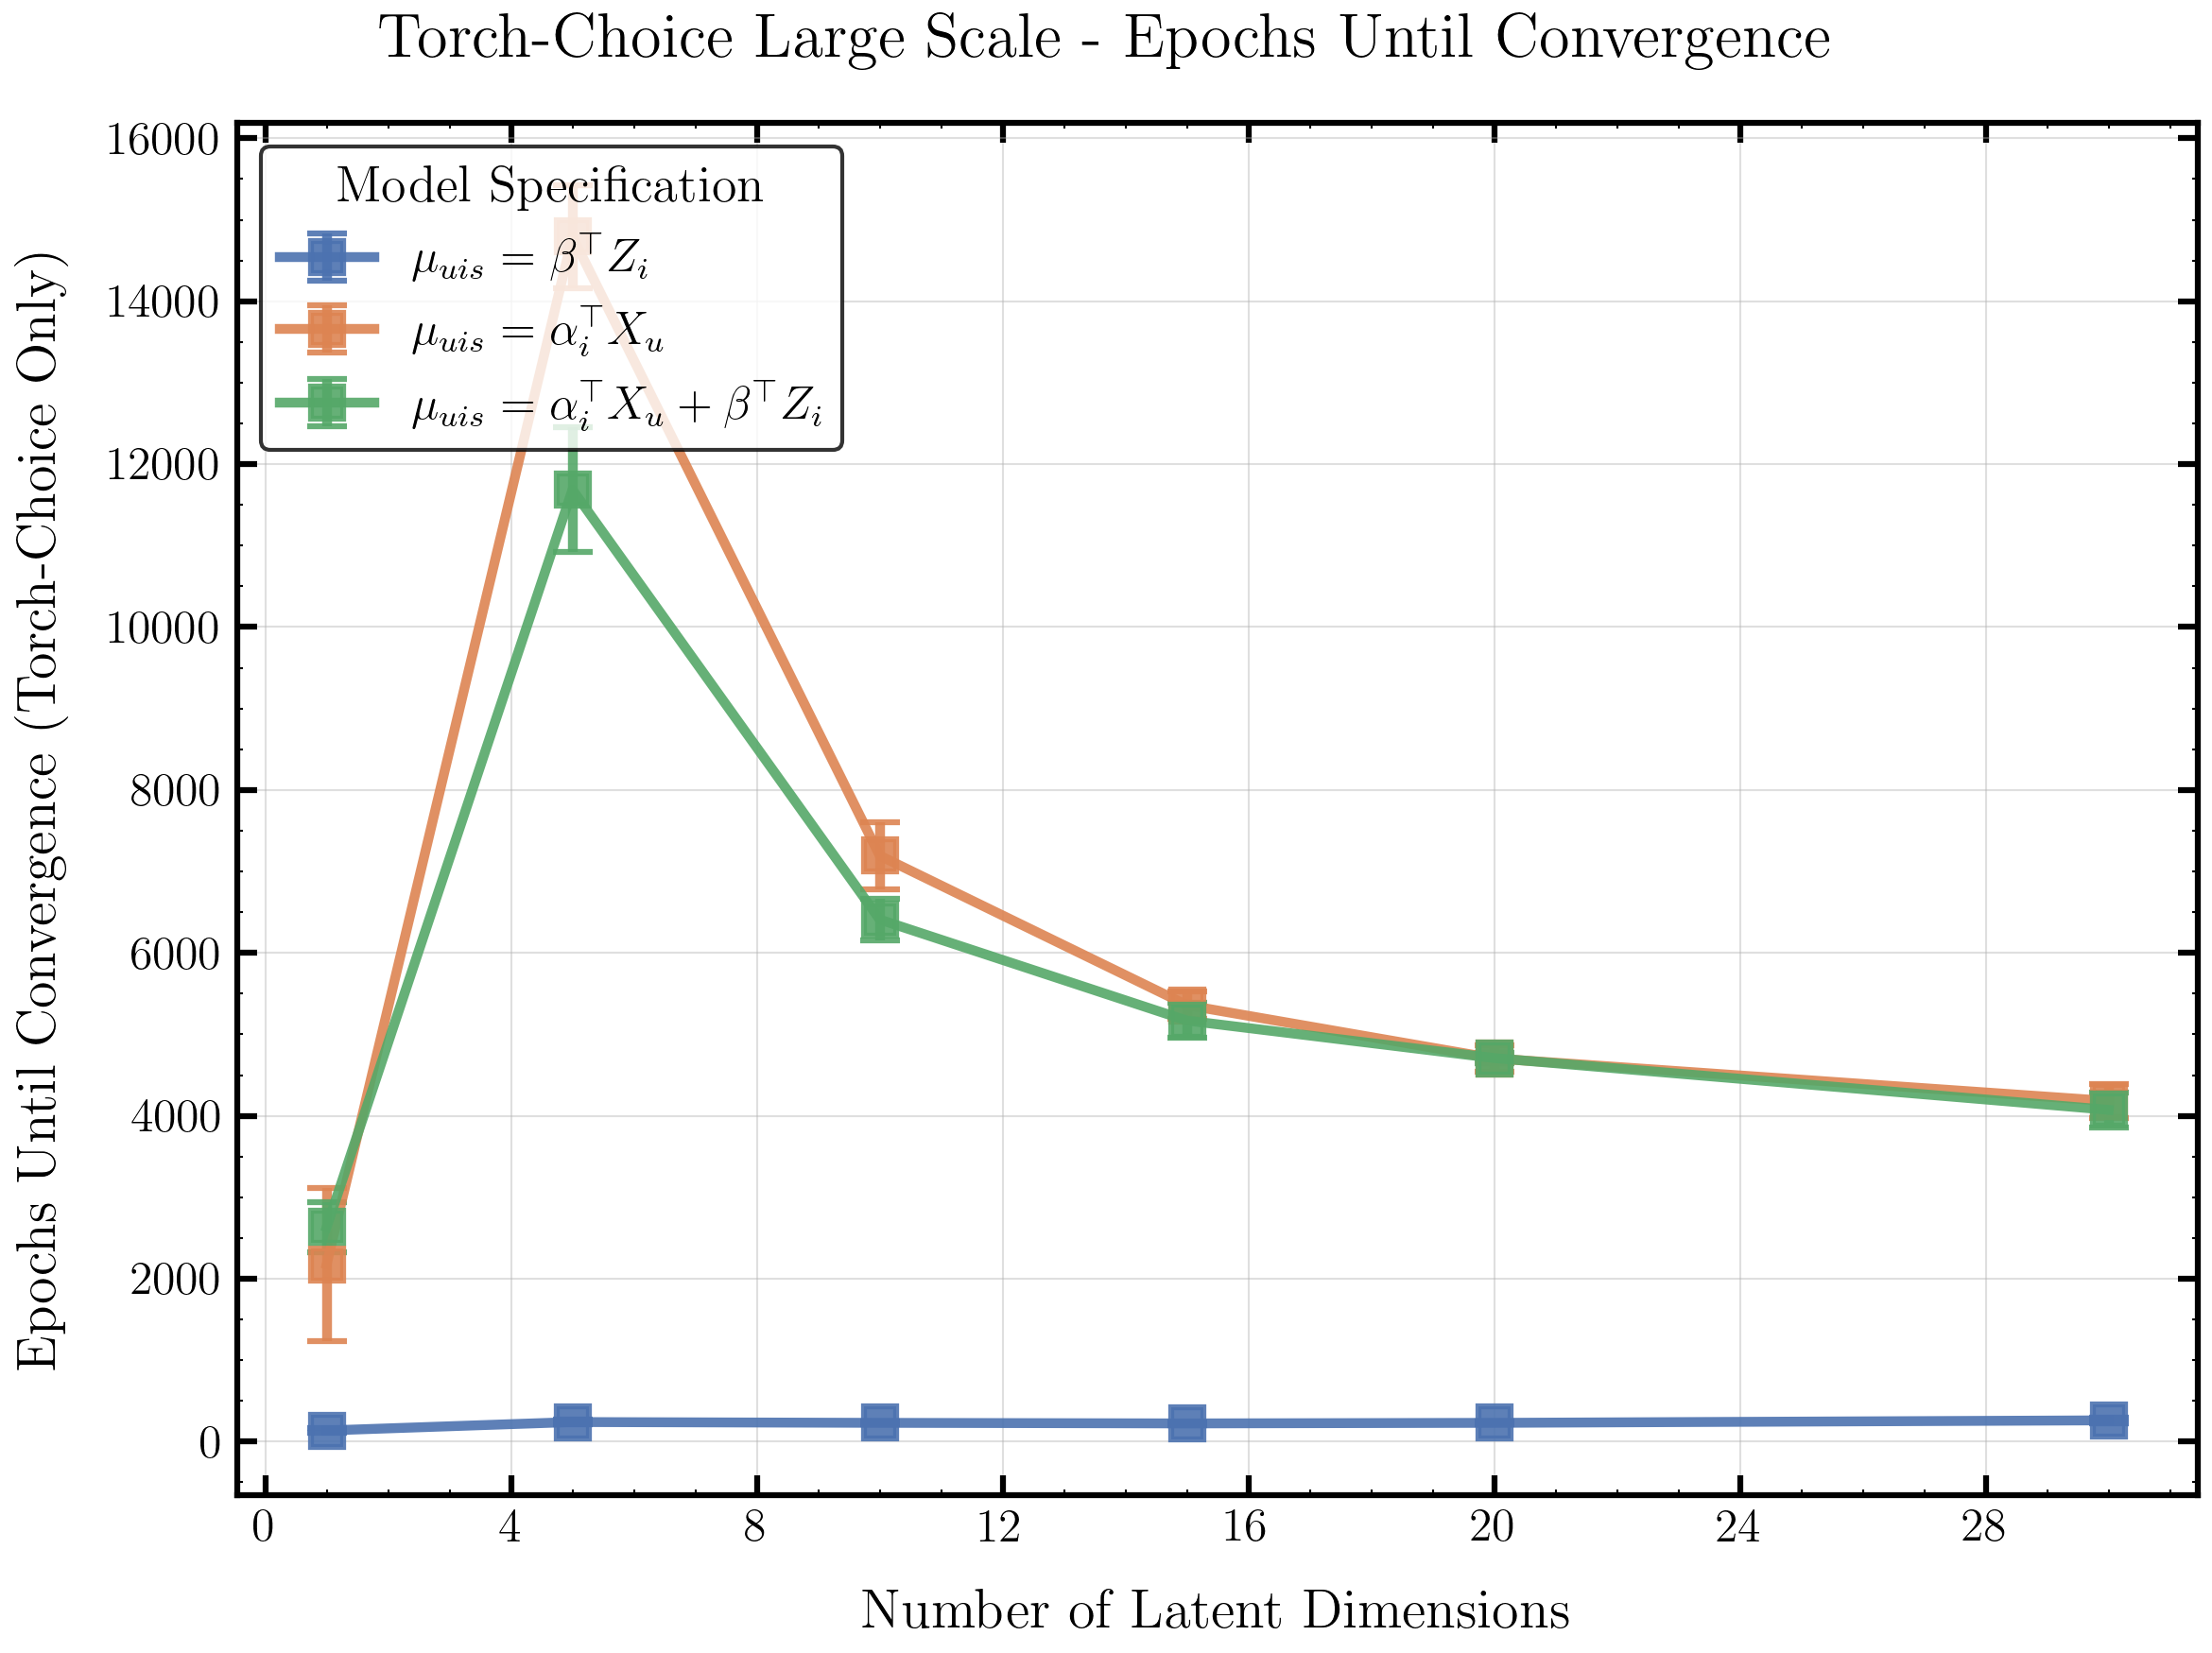

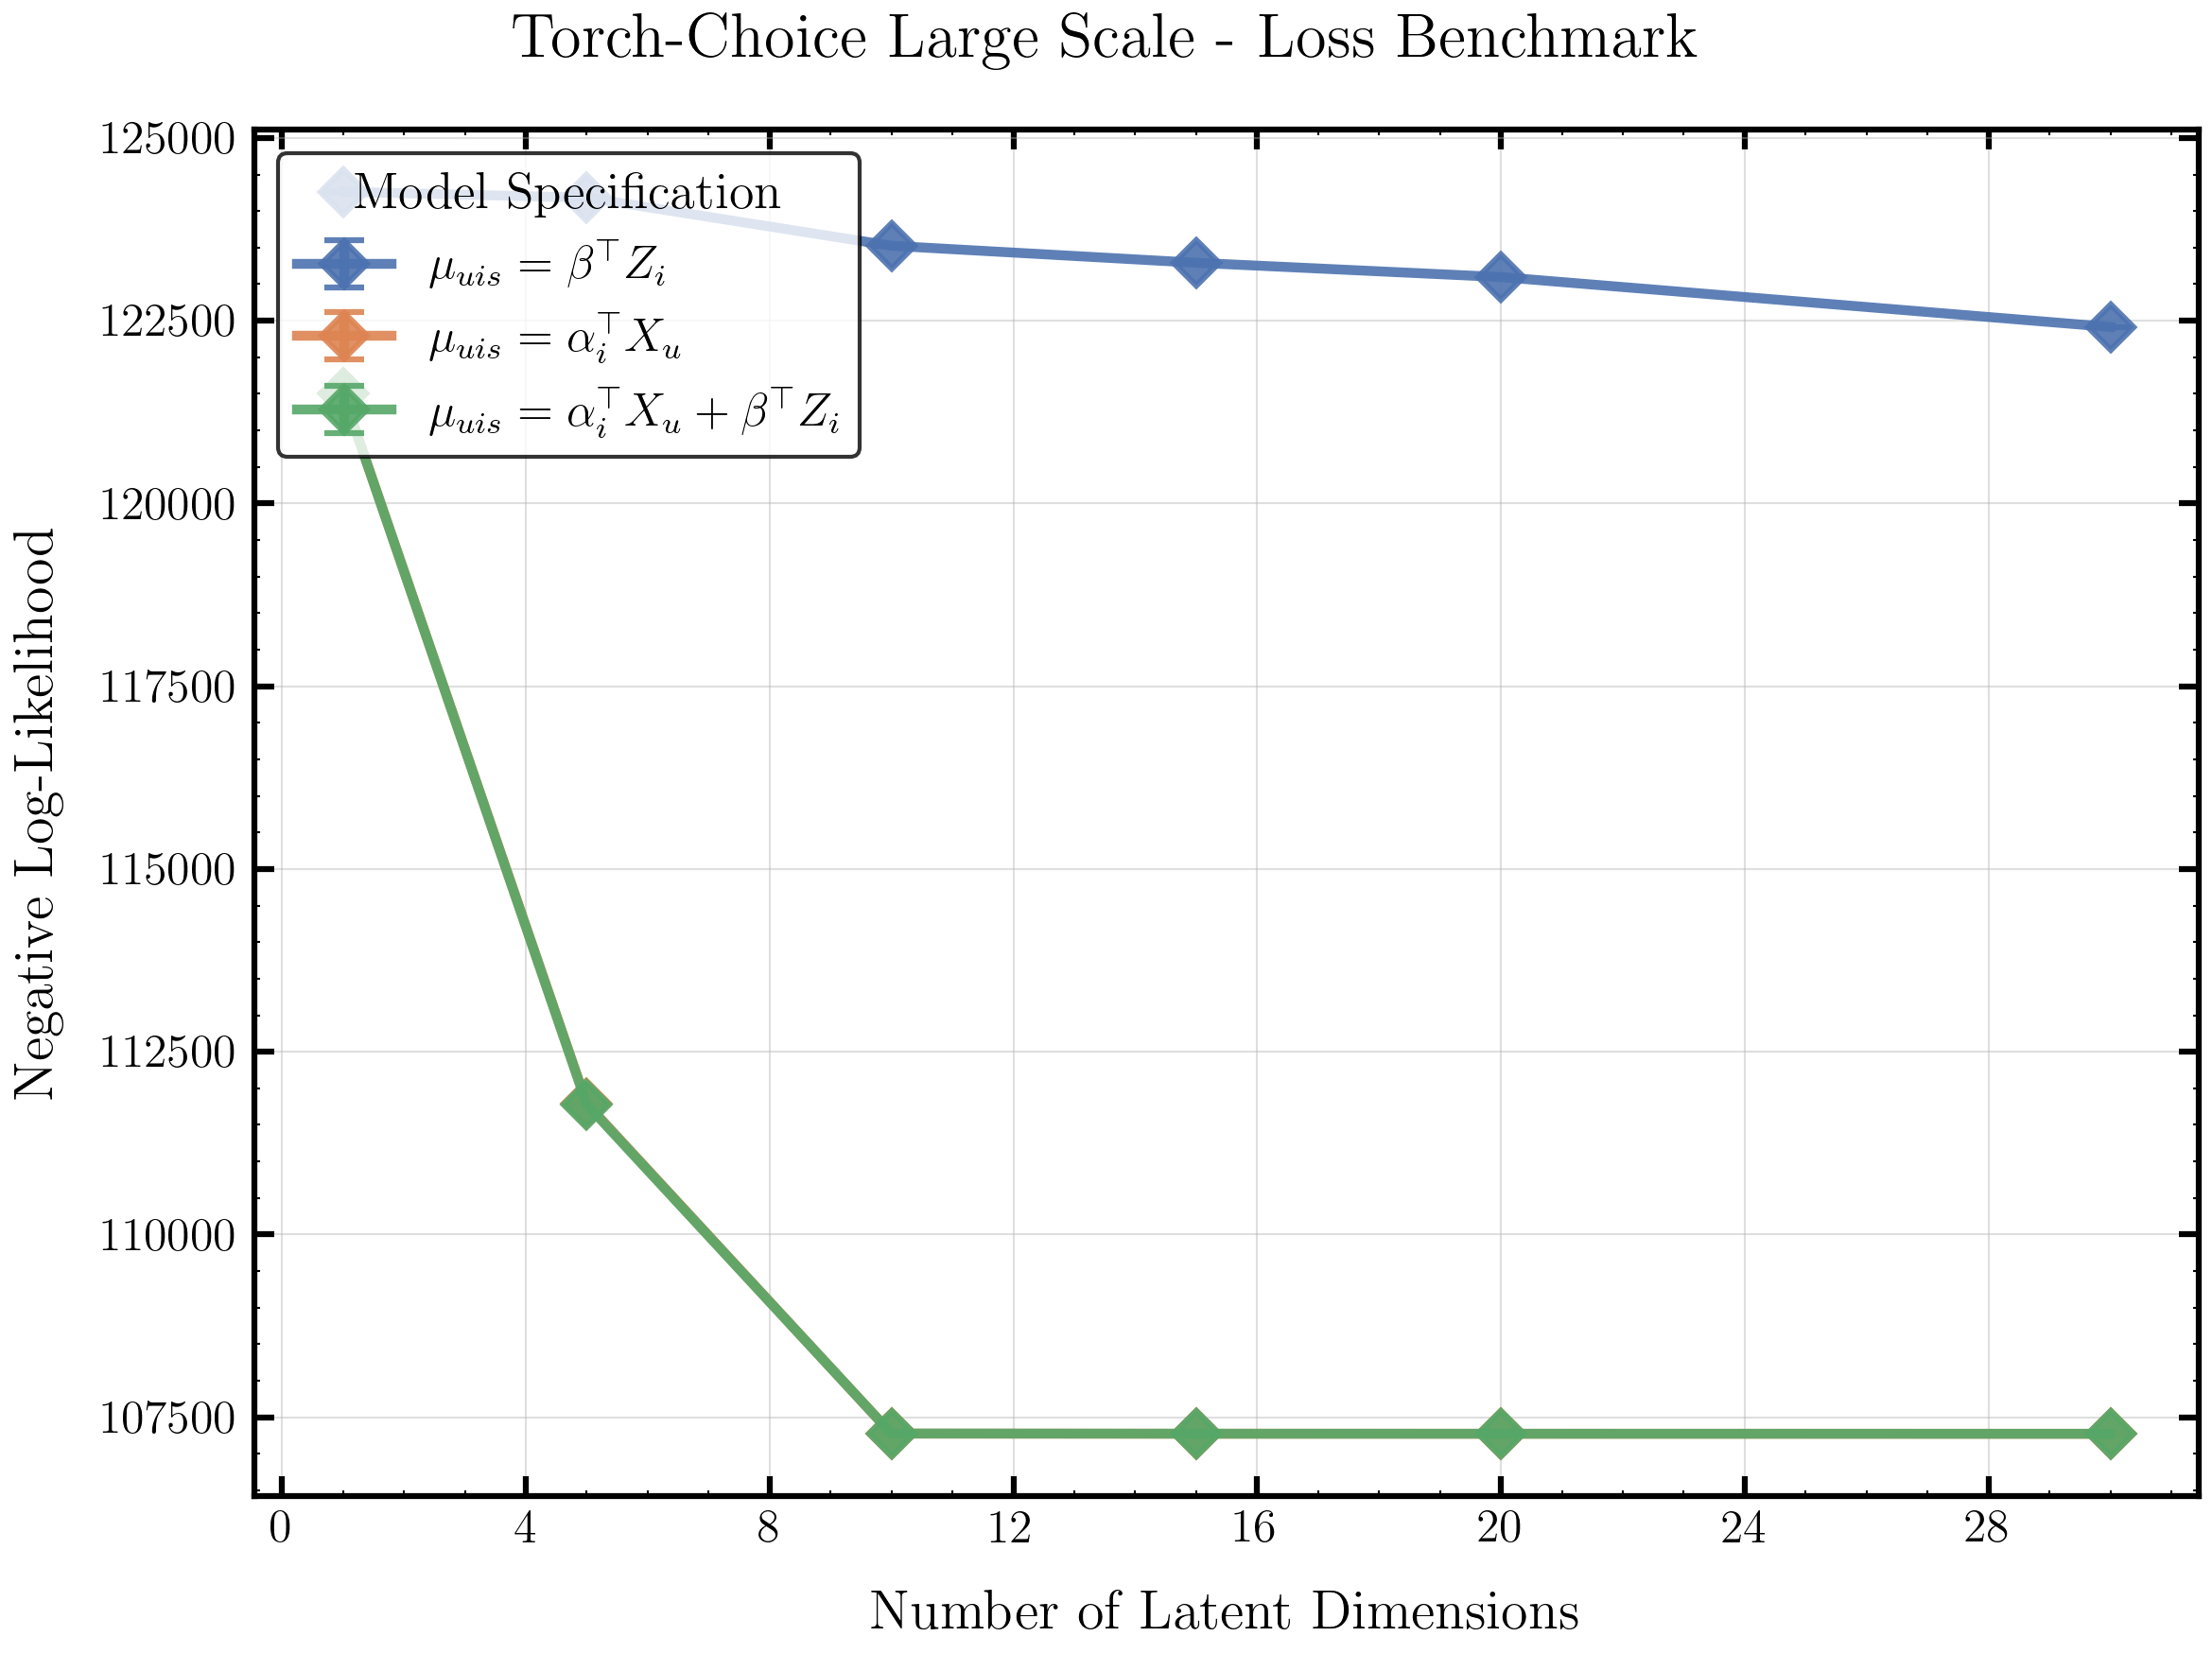

In [6]:
# ignore user warnings
warnings.filterwarnings("ignore", category=UserWarning)


for report_ratio in [True, False]:
    for parameter in ["num_items", "num_records", "num_params"]:
        fig = plt.figure(tight_layout=True, figsize=(15, 12))
        gs = gridspec.GridSpec(2, 2)
        axes = list()
        axes.append(fig.add_subplot(gs[0, 0]))
        axes.append(fig.add_subplot(gs[0, 1]))
        axes.append(fig.add_subplot(gs[1, :]))

        for i, (title, log_file_path) in enumerate([
            ("Torch-Choice Small Scale", os.path.join(TORCH_RECORD_PATH, f"torch_choice_{parameter}_experiment_small.csv")),
            ("R Small Scale", os.path.join(R_RECORD_PATH, f"R_performance_{parameter.replace('num_', '')}.csv")),
            ("Torch-Choice Large Scale", os.path.join(TORCH_RECORD_PATH, f"torch_choice_{parameter}_experiment_large.csv")),
        ]):
            ax = axes[i]
            epochs_fig, loss_fig = visualize_benchmarks_combined(log_file_path, parameter, ax, report_ratio=report_ratio, log_scale=False, plot_title=title)

            # these figures are the same with and without report_ratio.

            def clean_title(orginal_title: str) -> str:
                return orginal_title.replace(" ", "_").replace("-", "_").lower()

            if epochs_fig is not None:
                epochs_fig.savefig(os.path.join(OUTPUT_PATH, f"{'time_ratio' if report_ratio else 'absolute_time'}_{clean_title(title)}_{parameter}_epochs.pdf"), bbox_inches='tight', dpi=300)

            loss_fig.savefig(os.path.join(OUTPUT_PATH, f"{'time_ratio' if report_ratio else 'absolute_time'}_{clean_title(title)}_{parameter}_loss.pdf"), bbox_inches='tight', dpi=300)

        # save the figure.
        fig.savefig(os.path.join(OUTPUT_PATH, f"{'time_ratio' if report_ratio else 'absolute_time'}_{parameter}_time_cost_benchmark.pdf"), bbox_inches='tight', dpi=300)